This file focuses on the Decision-making of the customers in the Outsourcing DVC Model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output
import time
import csv

from datetime import datetime
from numba import jit
from scipy.optimize import linprog
from scipy.optimize import minimize
from matplotlib.patches import Polygon
from matplotlib.widgets import Slider
%matplotlib inline

from scipy.linalg import eigh, cholesky
from scipy.stats import norm

from pylab import plot, show, axis, subplot, xlabel, ylabel, grid

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
!python3 -V

Python 3.10.12


## Model setup

Owners: firms a and b

Developers: firms c and d (respectively to a and b)

Consumers: users from 1 to n

Local governments

Global maximizer

In [ ]:
## Functions
### We change the total cost here

# Example functions of deltap
def deltap_a(c_0_a): # added value brought by developers
  return 2 * c_0_a # linear
  # return 20 * np.log()

def deltap_b(c_0_b):
  return 2 * c_0_b # linear

# Example functionality of softwares
def theta_func(theta_1_bar_a, c_0_a):
  def deltap_a(c_0_a):
    return 2 * c_0_a
  theta_1 = theta_1_bar_a + deltap_a(c_0_a) # baseline quality + added value
  return theta_1

# Example utility function of customer
def util(u_bar_a, x_1, y_1, theta_1, c_0_a, p_s_a):
  utiliti = u_bar_a + x_1 * theta_1 + y_1 * c_0_a - p_s_a
  return utiliti

# Example functions of profits of owners (firms a and b)
def profit_a(m, price_s_a, c_0_a, c_res_a):
  # def deltap_a(c_0_a):
  #   return 2 * c_0_a
  # c_total_a = 2 * c_0_a + m * c_res_a # consider c_res_a as a unit cost
  c_total_a = c_0_a ** 3 + m * c_res_a # consider c_res_a as a unit cost

  prof_a = m * price_s_a - c_total_a
  return prof_a

## Distribution of the tastes of Consumers

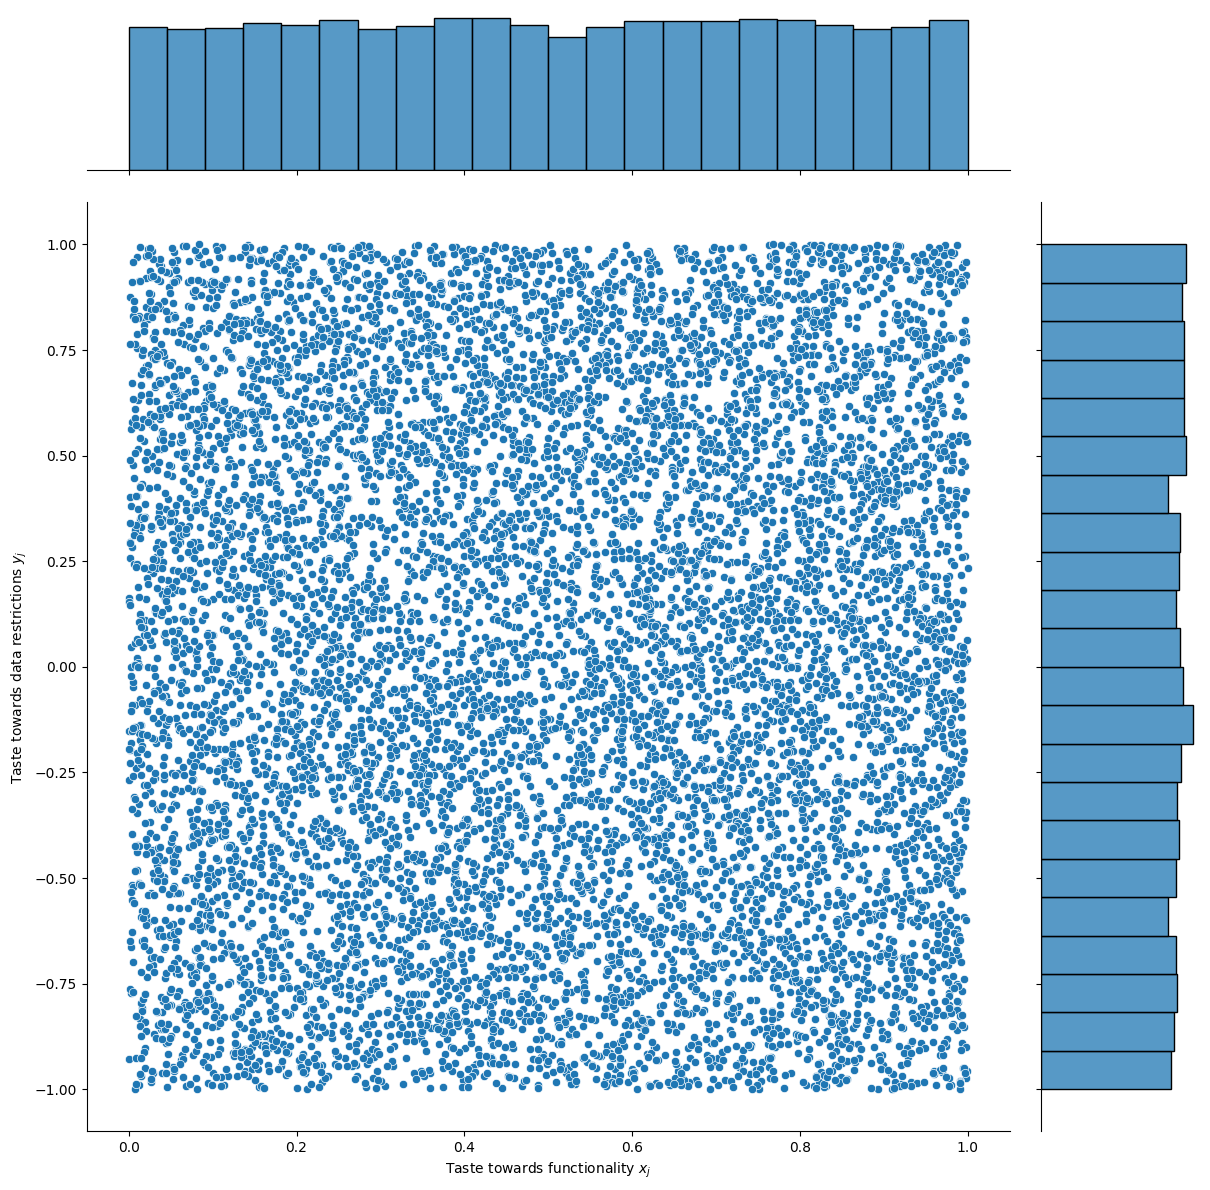

In [ ]:
# number of customers
n_customers = 10000 # 10000, 100

## Setting of the Consumers' tastes
### Bivariate Uniform Distribution
np.random.seed(5) # 1, 5, 10,
s = np.random.uniform(0,1,n_customers)
st_R = np.random.uniform(-1,1,n_customers)
pts_df = pd.DataFrame({'Taste towards functionality $x_j$': s,
                       'Taste towards data restrictions $y_j$': st_R})
sns.jointplot(data = pts_df, x = "Taste towards functionality $x_j$",
                             y = "Taste towards data restrictions $y_j$",
                             height = 12)

# Bivariate Normal Distribution
# var_x_j = 1/24 # 1/24 # greater variance: sample more varied
# var_y_j = 1/6  # 1/6  # consider the range of the two samples
# # To control the correlation we adjust the covariance matrix.
# cov_x_y = 0.074 # 0.074, 0, -0.074
# gcoef = cov_x_y / np.sqrt(var_x_j * var_y_j) # goal correlation coef.
# gcoef # coef. should be in [-1, 1]

## Deterministic results

Example result of the market in one period

Note: We keep the variables which make a difference in the model.

Welfare analysis: Here we define the global welfare as the aggregate utility of the consumers minus the global aggregate cost.

$W = ∑u_{ij} - \sum c_{total}$

In [ ]:
## Results

parameter_names = ['data restriction level', # $c_{res, i}$
                   'cost of contract', # investment of the Owner $c_{0, i}$
                   'price of product', # $p_{s, i}$
                   'functionality of product', # $\theta_i$
                   'utility constant', # $\bar{u}_{j,i}$
                   'number of purchase', # $m_i$
                   'total revenue', # $m_i p_{s, i}$
                   'total cost', # $c_{total,i}$
                   'profit'] # $\Pi_i$


# policy factor: data restriction
c_res_a = 15; c_res_b = 15

# cost of contract
c_0_a = 0 # adjust the cost to raise the functionality # 60
c_0_b = 0 # 60

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# prices
price_s_a = 15
price_s_b = 15

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

# reserved utility
ru = np.random.uniform(50, 50, n_customers) # homogenous

# buy randomly from one company if the utilities are the same
bin = np.random.binomial(1, 0.5, n_customers)

buy = []
buy2 = []
welf = []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
      welf.append(utili_a[i])
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
      welf.append(utili_b[i])
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
      welf.append(utili_a[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [c_res_a,
                           c_0_a,
                           price_s_a,
                           theta_1_value_a,
                           u_bar_a,
                           m1,
                           m1 * price_s_a,
                           deltap_a(c_0_a) + m1 * c_res_a,
                           pr1]
parameter_values_list_b = [c_res_b,
                           c_0_b, price_s_b,
                           theta_1_value_b, u_bar_b,
                           m2,
                           m2 * price_s_b,
                           deltap_a(c_0_b) + m2 * c_res_b,
                           pr2]

# Objective functions regarding the global welfare
agg_total_cost = deltap_a(c_0_a) + m1 * c_res_a + deltap_a(c_0_b) + m2 * c_res_b
agg_welfare = sum(welf) - agg_total_cost

Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})

print(f"Global welfare equals: {round(agg_welfare, 2)}")
print(f"Global profit equals: {round(pr1 + pr2, 2)}")
# Question: Are the global welfare and the global profit positively correlated?
# No, instead, they might be negatively correlated.
Table_param

Global welfare equals: 706088.64
Global profit equals: 0


Parameters and Outcomes  Region A  Region B
0    data restriction level      15.0      15.0
1          cost of contract       0.0       0.0
2          price of product      15.0      15.0
3  functionality of product       0.8       0.8
4          utility constant     100.0     100.0
5        number of purchase    5012.0    4988.0
6             total revenue   75180.0   74820.0
7                total cost   75180.0   74820.0
8                    profit       0.0       0.0

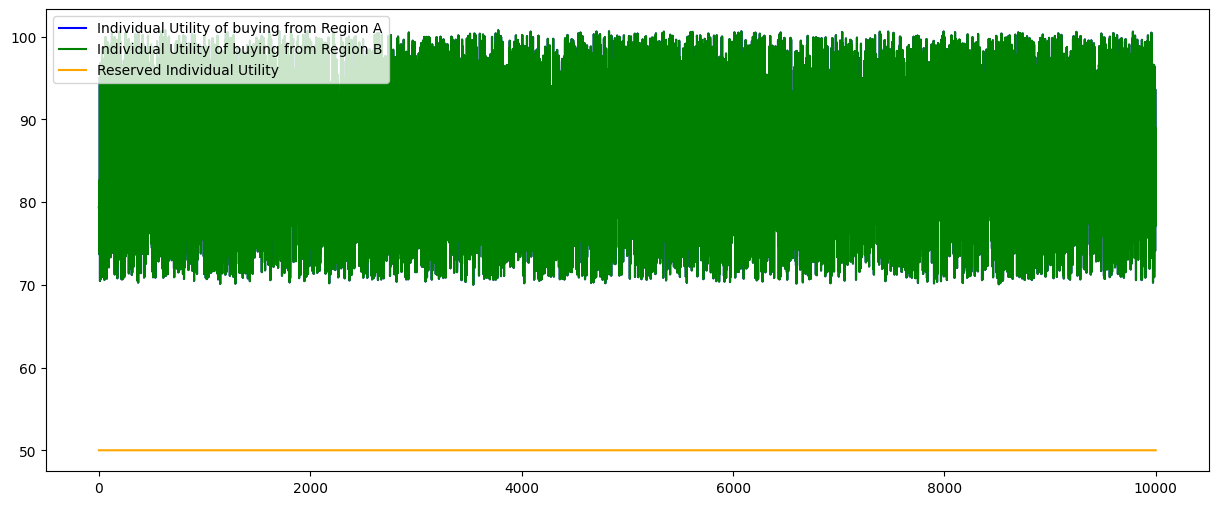

In [ ]:
plt.figure(figsize = [15,6])
plt.plot(utili_a,'blue')
plt.plot(utili_b,'green')
plt.plot(ru,'orange')
plt.legend(['Individual Utility of buying from Region A',
            'Individual Utility of buying from Region B',
            'Reserved Individual Utility'])
plt.show()

Plot the customers in a map

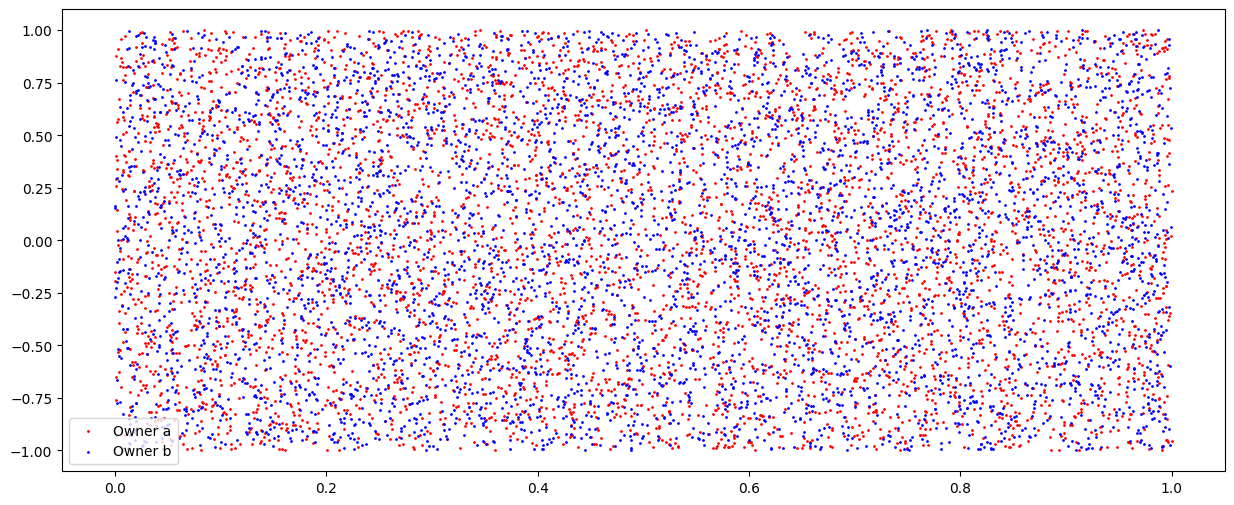

In [ ]:
# plot the points

set_A_x = []
set_A_y = []
set_B_x = []
set_B_y = []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      set_A_x.append(s[i])
      set_A_y.append(st_R[i])
    elif utili_a[i] < utili_b[i]:
      set_B_x.append(s[i])
      set_B_y.append(st_R[i])
    else:
      if bin[i] == 1:
        set_A_x.append(s[i])
        set_A_y.append(st_R[i])
      else:
        set_B_x.append(s[i])
        set_B_y.append(st_R[i])
  else:
    pass

plt.figure(figsize = [15,6])
plt.plot()
plt.scatter(set_A_x, set_A_y, c = 'red', s = 1)
plt.scatter(set_B_x, set_B_y, c = 'blue',  s = 1)
plt.legend(['Owner a', 'Owner b'])
plt.show()

## Example Distributions

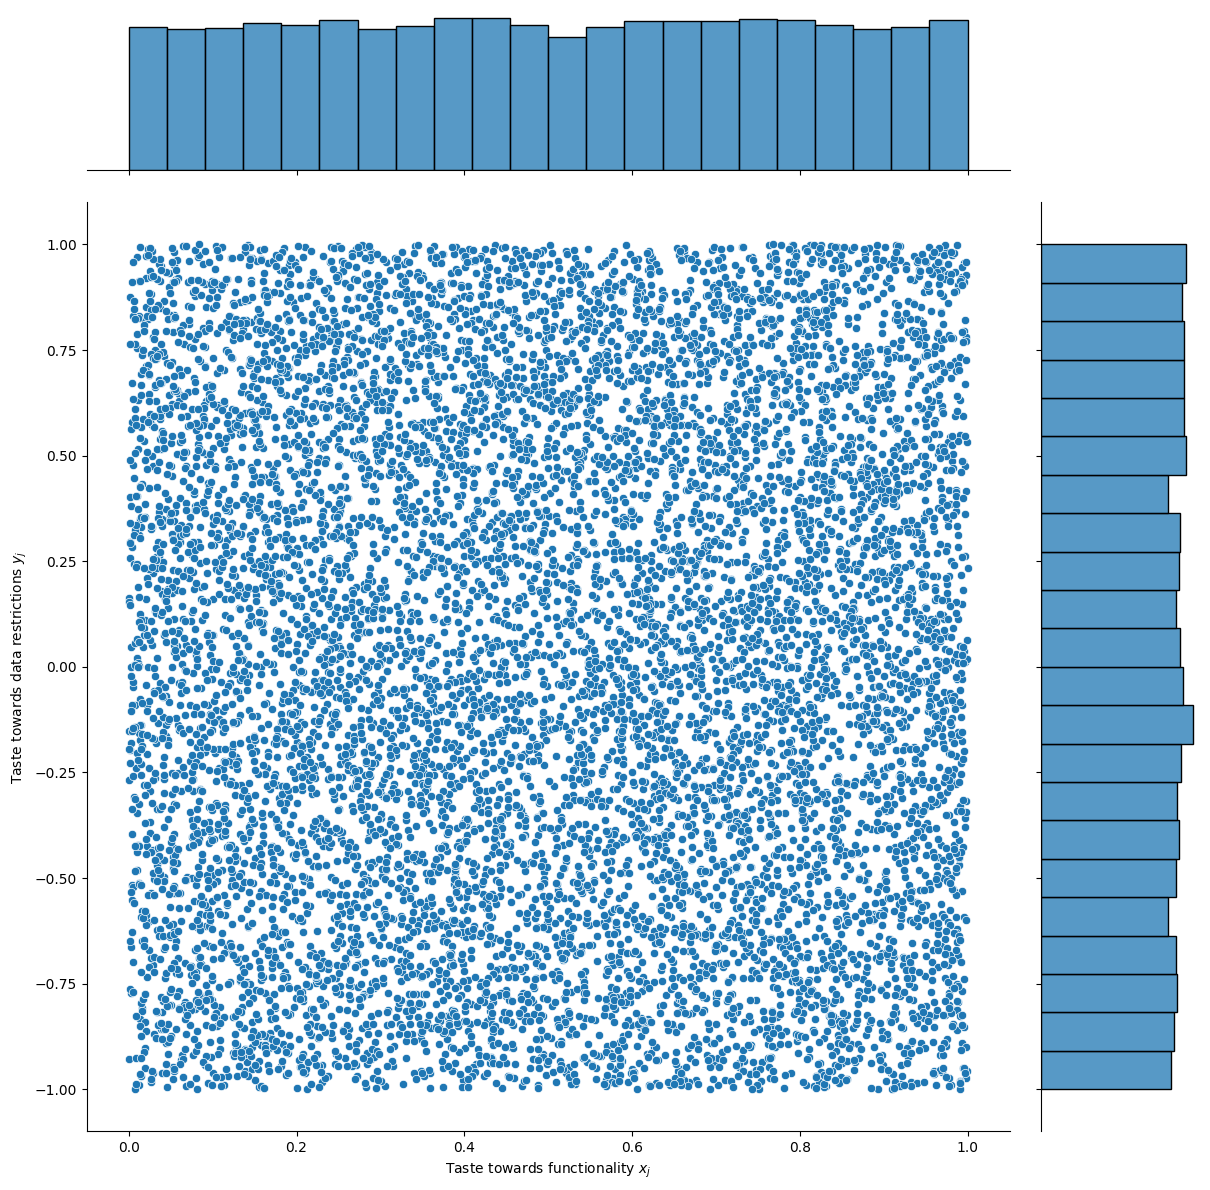

In [ ]:
pts_df0 = pd.read_csv("rand_sample01_unif_10000.csv")
sns.jointplot(data = pts_df0, x = "Taste towards functionality $x_j$",
                             y = "Taste towards data restrictions $y_j$",
                             height = 12)

In [ ]:
pts_df0.min(), pts_df0.max()

(Taste towards functionality $x_j$        0.000147
 Taste towards data restrictions $y_j$   -0.999769
 dtype: float64,
 Taste towards functionality $x_j$        0.999979
 Taste towards data restrictions $y_j$    0.999942
 dtype: float64)

In [ ]:
pts_df1 = pd.read_csv("rand_sample01.csv")
pts_df1.columns = ["Taste towards functionality $x_j$",
          "Taste towards data restrictions $y_j$"]

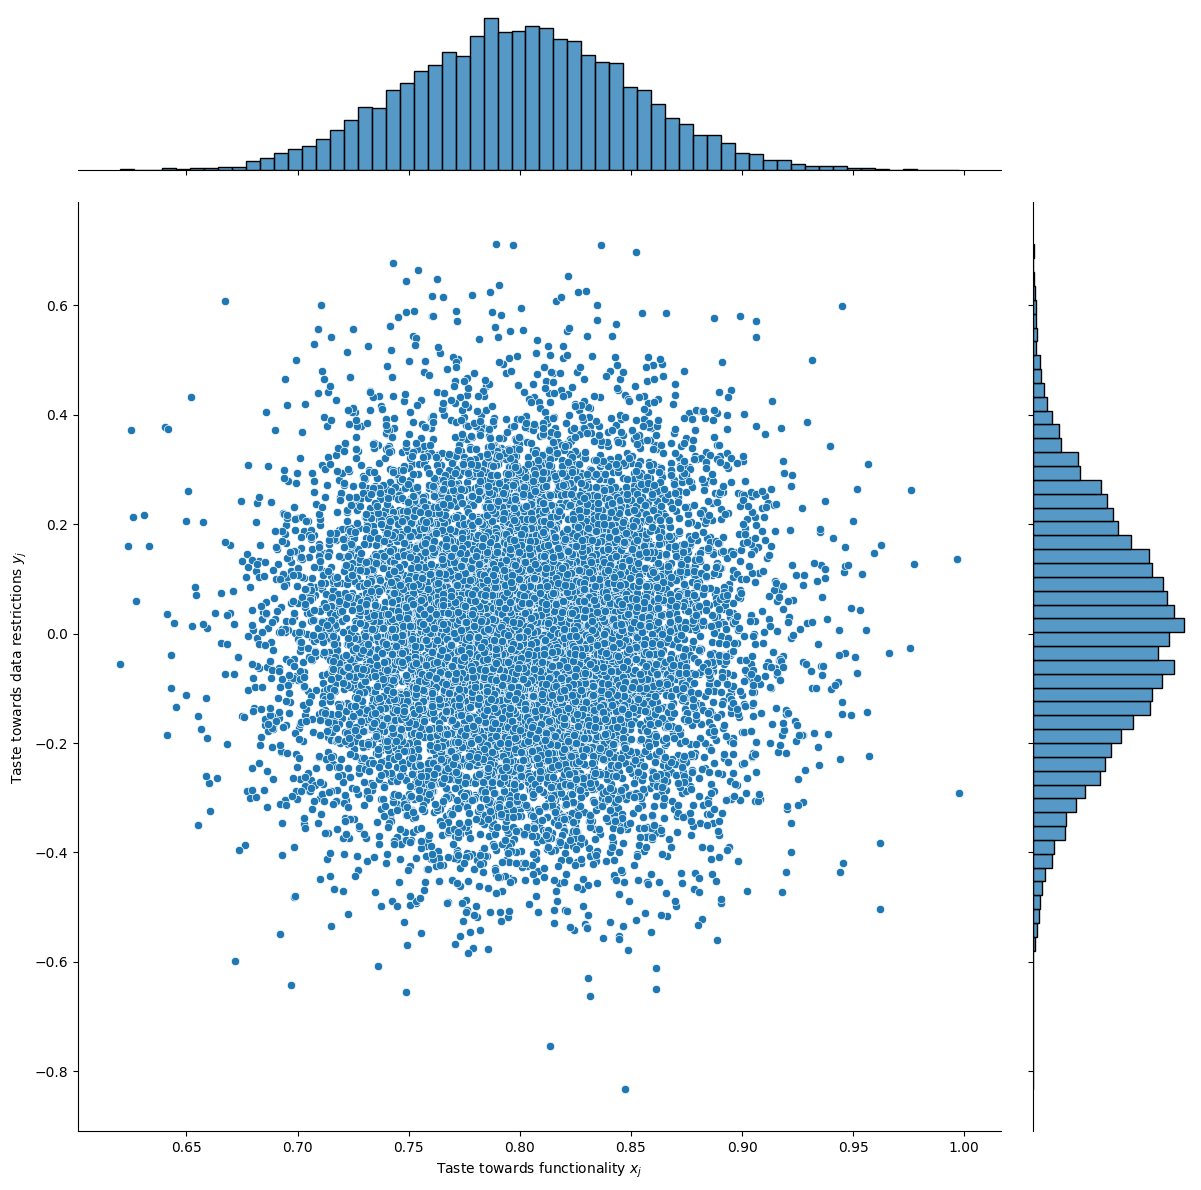

In [ ]:
sns.jointplot(data = pts_df1, x = "Taste towards functionality $x_j$",
                             y = "Taste towards data restrictions $y_j$",
                             height = 12)

In [ ]:
pts_df1.min(), pts_df1.max()

(Taste towards functionality $x_j$        0.62015
 Taste towards data restrictions $y_j$   -0.83290
 dtype: float64,
 Taste towards functionality $x_j$        0.997549
 Taste towards data restrictions $y_j$    0.711466
 dtype: float64)

In [ ]:
pts_df2 = pd.read_csv("/content/rand_sample02_new_100.csv")
pts_df2.columns = ["Taste towards functionality $x_j$",
          "Taste towards data restrictions $y_j$"]
# pts_df2

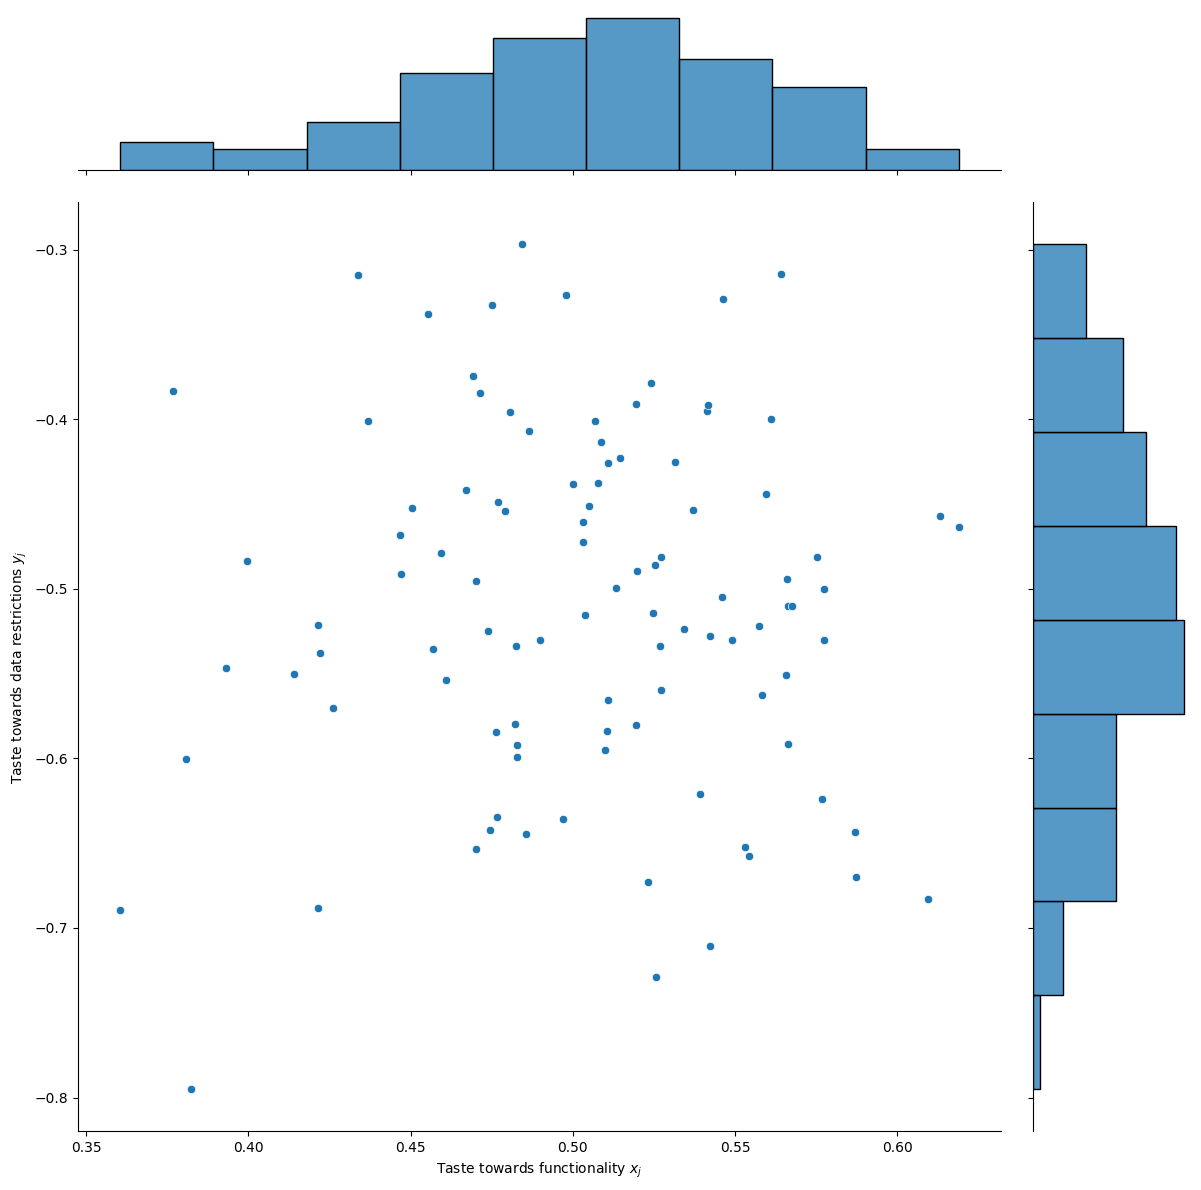

In [ ]:
sns.jointplot(data = pts_df2, x = "Taste towards functionality $x_j$",
                             y = "Taste towards data restrictions $y_j$",
                             height = 12)

In [ ]:
pts_df3 = pd.read_csv("/content/rand_sample03_new_100.csv")
pts_df3.columns = ["Taste towards functionality $x_j$",
          "Taste towards data restrictions $y_j$"]
# pts_df3

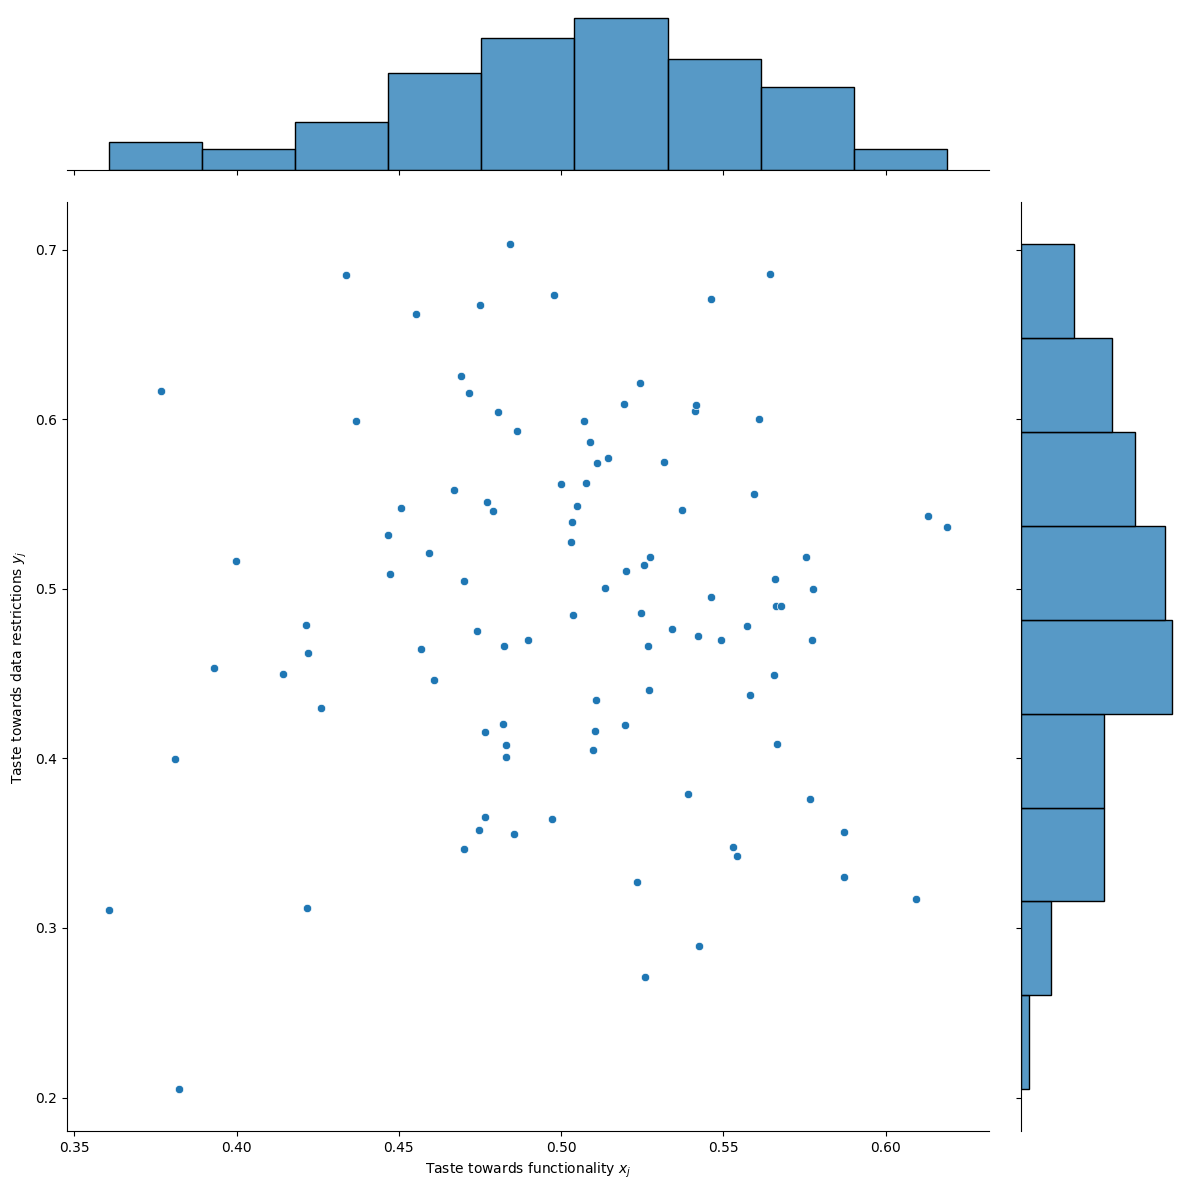

In [ ]:
sns.jointplot(data = pts_df3, x = "Taste towards functionality $x_j$",
                             y = "Taste towards data restrictions $y_j$",
                             height = 12)

In [ ]:
pts_df4 = pd.read_csv("/content/rand_sample04_new_10000.csv")
# pts_df4

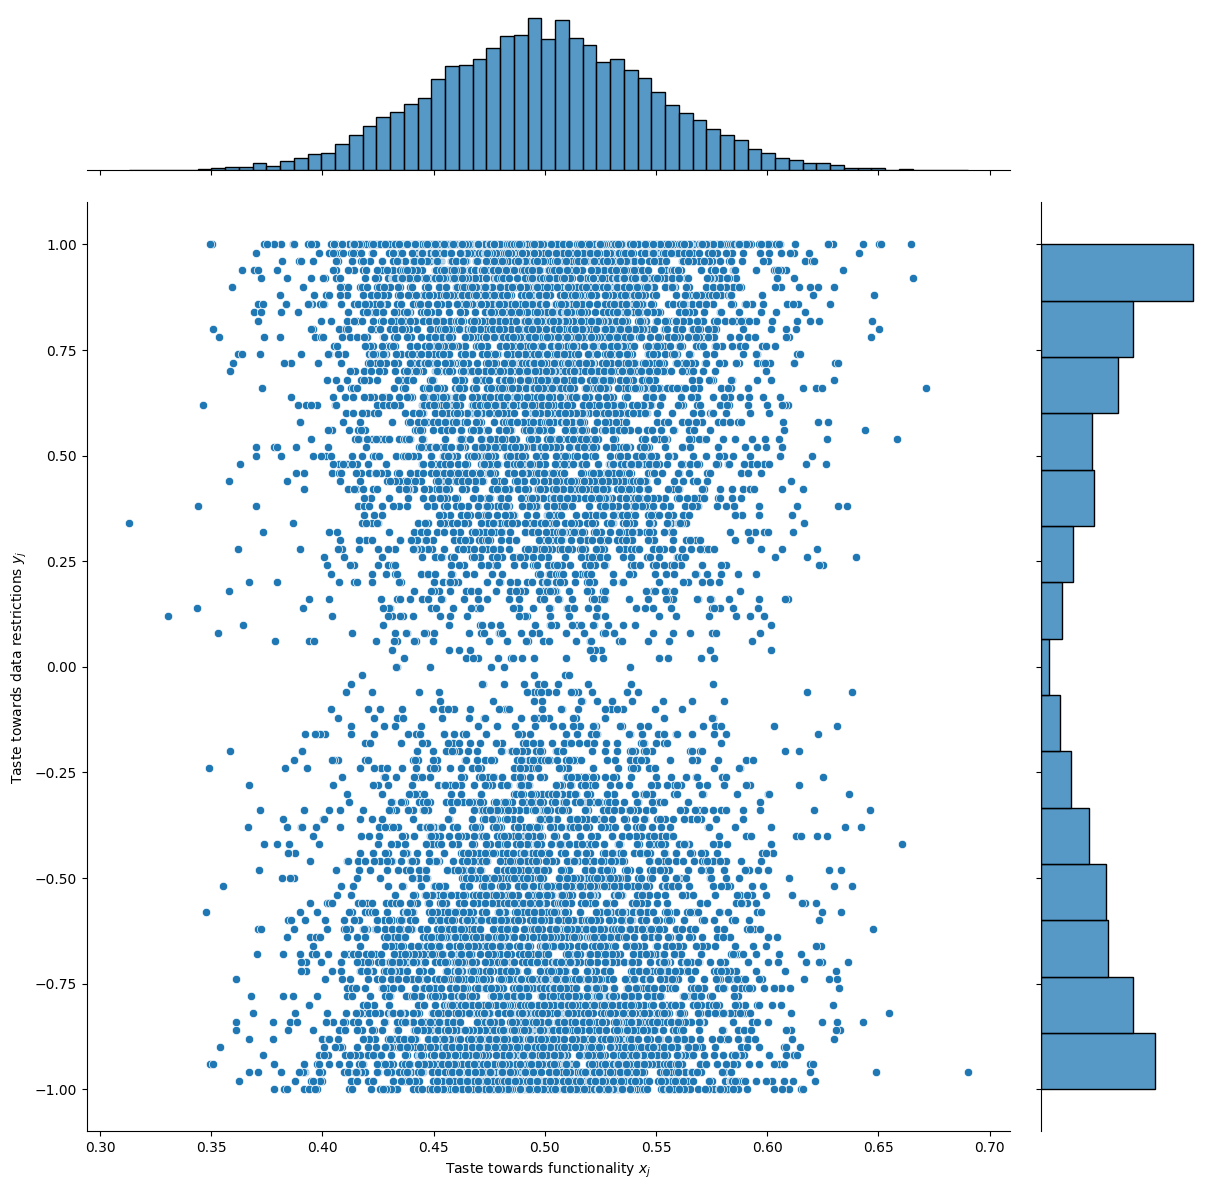

In [ ]:
sns.jointplot(data = pts_df4, x = "Taste towards functionality $x_j$",
                             y = "Taste towards data restrictions $y_j$",
                             height = 12)

A new distribution with

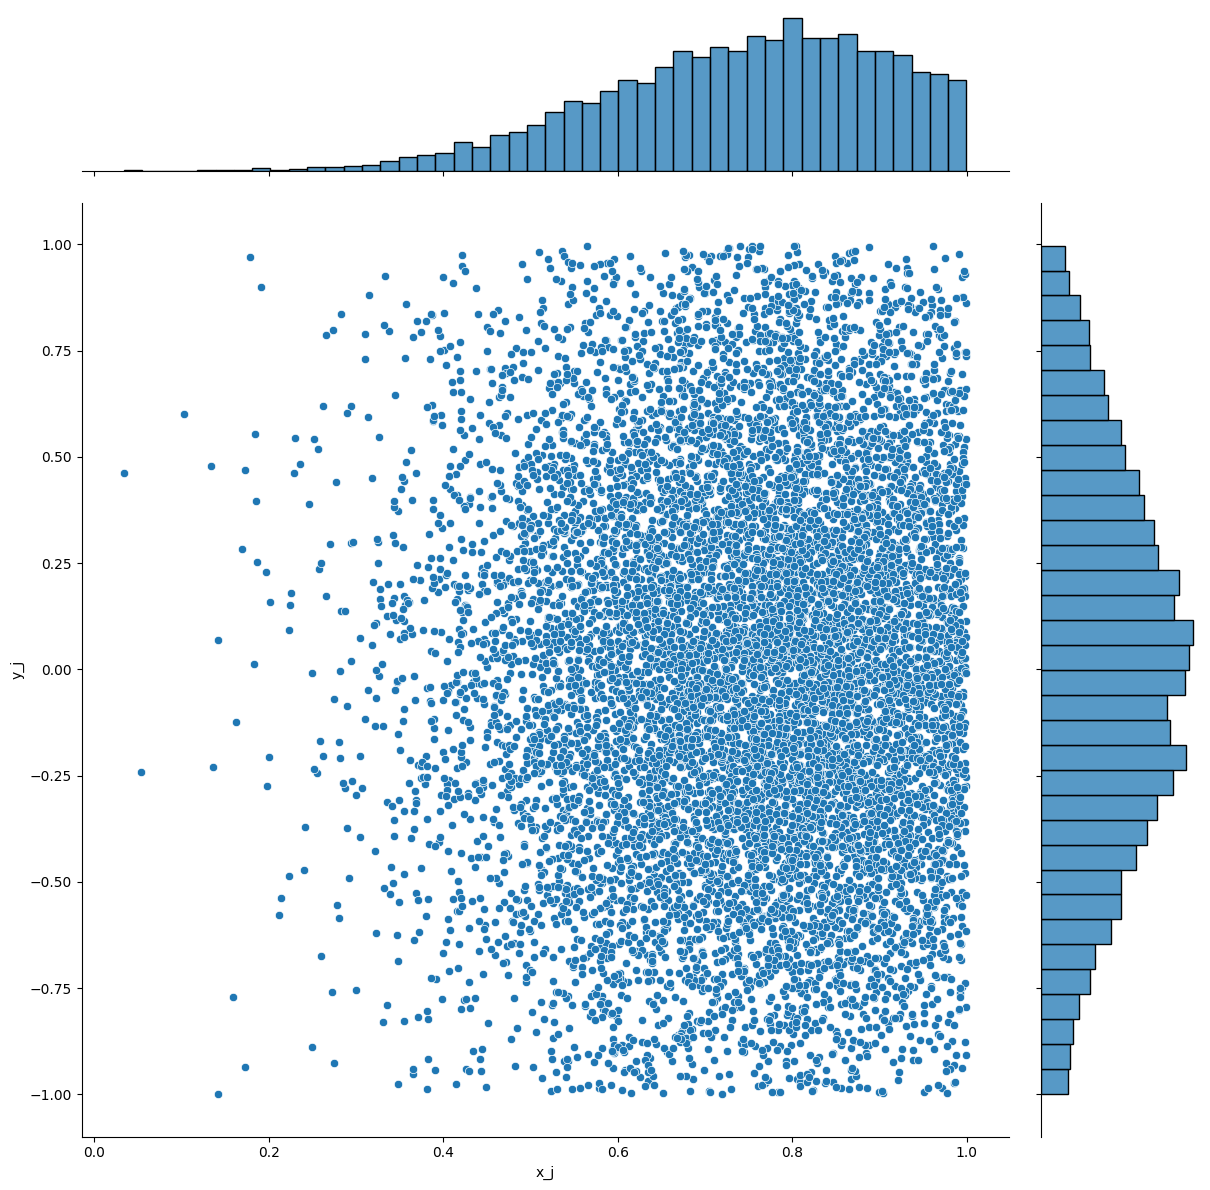

In [ ]:
### Building up a new distribution
n_customers = 10000 # 10000

# Bivariate Normal Distribution
var_x_j = 0.05 ** 2 # 0.05 ** 2, 0.2 ** 2
var_y_j = 0.5 ** 2  # 0.2 ** 2
# To control the correlation we adjust the covariance matrix.
cov_x_y = 0 # 0.074, 0, -0.074
gcoef = cov_x_y / np.sqrt(var_x_j * var_y_j) # goal correlation coef.
gcoef # coef. should be in [-1, 1]

np.random.seed(1)
cov = np.array([[var_x_j, cov_x_y], [cov_x_y, var_y_j]])
pts = np.random.multivariate_normal([0.8, 0], cov, size=int(1e6))

# Save the values of Consumers' tastes
x_j_list = []; y_j_list = [];
for i in range(len(pts)):
  x_j_list.append(pts[i][0])
  y_j_list.append(pts[i][1])

pts_df = pd.DataFrame({'x_j': x_j_list, 'y_j': y_j_list})
pts_df1 = pts_df[(pts_df.x_j <= 1) & (pts_df.x_j >= 0)][(pts_df.y_j <= 1) & (pts_df.y_j >= -1)]
pts_df = pts_df1.sample(n = n_customers, random_state=0)

# joint distribution of tastes
# customer's taste towards functionality x_i: s
s = pts_df.x_j.tolist()
# customer's taste towards regulation y_i: st_R
st_R = pts_df.y_j.tolist()

tastes00 = pts_df
sns.jointplot(data = tastes00, x = "x_j", y="y_j", height = 12)

In [ ]:
pts_ndf1 = pts_df.copy()

In [ ]:
pts_ndf1.to_csv('rand_sample_n02_10000.csv', index = False)

## Demand Function of Owners

In [ ]:
# Holding all others equal and we don't consider that of firm b
# Find the relation between Price and Quantity (number of people buying the product)
# Idea: For each price, we could get a quantity, we take prices
# between 1 and 100 with step 1 and check the quantities, then
# we get the plot. Referring to the file "DVC_Decisions_Clean06_dist01_new.ipynb".

# Run the following codes and collect the graphs of six scenarios.

# cost of contract
# c_0_a = 200; c_0_b = 60
# c_0_a = 6; c_0_b = 6

# policy factor: data restriction
# c_res_a = 0; c_res_b = 0

# c_0_a = 6; c_0_b = 6; c_res_a = 0; c_res_b = 0; # Scen 7.1 # enter the initial investment
# c_0_a = 6; c_0_b = 0; c_res_a = 0; c_res_b = 0; # Scen 7.2 # enter the initial investment
# c_0_a = 6; c_0_b = 6; c_res_a = 0; c_res_b = 10; # Scen 7.3 # enter the initial investment
# c_0_a = 6; c_0_b = 0; c_res_a = 0; c_res_b = 10; # Scen 7.4 # enter the initial investment
# c_0_a = 6; c_0_b = 6; c_res_a = 10; c_res_b = 10; # Scen 7.5 # enter the initial investment
c_0_a = 6; c_0_b = 0; c_res_a = 10; c_res_b = 10; # Scen 7.6 # enter the initial investment


# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))


## Results

quantities = []
for price in range(100):
  # selling prices
  price_s_a = price # from 1 to 100
  price_s_b = 40

  # utilities
  utili_a = []
  utili_b = []
  for i in range(0, n_customers):
    utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
    utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

  # reserved utility
  ru = np.random.uniform(50, 50, n_customers) # homogenous

  # buy randomly from one company if the utilities are the same
  bin = np.random.binomial(1, 0.5, n_customers)

  buy = []
  buy2= []

  for i in range(0, n_customers):
    if ru[i] <= max(utili_a[i], utili_b[i]):
      if utili_a[i] > utili_b[i]:
        buy.append(1)
      elif utili_a[i] < utili_b[i]:
        buy2.append(1)
      else:
        buy.append(bin[i])
        buy2.append(1-bin[i])
    else:
      pass

  m1 = sum(buy)
  quantities.append(m1)

# Quantities under different given prices
quantities02 = []
for price in range(100):
  # selling prices
  price_s_a = price # 1-100
  price_s_b = 30

  # utilities
  utili_a = []
  utili_b = []
  for i in range(0, n_customers):
    utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
    utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

  # reserved utility
  ru = np.random.uniform(50, 50, n_customers) # homogenous

  # buy randomly from one company if the utilities are the same
  bin = np.random.binomial(1, 0.5, n_customers)

  buy = []
  buy2= []

  for i in range(0, n_customers):
    if ru[i] <= max(utili_a[i], utili_b[i]):
      if utili_a[i] > utili_b[i]:
        buy.append(1)
      elif utili_a[i] < utili_b[i]:
        buy2.append(1)
      else:
        buy.append(bin[i])
        buy2.append(1-bin[i])
    else:
      pass

  m1 = sum(buy)
  quantities02.append(m1)

quantities03 = []
for price in range(100):
  # selling prices
  price_s_a = price # 1-100
  price_s_b = 50

  # utilities
  utili_a = []
  utili_b = []
  for i in range(0, n_customers):
    utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
    utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

  # reserved utility
  ru = np.random.uniform(50, 50, n_customers) # homogenous

  # buy randomly from one company if the utilities are the same
  bin = np.random.binomial(1, 0.5, n_customers)

  buy = []
  buy2= []

  for i in range(0, n_customers):
    if ru[i] <= max(utili_a[i], utili_b[i]):
      if utili_a[i] > utili_b[i]:
        buy.append(1)
      elif utili_a[i] < utili_b[i]:
        buy2.append(1)
      else:
        buy.append(bin[i])
        buy2.append(1-bin[i])
    else:
      pass

  m1 = sum(buy)
  quantities03.append(m1)

In [ ]:
# quantities02

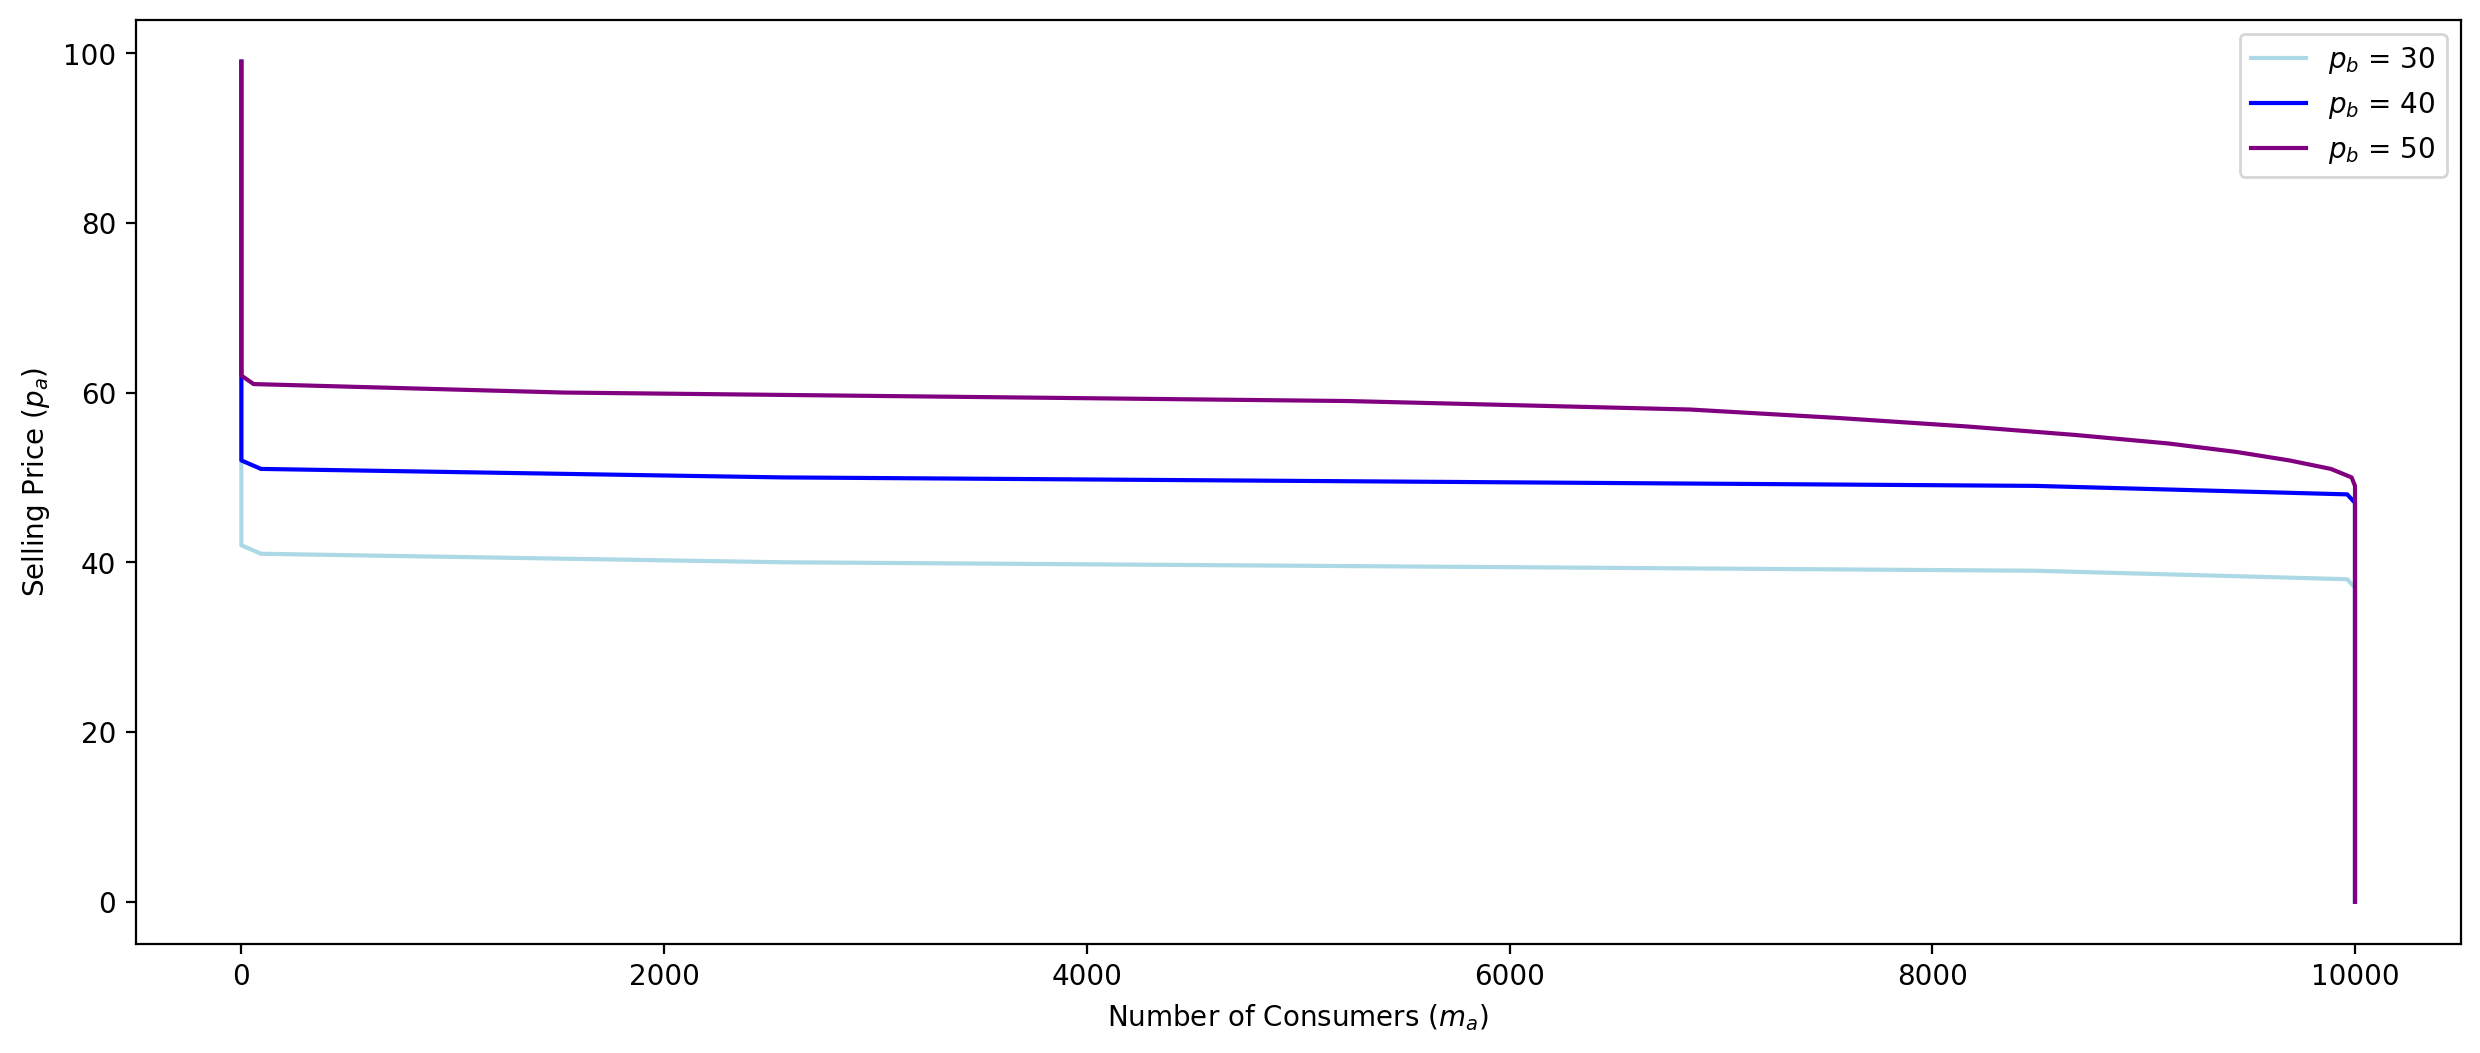

In [ ]:
plt.figure(figsize = [15,6], dpi = 200)
plt.plot(quantities02,range(100),'lightblue')
plt.plot(quantities,range(100),'blue')
plt.plot(quantities03,range(100),'purple')
plt.xlabel("Number of Consumers ($m_a$)")
plt.ylabel("Selling Price ($p_a$)")
plt.legend(['$p_b$ = 30', '$p_b$ = 40', '$p_b$ = 50'])
plt.show()

## Results under different conditions

### Different prices

In [ ]:
## Results

parameter_names = ['fair value of raw data',
                   'data restriction',
                   'license value','cost of contract',
                   'price of product', 'alpha', 'quality of product',
                   'utility constant', 'average utility',
                   'orders', 'profits']

# Parameters

# prices
price_s_a = 50
price_s_b = 40

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  # utili_a.append(DVC.util(u_bar_a, s[i], theta_1, price_s_a))
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

buy = []
buy2= []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [p_0_a, c_res_a, p_lic_a, c_0_a, price_s_a, alpha_a,
                           theta_1_value_a, u_bar_a, round(np.mean(utili_a),2),
                           m1, pr1]
parameter_values_list_b = [p_0_b, c_res_b, p_lic_b, c_0_b, price_s_b, alpha_b,
                           theta_1_value_b, u_bar_b, round(np.mean(utili_b),2),
                           m2, pr2]
Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})
Table_param

Parameters and Outcomes  Region A  Region B
0   fair value of raw data      10.0      10.0
1         data restriction       5.0       5.0
2            license value       4.0       4.0
3         cost of contract       6.0       6.0
4         price of product      50.0      40.0
5                    alpha    2000.0    2000.0
6       quality of product      12.8      12.8
7         utility constant     100.0     100.0
8          average utility      56.4      66.4
9                   orders       0.0   10000.0
10                 profits  -24000.0  326000.0

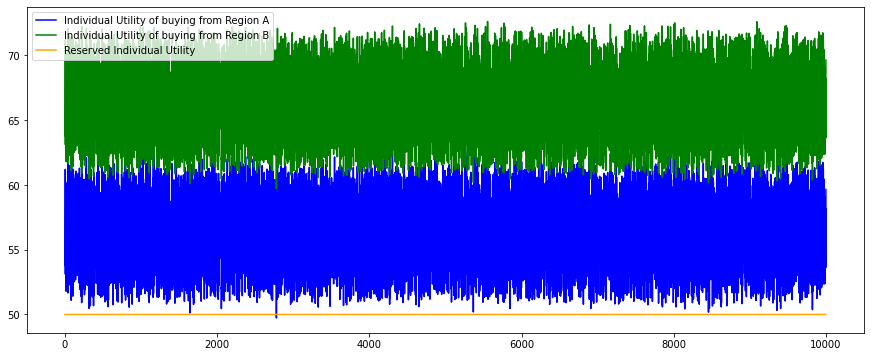

In [ ]:
plt.figure(figsize = [15,6])
plt.plot(utili_a,'blue')
plt.plot(utili_b,'green')
plt.plot(ru,'orange')
plt.legend(['Individual Utility of buying from Region A',
            'Individual Utility of buying from Region B',
            'Reserved Individual Utility'])
plt.show()

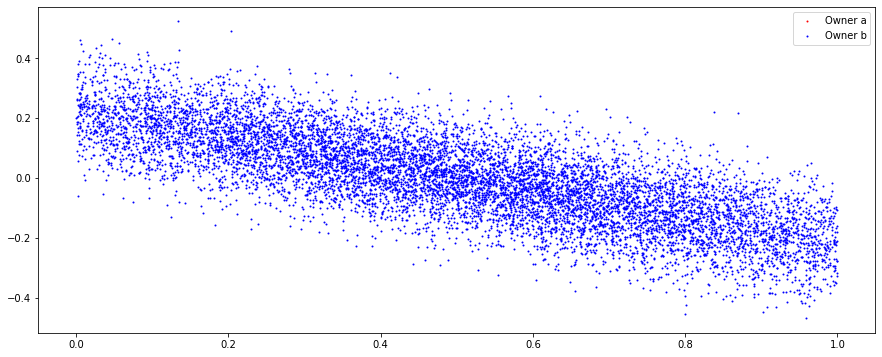

In [ ]:
# plot the points

set_A_x = []
set_A_y = []
set_B_x = []
set_B_y = []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      set_A_x.append(s[i])
      set_A_y.append(st_R[i])
    elif utili_a[i] < utili_b[i]:
      set_B_x.append(s[i])
      set_B_y.append(st_R[i])
    else:
      if bin[i] == 1:
        set_A_x.append(s[i])
        set_A_y.append(st_R[i])
      else:
        set_B_x.append(s[i])
        set_B_y.append(st_R[i])
  else:
    pass

plt.figure(figsize = [15,6])
plt.plot()
plt.scatter(set_A_x, set_A_y, c = 'red', s = 1)
plt.scatter(set_B_x, set_B_y, c = 'blue',  s = 1)
plt.legend(['Owner a', 'Owner b'])
plt.show()

### Different prices and different restriction costs

In [ ]:
## Results

# policy factor: data restriction
c_res_a = 25
c_res_b = 5

# prices
price_s_a = 50
price_s_b = 40

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

buy = []
buy2= []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [p_0_a, c_res_a, p_lic_a, c_0_a, price_s_a, alpha_a,
                           theta_1_value_a, u_bar_a, round(np.mean(utili_a),2),
                           m1, pr1]
parameter_values_list_b = [p_0_b, c_res_b, p_lic_b, c_0_b, price_s_b, alpha_b,
                           theta_1_value_b, u_bar_b, round(np.mean(utili_b),2),
                           m2, pr2]
Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})
Table_param

Parameters and Outcomes  Region A  Region B
0   fair value of raw data     10.00      10.0
1         data restriction     25.00       5.0
2            license value      4.00       4.0
3         cost of contract      6.00       6.0
4         price of product     50.00      40.0
5                    alpha   2000.00    2000.0
6       quality of product     12.80      12.8
7         utility constant    100.00     100.0
8          average utility     56.41      66.4
9                   orders      1.00    9999.0
10                 profits -23975.00  325965.0

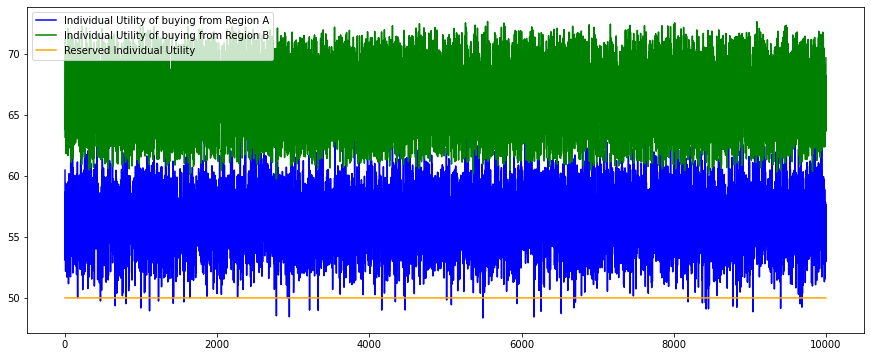

In [ ]:
plt.figure(figsize = [15,6])
plt.plot(utili_a,'blue')
plt.plot(utili_b,'green')
plt.plot(ru,'orange')
plt.legend(['Individual Utility of buying from Region A',
            'Individual Utility of buying from Region B',
            'Reserved Individual Utility'])
plt.show()

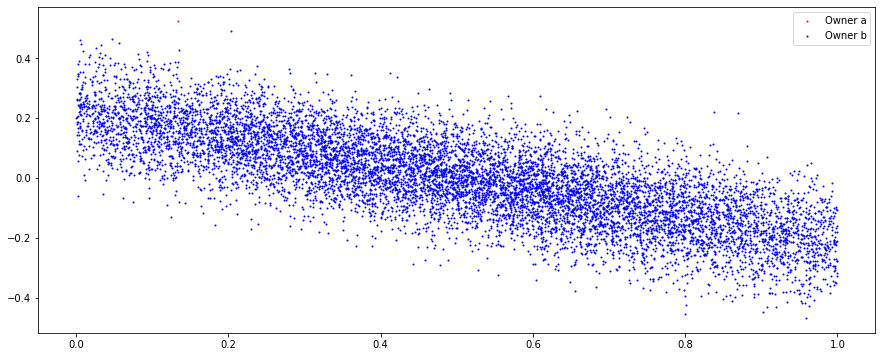

In [ ]:
# plot the points

set_A_x = []
set_A_y = []
set_B_x = []
set_B_y = []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      set_A_x.append(s[i])
      set_A_y.append(st_R[i])
    elif utili_a[i] < utili_b[i]:
      set_B_x.append(s[i])
      set_B_y.append(st_R[i])
    else:
      if bin[i] == 1:
        set_A_x.append(s[i])
        set_A_y.append(st_R[i])
      else:
        set_B_x.append(s[i])
        set_B_y.append(st_R[i])
  else:
    pass

plt.figure(figsize = [15,6])
plt.plot()
plt.scatter(set_A_x, set_A_y, c = 'red', s = 1)
plt.scatter(set_B_x, set_B_y, c = 'blue',  s = 1)
plt.legend(['Owner a', 'Owner b'])
plt.show()

### Different prices and different functionalities

In [ ]:
## Results

# policy factor: data restriction
c_res_a = 5
c_res_b = 5

# cost of contract
c_0_a = 12 # adjust the cost to raise the functionality
c_0_b = 6

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# prices
price_s_a = 50
price_s_b = 40

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

buy = []
buy2= []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [p_0_a, c_res_a, p_lic_a, c_0_a, price_s_a, alpha_a,
                           theta_1_value_a, u_bar_a, round(np.mean(utili_a),2),
                           m1, pr1]
parameter_values_list_b = [p_0_b, c_res_b, p_lic_b, c_0_b, price_s_b, alpha_b,
                           theta_1_value_b, u_bar_b, round(np.mean(utili_b),2),
                           m2, pr2]
Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})
Table_param

Parameters and Outcomes  Region A  Region B
0   fair value of raw data      10.0      10.0
1         data restriction       5.0       5.0
2            license value       4.0       4.0
3         cost of contract      12.0       6.0
4         price of product      50.0      40.0
5                    alpha    2000.0    2000.0
6       quality of product      24.8      12.8
7         utility constant     100.0     100.0
8          average utility      62.4      66.4
9                   orders    1244.0    8756.0
10                 profits    7980.0  282460.0

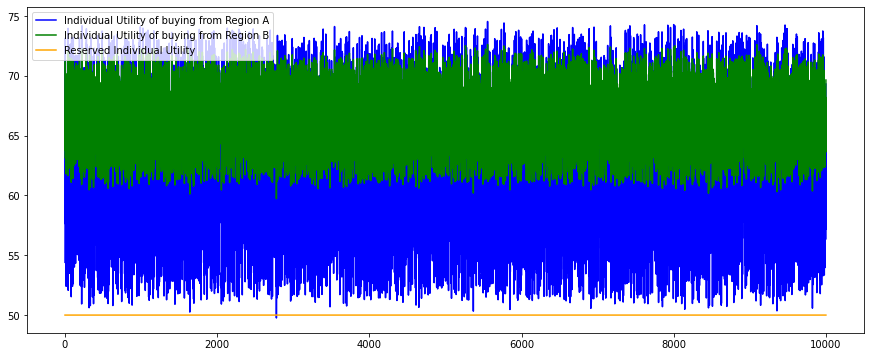

In [ ]:
plt.figure(figsize = [15,6])
plt.plot(utili_a,'blue')
plt.plot(utili_b,'green')
plt.plot(ru,'orange')
plt.legend(['Individual Utility of buying from Region A',
            'Individual Utility of buying from Region B',
            'Reserved Individual Utility'])
plt.show()

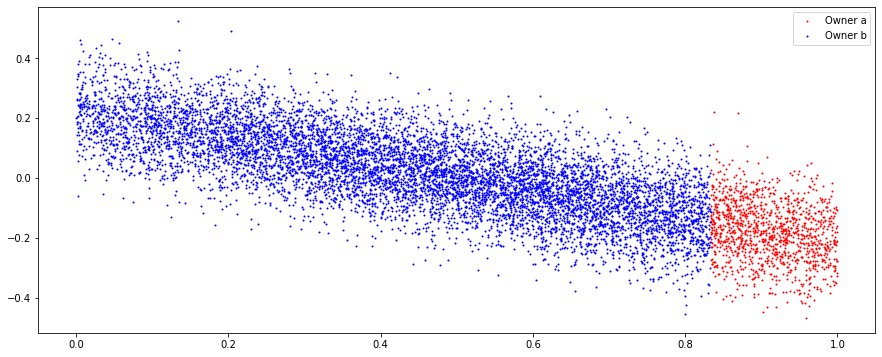

In [ ]:
# plot the points

set_A_x = []
set_A_y = []
set_B_x = []
set_B_y = []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      set_A_x.append(s[i])
      set_A_y.append(st_R[i])
    elif utili_a[i] < utili_b[i]:
      set_B_x.append(s[i])
      set_B_y.append(st_R[i])
    else:
      if bin[i] == 1:
        set_A_x.append(s[i])
        set_A_y.append(st_R[i])
      else:
        set_B_x.append(s[i])
        set_B_y.append(st_R[i])
  else:
    pass

plt.figure(figsize = [15,6])
plt.plot()
plt.scatter(set_A_x, set_A_y, c = 'red', s = 1)
plt.scatter(set_B_x, set_B_y, c = 'blue',  s = 1)
plt.legend(['Owner a', 'Owner b'])
plt.show()

### Different prices, restrictions, and functionalities

In [ ]:
## Results

parameter_names = [
    # 'fair value of raw data',
                   'data restriction level',
                  #  'license value',
                   'cost of contract',
                   'price of product',
                  #  'alpha',
                   'quality of product',
                   'utility constant', 'average utility',
                   'orders', 'profits']

# Parameters
# policy factor: data restriction
c_res_a = 25.0
c_res_b = 5.0

# cost of contract
c_0_a = 70
c_0_b = 60

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# prices
price_s_a = 50
price_s_b = 40

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

buy = []
buy2= []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [c_res_a, c_0_a, price_s_a,
                           theta_1_value_a, u_bar_a, round(np.mean(utili_a),2),
                           m1, pr1]
parameter_values_list_b = [c_res_b, c_0_b, price_s_b,
                           theta_1_value_b, u_bar_b, round(np.mean(utili_b),2),
                           m2, pr2]
Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})
Table_param

Parameters and Outcomes   Region A   Region B
0  data restriction level      25.00       5.00
1        cost of contract      70.00      60.00
2        price of product      50.00      40.00
3      quality of product     140.80     120.80
4        utility constant     100.00     100.00
5         average utility     121.09     120.76
6                  orders    5092.00    4908.00
7                 profits  127160.00  171660.00

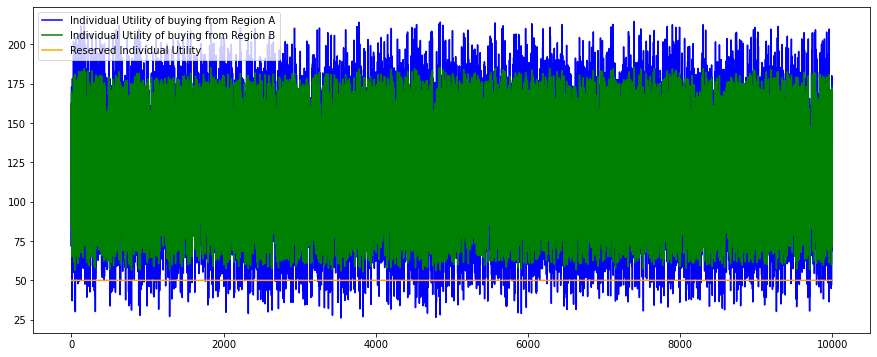

In [ ]:
plt.figure(figsize = [15,6])
plt.plot(utili_a,'blue')
plt.plot(utili_b,'green')
plt.plot(ru,'orange')
plt.legend(['Individual Utility of buying from Region A',
            'Individual Utility of buying from Region B',
            'Reserved Individual Utility'])
plt.show()

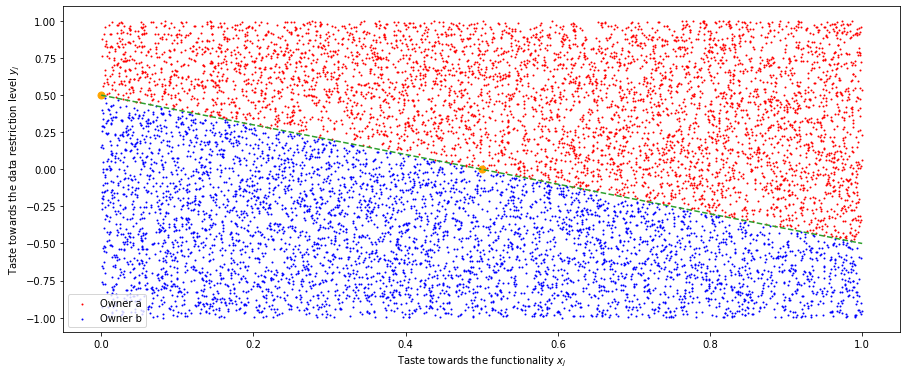

In [ ]:
# plot the points

set_A_x = []
set_A_y = []
set_B_x = []
set_B_y = []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      set_A_x.append(s[i])
      set_A_y.append(st_R[i])
    elif utili_a[i] < utili_b[i]:
      set_B_x.append(s[i])
      set_B_y.append(st_R[i])
    else:
      if bin[i] == 1:
        set_A_x.append(s[i])
        set_A_y.append(st_R[i])
      else:
        set_B_x.append(s[i])
        set_B_y.append(st_R[i])
  else:
    pass

delta_p = price_s_a - price_s_b
delta_res = c_res_a - c_res_b
delta_fun = theta_1_value_a - theta_1_value_b
crit1 = delta_p/delta_res
crit2 = delta_p/delta_fun
slope = -delta_fun/delta_res
incet = delta_p/delta_res
valuesx = np.linspace(0,1,100)
valuesy = valuesx * slope + incet

plt.figure(figsize = [15,6])
plt.plot()
plt.scatter(set_A_x, set_A_y, c = 'red', s = 1)
plt.scatter(set_B_x, set_B_y, c = 'blue',  s = 1)
plt.legend(['Owner a', 'Owner b'])
plt.plot(0, crit1, marker="o", markersize=7, markeredgecolor="orange",
         markerfacecolor="orange")
plt.plot(crit2, 0, marker="o", markersize=7, markeredgecolor="orange",
         markerfacecolor="orange")
plt.plot(valuesx, valuesy, '--')
plt.xlabel("Taste towards the functionality $x_j$")
plt.ylabel("Taste towards the data restriction level $y_j$")

# pts_df = pd.DataFrame({'Taste towards functionality $x_j$': s,
#                        'Taste towards data restrictions $y_j$': st_R})
# sns.jointplot(data = pts_df, x = "Taste towards functionality $x_j$",
#                              y = "Taste towards data restrictions $y_j$",
#                              height = 12)

plt.show()

Initial state: When x and y are highly correlated, the points of the plane are on a straight line (setting both of the random seeds as 123). When x and y are not correlated at all (setting random seeds 1 and 2), the points can be anywhere (customers are totally indifferent).

## Profit Grids in different scenarios

Price Grid

In [ ]:
# Parameters
# policy factor: data restriction
c_res_a = 5
c_res_b = 5

# cost of contract
c_0_a = 6 # adjust the cost to raise the functionality
c_0_b = 6

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# prices
profit_a_set = []
profit_b_set = []
total_pr_set = []

for pricea00 in range(0, 100, 5):
  for priceb01 in range(0, 100, 5):
    price_s_a = pricea00
    price_s_b = priceb01

    # number of customers
    n_customers = 10000

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
    total_pr = pr1 + pr2

    profit_a_set.append(pr1)
    profit_b_set.append(pr2)
    total_pr_set.append(total_pr)

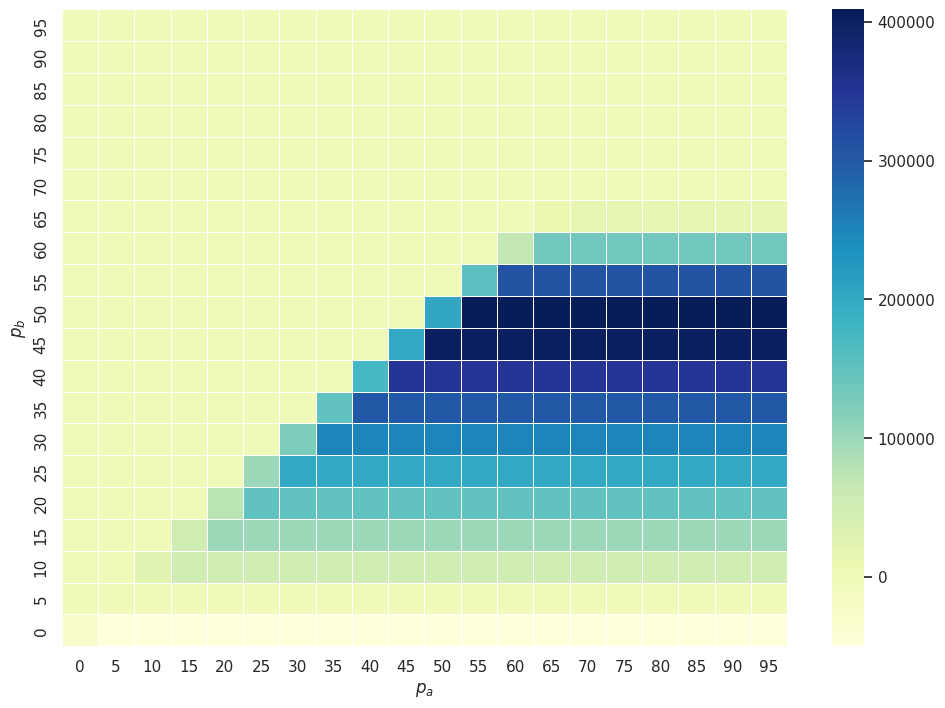

In [ ]:
price_b_000 = list(range(0, 100, 5)) * 20 # inside, b
price_a_000 = np.repeat(list(range(0, 100, 5)), len(list(range(0, 100, 5)))).tolist() # outside, a
heatmap01t = pd.DataFrame({'Price_a': price_a_000, 'Price_b': price_b_000,
              'Profit_a': profit_a_set, 'Profit_b': profit_b_set})
heatmap01 = heatmap01t.pivot("Price_b", "Price_a", "Profit_b") # , "Profit_b"
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(heatmap01, cmap="YlGnBu", linewidths=.5) # annot = 'True, fmt="d"
ax.invert_yaxis()
ax.set_xlabel("$p_a$")
ax.set_ylabel("$p_b$")

# ax = sns.heatmap(heatmap01, cmap="YlGnBu", linewidths=.5, xticklabels=True,
#             yticklabels=True, cbar=False) # annot = 'True, fmt="d"

plt.show()

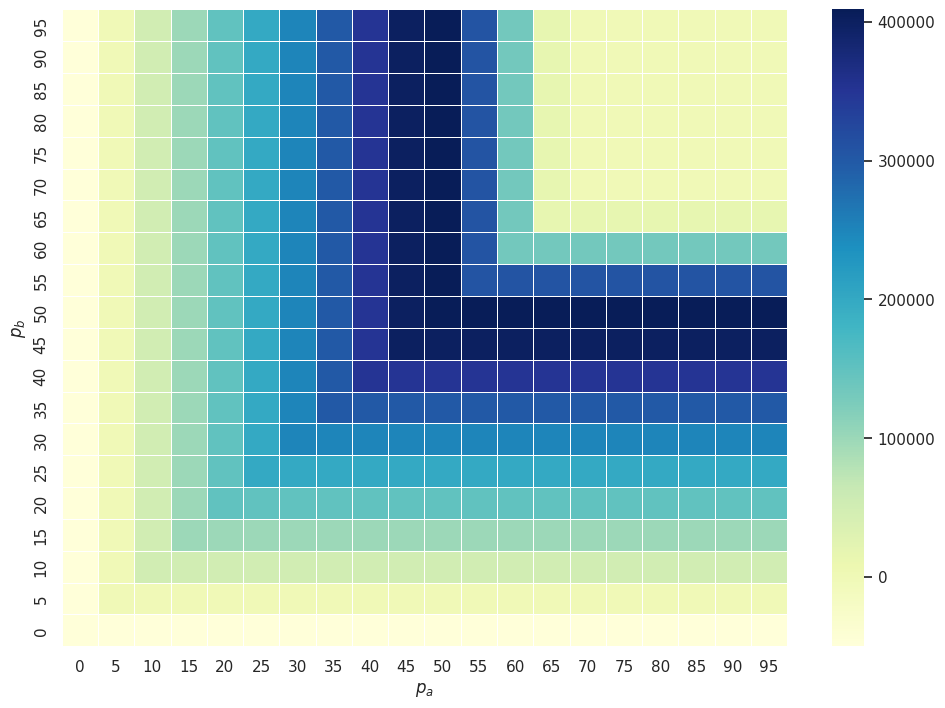

In [ ]:
price_b_000 = list(range(0, 100, 5)) * 20 # inside, b
price_a_000 = np.repeat(list(range(0, 100, 5)), len(list(range(0, 100, 5)))).tolist() # outside, a
heatmap01t = pd.DataFrame({'Price_a': price_a_000, 'Price_b': price_b_000,
              'Profit_total': total_pr_set})
heatmap01 = heatmap01t.pivot("Price_b", "Price_a", "Profit_total")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(heatmap01, cmap="YlGnBu", linewidths=.5) # annot = 'True, fmt="d"
ax.invert_yaxis()
ax.set_xlabel("$p_a$")
ax.set_ylabel("$p_b$")
plt.show()

Price Grid - Variations under Scenarios 1-6

In [ ]:
# policy factor: data restriction # small changes
c_res_a = 5  # partial: 5, 5,  15 ## inte: 5,  15, 5, 15
c_res_b = 15 # partial: 8, 15, 15 ## inte: 15, 5, 15,  5

# cost of contract
c_0_a = 200  # partial: 6, 6, 20 ## inte: 6,  6, 20, 20
c_0_b = 60 # partial: 8, 20, 20 ## inte: 20, 20, 6, 6

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# prices
profit_a_set = []
profit_b_set = []
total_pr_set = []

for pricea00 in range(0, 200, 5): # (0, 100, 5), (0, 500, 5)
  for priceb01 in range(0, 200, 5): # (0, 100, 5), (0, 500, 5)
    price_s_a = pricea00
    price_s_b = priceb01

    # number of customers
    n_customers = 10000

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
    total_pr = pr1 + pr2

    profit_a_set.append(pr1)
    profit_b_set.append(pr2)
    total_pr_set.append(total_pr)

In [ ]:
len(profit_a_set)

1600

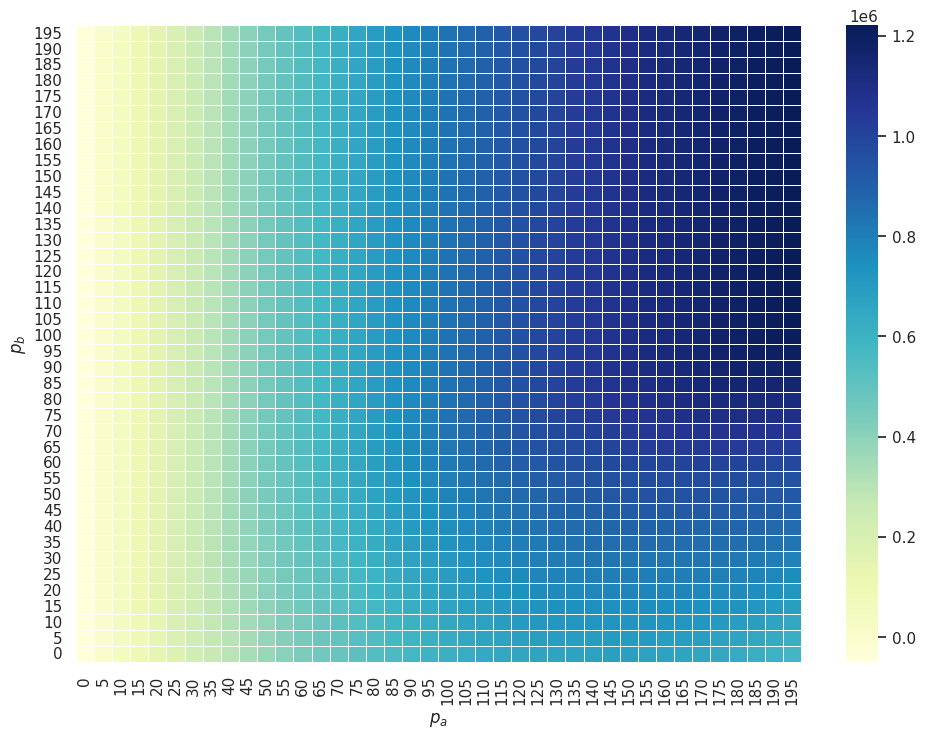

In [ ]:
# price_b_000 = list(range(0, 500, 5)) * 100 # inside, b # (0, 100, 5), * 20
price_b_000 = list(range(0, 200, 5)) * 40
price_a_000 = np.repeat(list(range(0, 200, 5)), len(list(range(0, 200, 5)))).tolist() # outside, a
heatmap01t = pd.DataFrame({'Price_a': price_a_000, 'Price_b': price_b_000,
              'Profit_a': profit_a_set})
heatmap01 = heatmap01t.pivot("Price_b", "Price_a", "Profit_a")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(heatmap01, cmap="YlGnBu", linewidths=.5) # annot = 'True, fmt="d"
ax.invert_yaxis()
ax.set_xlabel("$p_a$")
ax.set_ylabel("$p_b$")
plt.show()

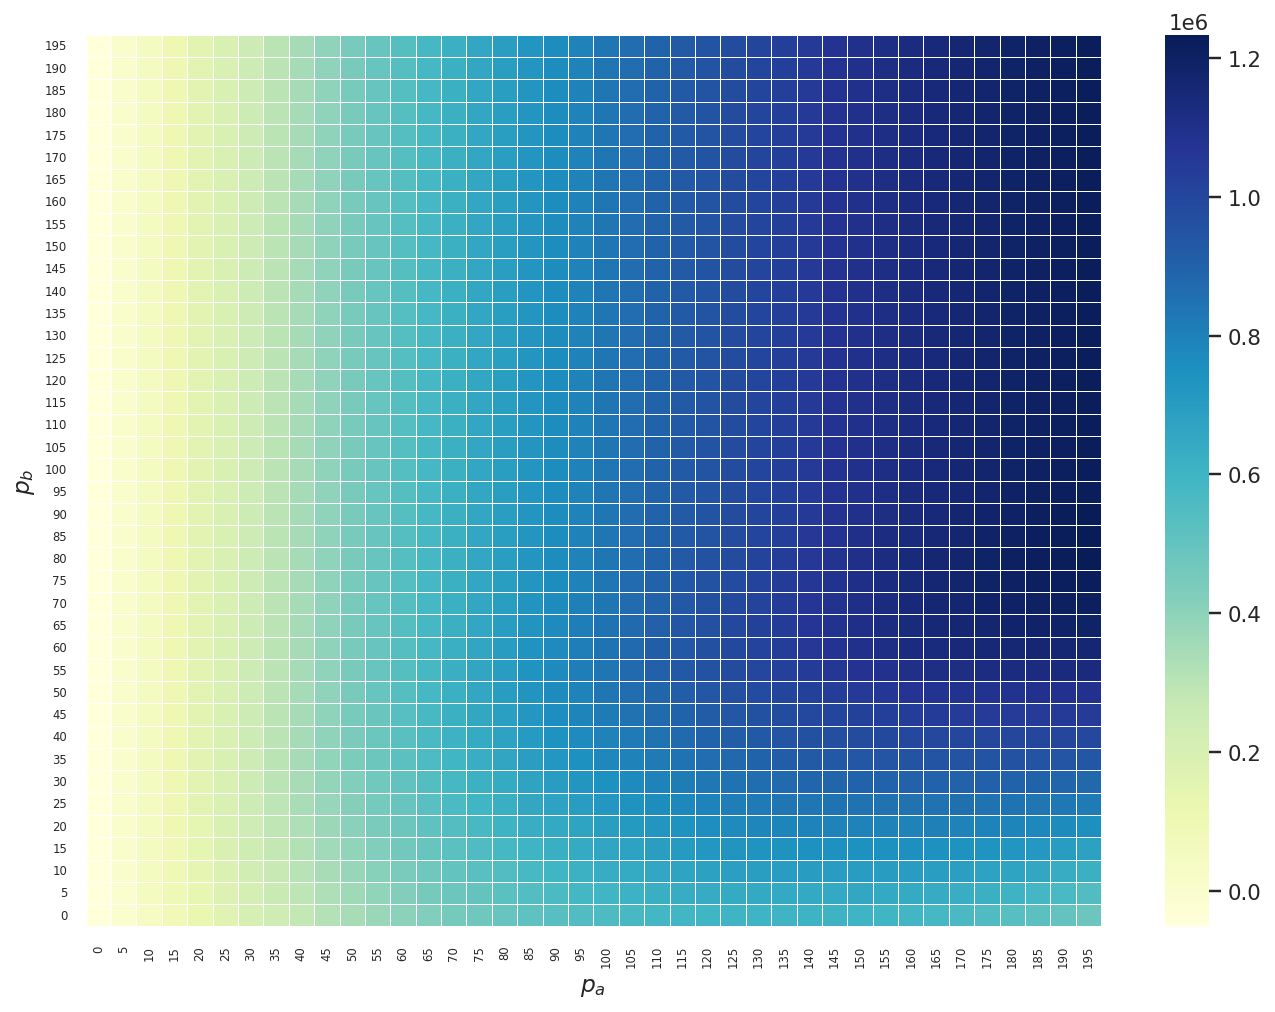

In [ ]:
price_b_000 = list(range(0, 200, 5)) * 40
price_a_000 = np.repeat(list(range(0, 200, 5)), len(list(range(0, 200, 5)))).tolist() # outside, a
heatmap01t = pd.DataFrame({'Price_a': price_a_000, 'Price_b': price_b_000,
              'Profit_total': total_pr_set})
heatmap01 = heatmap01t.pivot("Price_b", "Price_a", "Profit_total")

plt.figure(dpi=140)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(heatmap01, cmap="YlGnBu", linewidths=.5) # annot = 'True, fmt="d"
ax.invert_yaxis()
ax.set_xlabel("$p_a$")
ax.set_ylabel("$p_b$")
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
plt.show()

## Welfare Grids in different Scenarios

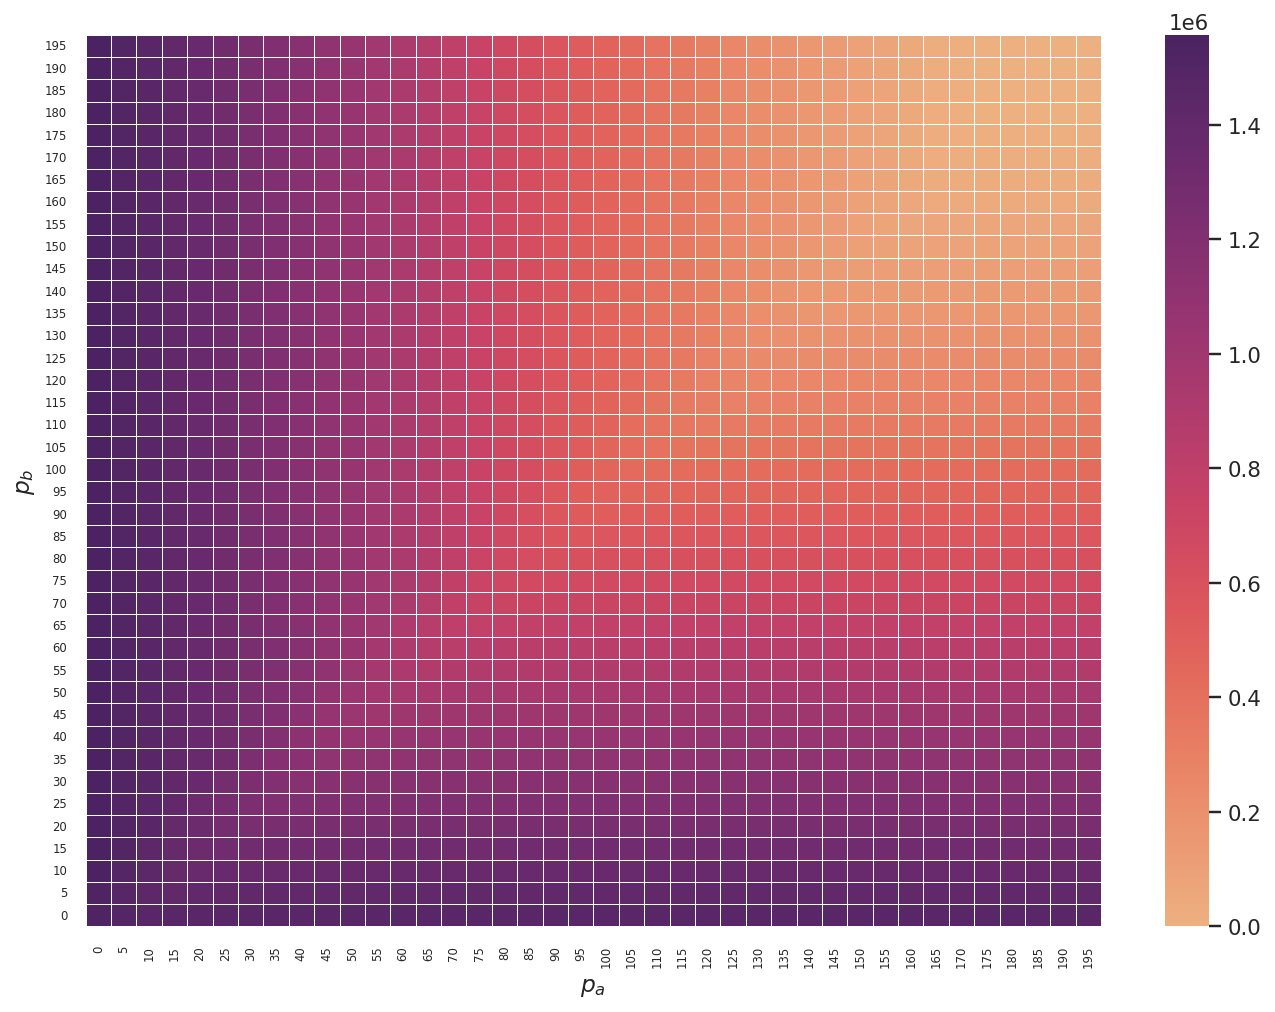

In [ ]:
# cost of contract
c_0_a = 60  # partial: 6, 6, 20 ## inte: 6,  6, 20, 20
c_0_b = 60 # partial: 8, 20, 20 ## inte: 20, 20, 6, 6

# policy factor: data restriction # small changes
c_res_a = 5  # partial: 5, 5,  15 ## inte: 5,  15, 5, 15
c_res_b = 15 # partial: 8, 15, 15 ## inte: 15, 5, 15,  5

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# prices
profit_a_set = []
profit_b_set = []
total_pr_set = []
welfare_set = []

for pricea00 in range(0, 200, 5): # 100
  for priceb01 in range(0, 200, 5):
    price_s_a = pricea00
    price_s_b = priceb01

    # number of customers
    n_customers = 10000

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2 = []
    welf = []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
          welf.append(utili_a[i])
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
          welf.append(utili_b[i])
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
          welf.append(utili_a[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
    # total_pr = pr1 + pr2
    agg_total_cost = (deltap_a(c_0_a) + m1 * c_res_a
                      + deltap_a(c_0_b)
                      + m2 * c_res_b)
    agg_welfare = sum(welf) - agg_total_cost


    profit_a_set.append(pr1)
    profit_b_set.append(pr2)
    total_pr_set.append(total_pr)
    welfare_set.append(agg_welfare)


price_b_000 = list(range(0, 200, 5)) * 40 # inside, b
price_a_000 = np.repeat(list(range(0, 200, 5)), len(list(range(0, 200, 5)))).tolist() # outside, a
heatmap01t = pd.DataFrame({'Price_a': price_a_000, 'Price_b': price_b_000,
              'Global Welfare': welfare_set})
heatmap01 = heatmap01t.pivot("Price_b", "Price_a", "Global Welfare")

plt.figure(dpi=140)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(heatmap01, cmap="flare", linewidths=.5) # annot = 'True, fmt="d"
ax.invert_yaxis()
ax.set_xlabel("$p_a$")
ax.set_ylabel("$p_b$")
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
plt.show()

## Best response curves

What would the best responses of firm $b$ be if firm $a$ changes the prices?

### Symmetric companies: Standard Bertrand Duopoly (companies move simultaneously)

Grid of investment values and the optimal prices under certain regulations.

Example 1: Same data restriction

In [ ]:
# policy factor: data restriction
c_res_a = 2
c_res_b = 2

In [ ]:
# scale alpha
alpha_a = 2000 # thinking about the final payment to the Developers
alpha_b = 2000

# cost of contract: axes of the grid
# c_0_a = 6 # adjust the cost to raise the functionality
# c_0_b = 6

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# prices
price_s_a = 10
price_s_b = 10

# pricelist1 = []
# maxpricelist1 = []

# number of customers
n_customers = 10000

In [ ]:
# reserved utility
ru # each is equivalent#

array([50., 50., 50., ..., 50., 50., 50.])

In [ ]:
(price_s_a, price_s_b)

(10, 10)

In [ ]:
c_0_b = 20

Under certain restrictions

In [ ]:
c_res_a = 4; c_res_b = 2

In [ ]:
c_res_a, c_res_b

(4, 2)

In [ ]:
# profit_list_001 = []
# profit_index_list = []

In [ ]:
c_0_a = 0  # adjust: 0, 10, 20, ...
# c_0_b = 0 # adjust: 0, 10, 20, ...

price_s_a = 0 # adjust: 0, 10, 20, ...
# for price_s_a in range(0, 100, 10):

profit_list_001 = []
profit_index_list = []
grid_col_1 = []
grid_col_all = []

for c_0_a in range(0, 100, 5):

    for c_0_b in range(0, 100, 5):

        for price_s_a in range(0, 100, 10):
            for price_s_b in range(0, 100, 10):
                buy = []; buy2 = [] # check the decisions of the customers
                utili_a = []; utili_b = [] # list of utilities
                for i in range(0, n_customers):
                    utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
                    utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))
                for i in range(0, n_customers):
                    if ru[i] <= max(utili_a[i], utili_b[i]):
                        if utili_a[i] > utili_b[i]:
                          buy.append(1)
                        elif utili_a[i] < utili_b[i]:
                          buy2.append(1)
                        else:
                          buy.append(bin[i])
                          buy2.append(1-bin[i])
                    else:
                        pass
                m1 = sum(buy); m2 = sum(buy2)
                pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
                profit_list_001.append(pr1)
            profit_index_list.append(np.mean(profit_list_001))

        # profit_index = list(range(0, 100, 10))
        # grid_col_1.append(profit_index[np.argmax(profit_index_list)])

        # grid_col_1.append(np.max(profit_index_list)) # why same values?
        grid_col_1.append(np.mean(profit_index_list)) # mean values are different.

    # grid_col_all.append(grid_col_1)

# profit_index = list(range(0, 100, 10))
# profit_index[np.argmax(profit_list_001)]
# profit_index_list.append(profit_index[np.argmax(profit_list_001)])
# profit_index_list
# grid_col_1

In [ ]:
len(grid_col_1)

400

In [ ]:
# grid_col_all[0] == grid_col_all[1]

In [ ]:
# grid_col_all[0] == grid_col_all[2]

In [ ]:
# grid_col_all[0] == grid_col_1

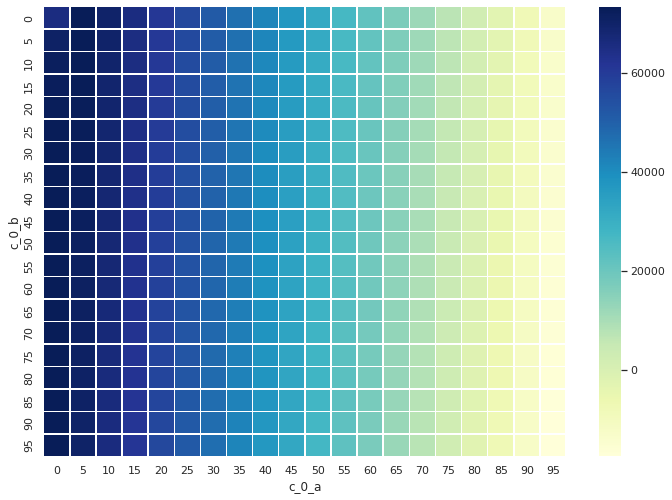

In [ ]:
c_0_b_000 = list(range(0, 100, 5)) * 20 # inside, b
c_0_a_000 = np.repeat(list(range(0, 100, 5)), len(list(range(0, 100, 5)))).tolist() # outside, a

# heatmap01t = pd.DataFrame({'c_0_a': c_0_a_000, 'c_0_b': c_0_b_000,
#               'Profit_a': grid_col_all[0]})

heatmap01t = pd.DataFrame({'c_0_a': c_0_a_000, 'c_0_b': c_0_b_000,
              'Profit_a': grid_col_1})


heatmap01 = heatmap01t.pivot("c_0_b", "c_0_a", "Profit_a")

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(heatmap01, cmap="YlGnBu", linewidths=.5) # annot = 'True, fmt="d"
plt.show()

In [ ]:
# Under a certain price_s_b
price_s_b = 20

# Adjust price_s_a
price_s_a = 10

c_0_a = 0
price_list = []; profit_list = []

for c_0_a in range(0, 100, 10):
    for price_s_a in range(0, 50, 1):
        for price_s_b in range(0, 50, 1):
            buy = []; buy2 = [] # check the decisions of the customers
            utili_a = []; utili_b = [] # list of utilities

            for i in range(0, n_customers):
                utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
                utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))
            for i in range(0, n_customers):
                if ru[i] <= max(utili_a[i], utili_b[i]):
                    if utili_a[i] > utili_b[i]:
                      buy.append(1)
                    elif utili_a[i] < utili_b[i]:
                      buy2.append(1)
                    else:
                      buy.append(bin[i])
                      buy2.append(1-bin[i])
                else:
                    pass

            m1 = sum(buy); m2 = sum(buy2)
            pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
            profit_list.append(pr1)

            # profit_list[0:50]


        # df_profit_a = pd.DataFrame({'price_a': list(range(0, 50, 5)),
                      # 'profit_a': profit_list})
        # df_profit_a[df_profit_a['profit_a'] == np.max(df_profit_a['profit_a'])]

        # price_list.append(np.max(profit_list))

In [ ]:
price_list = []
profit_index = list(range(0, 50, 1))
for i in range(0, 10):
    price_list.append(profit_index[np.argmax(profit_list[i*50 : (i+1)*50])]) # , axis=1

In [ ]:
price_list

[0, 0, 0, 0, 0, 6, 7, 8, 9, 10]

In [ ]:
c_0_b

20

In [ ]:
len(profit_list)

500

In [ ]:
pd.DataFrame({'c_0_a': list(range(0, 100, 10)), 'price_a': price_list})

c_0_a  price_a
0      0       19
1     10       19
2     20       19
3     30       19
4     40       19
5     50       19
6     60       19
7     70       19
8     80       19
9     90       19

In [ ]:
pr1

65352

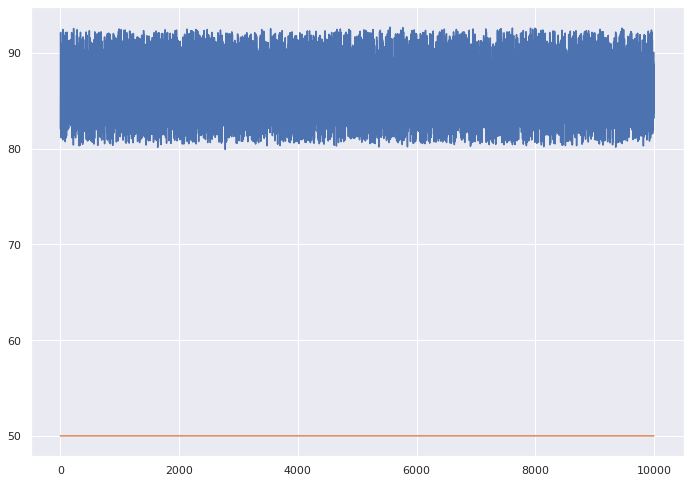

In [ ]:
plt.plot(utili_a)
plt.plot(ru)
plt.show()

Check the 1st round BR for one company.

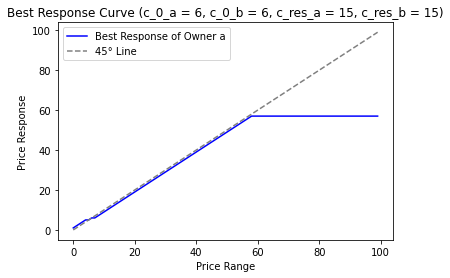

In [ ]:
# Parameters
# fair value of raw data
# p_0_a = 10
# p_0_b = 10

# policy factor: data restriction
c_res_a = 5
c_res_b = 5

# Variables
# license
# p_lic_a = 4
# p_lic_b = 4

# scale alpha
# alpha_a = 2000 # thinking about the final payment to the Developers
# alpha_b = 2000

# cost of contract
c_0_a = 20 # adjust the cost to raise the functionality
c_0_b = 20

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# prices
# price_s_a = 40
price_s_b = 40

pricelist1 = []
maxpricelist1 = []

# number of customers
n_customers = 10000


# Get the optimal price
for jj in range(0, 100, 1):
  price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  maxpricelist1.append(range(0, 100, 1)[indx])

plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
plt.legend(['Best Response of Owner a','45° Line'])
plt.xlabel('Price Range')
plt.ylabel('Price Response')
plt.show() # vertical axis: a's BR price under the price of b

The same for the other firm.

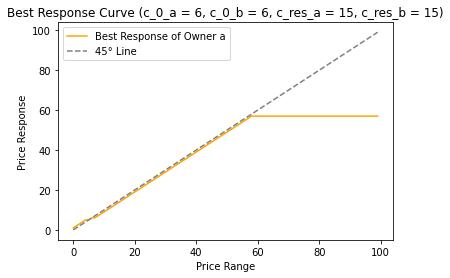

In [ ]:
# Keeping the parameters the same

# prices
price_s_a = 40
# price_s_b = 40

pricelist1 = []
# maxpricelist1 = []
maxpricelist2 = []

# number of customers
n_customers = 10000


# Get the optimal price
for jj in range(0, 100, 1):
  price_s_a = jj
  # price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    # price_s_a = ii
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []

    # pricelist1.append(pr1)
    pricelist1.append(pr2)


    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  # maxpricelist1.append(range(0, 100, 1)[indx])
  maxpricelist2.append(range(0, 100, 1)[indx])


plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
plt.plot(range(0, 100, 1), maxpricelist2, color = 'orange')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
plt.legend(['Best Response of Owner a','45° Line'])
plt.xlabel('Price Range')
plt.ylabel('Price Response')
plt.show()

Now we put the BR curves into one graph. Under this scenario, the equilibrium point should lie on the 45° line.

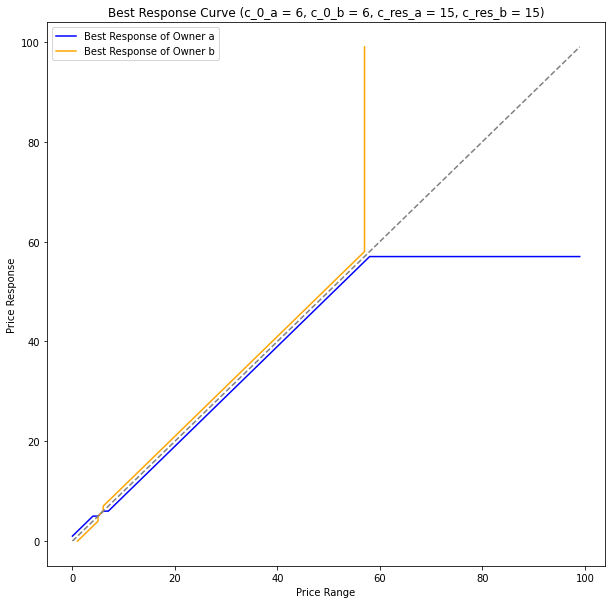

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
plt.plot(maxpricelist2, range(0, 100, 1), color = 'orange')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')

# plt.legend(['Best Response of Owner a','45° Line'])
plt.legend(['Best Response of Owner a','Best Response of Owner b'])

plt.xlabel('Price Range')
plt.ylabel('Price Response')
plt.show() # difference in two maxpricelists is the result of the Binomial dist.

In [ ]:
sum_table = pd.DataFrame({'maxpricelist1': maxpricelist1,
                         'maxpricelist2': maxpricelist2,
                         'price range': list(range(0, 100, 1))})
sum_table[sum_table['maxpricelist1'] == sum_table['price range']]

maxpricelist1  maxpricelist2  price range
5              5              5            5
6              6              6            6

## Equilibrium: Subgame perfect in multiple periods

In [ ]:
## Results

parameter_names = [# 'fair value of raw data', # not considered
                   'data restriction level', # $c_{res, i}$
                  #  'license value', # not considered
                   'cost of contract', # investment of the Owner $c_{0, i}$
                   'price of product', # $p_{s, i}$
                  #  'alpha', # constant incurred in the payment
                   'functionality of product', # $\theta_i$
                   'utility constant', # $\bar{u}_{j,i}$
                  #  'average utility', # may not be important
                   'number of purchase', # $m_i$
                   'total revenue', # $m_i p_{s, i}$
                   'total cost', # $c_{total,i}$
                   'profit'] # $\Pi_i$

# policy factor: data restriction
c_res_a = 5; c_res_b = 5

# cost of contract
c_0_a = 60; c_0_b = 200

# fundamental
theta_1_bar_a_value = 0.8; theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100; u_bar_b = 100

# prices
price_s_a = 16
price_s_b = 16

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

# reserved utility
ru = np.random.uniform(50, 50, n_customers) # homogenous

# buy randomly from one company if the utilities are the same
bin = np.random.binomial(1, 0.5, n_customers)

buy = []
buy2 = []
welf = []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
      welf.append(utili_a[i])
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
      welf.append(utili_b[i])
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
      welf.append(utili_a[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [#p_0_a,
                           c_res_a,
                          #  p_lic_a,
                           c_0_a,
                           price_s_a,
                          #  alpha_a,
                           theta_1_value_a,
                           u_bar_a,
                          #  round(np.mean(utili_a),2),
                           m1,
                           m1 * price_s_a,
                           deltap_a(c_0_a) + m1 * c_res_a,
                           pr1]
parameter_values_list_b = [#p_0_b,
                           c_res_b,
                          #  p_lic_b,
                           c_0_b, price_s_b,
                          #  alpha_b,
                           theta_1_value_b, u_bar_b,
                          #  round(np.mean(utili_b),2),
                           m2,
                           m2 * price_s_b,
                           deltap_a(c_0_b) + m2 * c_res_b,
                           pr2]

# Objective functions regarding the global welfare
agg_total_cost = deltap_a(c_0_a) + m1 * c_res_a + deltap_a(c_0_b) + m2 * c_res_b
agg_welfare = sum(welf) - agg_total_cost

Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})

print(f"Global welfare equals: {round(agg_welfare, 2)}")
print(f"Global profit equals: {round(pr1 + pr2, 2)}")
# Question: Are the global welfare and the global profit positively correlated?
# No, instead, they might be negatively correlated.
Table_param

Global welfare equals: 2803909.78
Global profit equals: 109480


Parameters and Outcomes  Region A  Region B
0    data restriction level       5.0       5.0
1          cost of contract      60.0     200.0
2          price of product      16.0      16.0
3  functionality of product     120.8     400.8
4          utility constant     100.0     100.0
5        number of purchase       0.0   10000.0
6             total revenue       0.0  160000.0
7                total cost     120.0   50400.0
8                    profit    -120.0  109600.0

Step 1: Find the equilibrium prices

In [ ]:
profit_a

<function __main__.profit_a(m, price_s_a, c_0_a, c_res_a)>

In [ ]:
# policy factor: data restriction
c_res_a = 5; c_res_b = 5

# cost of contract # strange picture. Check (6,20)
c_0_a = 60; c_0_b = 60

# fundamental
theta_1_bar_a_value = 0.8; theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100; u_bar_b = 100

pricelist1 = []
maxpricelist1 = []

# number of customers
n_customers = 10000

# Get the optimal price
for jj in range(0, 100, 1): # adjust the steps because of the increase in investments
  price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1): # (0, 1000, 10)
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2 = []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
    # pricelist1 = []
    pricelist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  maxpricelist1.append(range(0, 100, 1)[indx]) # (0, 1000, 10)

# Keeping the parameters the same

# prices
price_s_a = 40
# price_s_b = 40

pricelist2 = []
# maxpricelist1 = []
maxpricelist2 = []

# number of customers
n_customers = 10000


# Get the optimal price
for jj in range(0, 100, 1): # (0, 1000, 10)
  price_s_a = jj
  # price_s_b = jj
  pricelist2 = []
  for ii in range(0, 100, 1): # (0, 1000, 10)
    # price_s_a = ii
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2 = []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
    # pricelist1 = []

    # pricelist1.append(pr1)
    pricelist2.append(pr2)


    # Find which price could bring the maximum profit
  indx = np.where(pricelist2 == np.max(pricelist2))[0].tolist()[0]
  maxpricelist2.append(range(0, 100, 1)[indx])
  # maxpricelist2.append(range(0, 1000, 10)[indx]) # 16 min.

In [ ]:
len(pricelist2)

100

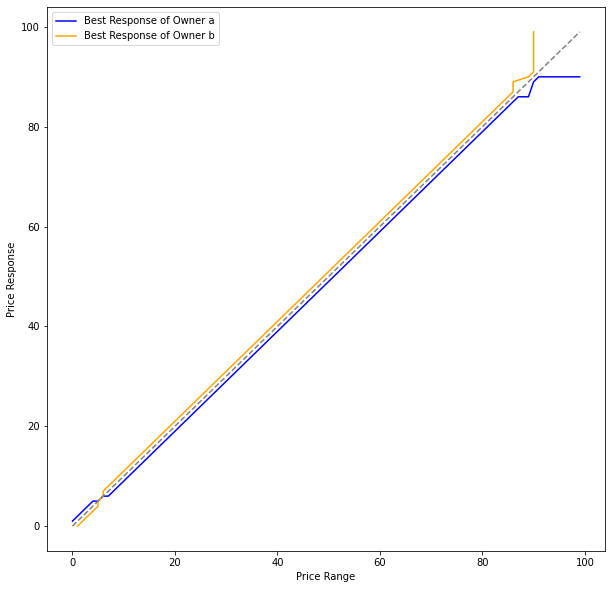

In [ ]:
plt.figure(figsize=(10,10))
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
# plt.plot(range(0, 1000, 10), maxpricelist1, color = 'blue')
# plt.plot(maxpricelist2, range(0, 1000, 10), color = 'orange')
# plt.plot(range(0, 1000, 10), range(0, 1000, 10), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
plt.plot(maxpricelist2, range(0, 100, 1), color = 'orange')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')

plt.legend(['Best Response of Owner a','Best Response of Owner b'])

plt.xlabel('Price Range')
plt.ylabel('Price Response')
plt.show() # difference in two maxpricelists is the result of the Binomial dist.

In [ ]:
# Show the equilibrium(-a) point(s)
sum_table = pd.DataFrame({'maxpricelist1': maxpricelist1,
                         'maxpricelist2': maxpricelist2,
                         'price range': list(range(0, 100, 1))}) # 0, 1000, 10
# sum_table[sum_table['maxpricelist1'] == sum_table['price range']]
# sum_table#[sum_table['maxpricelist1'] == sum_table['maxpricelist2']]
coordinates_blue  = []
coordinates_yellow = []
for i in range(0,len(sum_table)):
  coordinates_blue.append((sum_table["price range"][i], maxpricelist1[i]))
  coordinates_yellow.append((maxpricelist2[i], sum_table["price range"][i]))
sum_table2 = pd.DataFrame({"br1": coordinates_blue, "br2": coordinates_yellow})
# Find the intersection point(s): (firm b, firm a)
[i for i in sum_table2["br1"].tolist() if i in sum_table2["br2"].tolist()]

[(5, 5), (6, 6)]

In [ ]:
# Scenario 1
# New Price Equil1: [(5, 5), (6, 6)]

Step 2: Find the corresponding investments

In [ ]:
# (c_{0,a}, c_{0,b}) = (60, 60)
# (c_{res,a}, c_{res,b}) = (5, 5)
# (p_a*, p_b*) = (5，5)
# Symmetric: Just compute one of the investments.

In [ ]:
## Results

parameter_names = [# 'fair value of raw data', # not considered
                   'data restriction level', # $c_{res, i}$
                  #  'license value', # not considered
                   'cost of contract', # investment of the Owner $c_{0, i}$
                   'price of product', # $p_{s, i}$
                  #  'alpha', # constant incurred in the payment
                   'functionality of product', # $\theta_i$
                   'utility constant', # $\bar{u}_{j,i}$
                  #  'average utility', # may not be important
                   'number of purchase', # $m_i$
                   'total revenue', # $m_i p_{s, i}$
                   'total cost', # $c_{total,i}$
                   'profit'] # $\Pi_i$

                  #  [p_0_a, c_res_a, p_lic_a, c_0_a, price_s_a, alpha_a,
                  #          theta_1_value_a, u_bar_a, m1, pr1]

# Parameters
# fair value of raw data
# p_0_a = 10; p_0_b = 10

# policy factor: data restriction
c_res_a = 5; c_res_b = 5

# Variables
# license
# p_lic_a = 4; p_lic_b = 4

# scale alpha
# alpha_a = 2000 # thinking about the final payment to the Developers
# alpha_b = 2000

# cost of contract
c_0_a = 60 # adjust the cost to raise the functionality
c_0_b = 200

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# prices
price_s_a = 50
price_s_b = 160

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

# reserved utility
ru = np.random.uniform(50, 50, n_customers) # homogenous

# buy randomly from one company if the utilities are the same
bin = np.random.binomial(1, 0.5, n_customers)

buy = []
buy2 = []
welf = []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
      welf.append(utili_a[i])
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
      welf.append(utili_b[i])
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
      welf.append(utili_a[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [#p_0_a,
                           c_res_a,
                          #  p_lic_a,
                           c_0_a,
                           price_s_a,
                          #  alpha_a,
                           theta_1_value_a,
                           u_bar_a,
                          #  round(np.mean(utili_a),2),
                           m1,
                           m1 * price_s_a,
                           deltap_a(c_0_a) + m1 * c_res_a,
                           pr1]
parameter_values_list_b = [#p_0_b,
                           c_res_b,
                          #  p_lic_b,
                           c_0_b, price_s_b,
                          #  alpha_b,
                           theta_1_value_b, u_bar_b,
                          #  round(np.mean(utili_b),2),
                           m2,
                           m2 * price_s_b,
                           deltap_a(c_0_b) + m2 * c_res_b,
                           pr2]

# Objective functions regarding the global welfare
agg_total_cost = deltap_a(c_0_a) + m1 * c_res_a + deltap_a(c_0_b) + m2 * c_res_b
agg_welfare = sum(welf) - agg_total_cost

Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})

print(f"Global welfare equals: {round(agg_welfare, 2)}")
print(f"Global profit equals: {round(pr1 + pr2, 2)}")
# Question: Are the global welfare and the global profit positively correlated?
# No, instead, they might be negatively correlated.
Table_param

Global welfare equals: 1573053.36
Global profit equals: 1117160


Parameters and Outcomes  Region A  Region B
0    data restriction level       5.0       5.0
1          cost of contract      60.0     200.0
2          price of product      50.0     160.0
3  functionality of product     120.8     400.8
4          utility constant     100.0     100.0
5        number of purchase    3809.0    6105.0
6             total revenue  190450.0  976800.0
7                total cost   19165.0   30925.0
8                    profit  171285.0  945875.0

In [ ]:
# Method2: Check the profit under different investments
# policy factor: data restriction
c_res_a = 5; c_res_b = 5

# prices
price_s_a = 6
price_s_b = 6

# profit_list2 = []
profit_list2_list = []
# maxinvlist1 = []
# for i in range(0,1,2):
#   c_0_a = i
profit_list2 = []
c_0_a = 100
for j in range(0,1000,10): # 0,1000,10
  # cost of contract
  # c_0_a = i # adjust the cost to raise the functionality
  c_0_b = j

  # fundamental
  theta_1_bar_a_value = 0.8
  theta_1_bar_b_value = 0.8

  # functionality
  theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
  theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

  # utilities
  utili_a = []
  utili_b = []
  for i in range(0, n_customers):
    utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
    utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

  # reserved utility
  ru = np.random.uniform(50, 50, n_customers) # homogenous

  # buy randomly from one company if the utilities are the same
  bin = np.random.binomial(1, 0.5, n_customers)

  buy = []
  buy2 = []
  welf = []

  for i in range(0, n_customers):
    if ru[i] <= max(utili_a[i], utili_b[i]):
      if utili_a[i] > utili_b[i]:
        buy.append(1)
        welf.append(utili_a[i])
      elif utili_a[i] < utili_b[i]:
        buy2.append(1)
        welf.append(utili_b[i])
      else:
        buy.append(bin[i])
        buy2.append(1-bin[i])
        welf.append(utili_a[i])
    else:
      pass

  # m1 = sum(buy)
  m2 = sum(buy2)
  # pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
  pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
  profit_list2.append(pr2)
  # profit_list2_list.append(profit_list2)

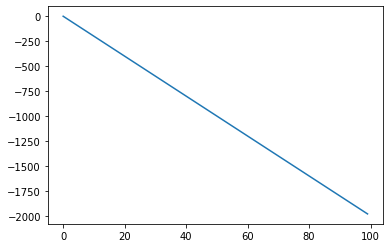

In [ ]:
# profit_list2
plt.plot(profit_list2)

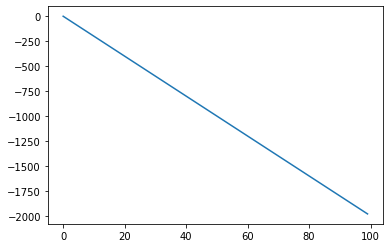

In [ ]:
plt.plot(profit_list2)

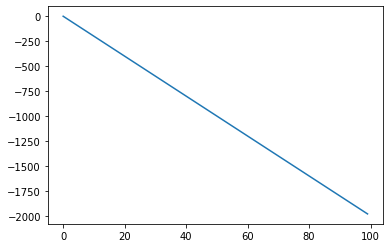

In [ ]:
plt.plot(profit_list2)

In [ ]:
# Method2: Check the profit under different investments
# policy factor: data restriction
c_res_a = 15; c_res_b = 15

# prices
price_s_a = 16
price_s_b = 16

# profit_list2 = []
profit_list2_list = []
# maxinvlist1 = []
for i in range(0,1000,10):
  c_0_a = i
  profit_list2 = []
  for j in range(0,1000,10): # 0,1000,10
    # cost of contract
    # c_0_a = i # adjust the cost to raise the functionality
    c_0_b = j

    # fundamental
    theta_1_bar_a_value = 0.8
    theta_1_bar_b_value = 0.8

    # functionality
    theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
    theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2 = []
    welf = []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
          welf.append(utili_a[i])
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
          welf.append(utili_b[i])
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
          welf.append(utili_a[i])
      else:
        pass

    # m1 = sum(buy)
    m2 = sum(buy2)
    # pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
    profit_list2.append(pr2)
  profit_list2_list.append(profit_list2)


In [ ]:
profit_list2_list[0]==profit_list2_list[1]

False

In [ ]:
range(0,1000,10)

range(0, 1000, 10)

Text(0, 0.5, '$\\Pi_{b}$')

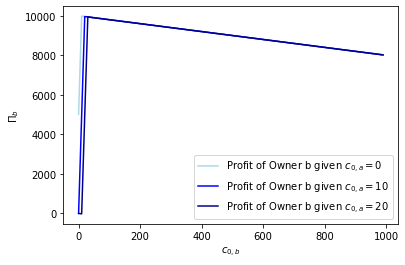

In [ ]:
plt.plot(range(0,1000,10),profit_list2_list[0],"lightblue")
plt.plot(range(0,1000,10),profit_list2_list[1],"blue")
plt.plot(range(0,1000,10),profit_list2_list[2],"darkblue")
# plt.plot(profit_list2_list[5], "Profit of Owner b given c_{0,a}=5")
# plt.plot(profit_list2_list[9], "Profit of Owner b given c_{0,a}=9")
plt.legend(['Profit of Owner b given $c_{0,a}=0$',
            'Profit of Owner b given $c_{0,a}=10$',
            'Profit of Owner b given $c_{0,a}=20$',])
plt.xlabel("$c_{0,b}$")
plt.ylabel("$\Pi_{b}$")

In [ ]:
# plt.plot(profit_list2)
# plt.label

In [ ]:
# Method2: Check the profit under different investments
# policy factor: data restriction
c_res_a = 5; c_res_b = 5

# prices
price_s_a = 5
price_s_b = 5

# profit_list2 = []
# profit_list2_list = []
# maxinvlist1 = []
c_0_a = 2
for j in range(0,1000,10): # 0,1000,10
  # cost of contract
  # c_0_a = i # adjust the cost to raise the functionality
  c_0_b = j

  # fundamental
  theta_1_bar_a_value = 0.8
  theta_1_bar_b_value = 0.8

  # functionality
  theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
  theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

  # utilities
  utili_a = []
  utili_b = []
  for i in range(0, n_customers):
    utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
    utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

  # reserved utility
  ru = np.random.uniform(50, 50, n_customers) # homogenous

  # buy randomly from one company if the utilities are the same
  bin = np.random.binomial(1, 0.5, n_customers)

  buy = []
  buy2 = []
  welf = []

  for i in range(0, n_customers):
    if ru[i] <= max(utili_a[i], utili_b[i]):
      if utili_a[i] > utili_b[i]:
        buy.append(1)
        welf.append(utili_a[i])
      elif utili_a[i] < utili_b[i]:
        buy2.append(1)
        welf.append(utili_b[i])
      else:
        buy.append(bin[i])
        buy2.append(1-bin[i])
        welf.append(utili_a[i])
    else:
      pass

  # m1 = sum(buy)
  m2 = sum(buy2)
  # pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
  pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
  profit_list2.append(pr2)

In [ ]:
indx = np.where(profit_list2 == np.max(profit_list2))[0].tolist()[0]

In [ ]:
range(0,10)[indx]

0

In [ ]:
# maxinvlist1.append(range(0,10)[indx])

In [ ]:
## Results

parameter_names = [# 'fair value of raw data', # not considered
                   'data restriction level', # $c_{res, i}$
                  #  'license value', # not considered
                   'cost of contract', # investment of the Owner $c_{0, i}$
                   'price of product', # $p_{s, i}$
                  #  'alpha', # constant incurred in the payment
                   'functionality of product', # $\theta_i$
                   'utility constant', # $\bar{u}_{j,i}$
                  #  'average utility', # may not be important
                   'number of purchase', # $m_i$
                   'total revenue', # $m_i p_{s, i}$
                   'total cost', # $c_{total,i}$
                   'profit'] # $\Pi_i$

                  #  [p_0_a, c_res_a, p_lic_a, c_0_a, price_s_a, alpha_a,
                  #          theta_1_value_a, u_bar_a, m1, pr1]

# Parameters
# fair value of raw data
# p_0_a = 10; p_0_b = 10

# policy factor: data restriction
c_res_a = 15; c_res_b = 15

# Variables
# license
# p_lic_a = 4; p_lic_b = 4

# scale alpha
# alpha_a = 2000 # thinking about the final payment to the Developers
# alpha_b = 2000

# cost of contract
c_0_a = 990 # adjust the cost to raise the functionality
c_0_b = 990

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# prices
price_s_a = 16
price_s_b = 16

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

# reserved utility
ru = np.random.uniform(50, 50, n_customers) # homogenous

# buy randomly from one company if the utilities are the same
bin = np.random.binomial(1, 0.5, n_customers)

buy = []
buy2 = []
welf = []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
      welf.append(utili_a[i])
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
      welf.append(utili_b[i])
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
      welf.append(utili_a[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [#p_0_a,
                           c_res_a,
                          #  p_lic_a,
                           c_0_a,
                           price_s_a,
                          #  alpha_a,
                           theta_1_value_a,
                           u_bar_a,
                          #  round(np.mean(utili_a),2),
                           m1,
                           m1 * price_s_a,
                           deltap_a(c_0_a) + m1 * c_res_a,
                           pr1]
parameter_values_list_b = [#p_0_b,
                           c_res_b,
                          #  p_lic_b,
                           c_0_b, price_s_b,
                          #  alpha_b,
                           theta_1_value_b, u_bar_b,
                          #  round(np.mean(utili_b),2),
                           m2,
                           m2 * price_s_b,
                           deltap_a(c_0_b) + m2 * c_res_b,
                           pr2]

# Objective functions regarding the global welfare
agg_total_cost = deltap_a(c_0_a) + m1 * c_res_a + deltap_a(c_0_b) + m2 * c_res_b
agg_welfare = sum(welf) - agg_total_cost

Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})

print(f"Global welfare equals: {round(agg_welfare, 2)}")
print(f"Global profit equals: {round(pr1 + pr2, 2)}")
# Question: Are the global welfare and the global profit positively correlated?
# No, instead, they might be negatively correlated.
Table_param

Global welfare equals: 10640245.64
Global profit equals: 6040


Parameters and Outcomes  Region A  Region B
0    data restriction level      15.0      15.0
1          cost of contract     990.0     990.0
2          price of product      16.0      16.0
3  functionality of product    1980.8    1980.8
4          utility constant     100.0     100.0
5        number of purchase    5008.0    4992.0
6             total revenue   80128.0   79872.0
7                total cost   77100.0   76860.0
8                    profit    3028.0    3012.0

In [ ]:
# Method 1
# policy factor: data restriction
c_res_a = 15; c_res_b = 15

# equilibrium prices
price_s_a = 16; price_s_b = 16

# cost of contract
# c_0_a = 60
# c_0_b = 60

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

pricelist1 = []
maxinvlist1 = []

# Get the optimal investment
for jj in range(0, 1000, 10):
  c_0_b = jj
  pricelist1 = []
  for ii in range(0, 1000, 10):
    c_0_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
    # pricelist1 = []
    pricelist1.append(pr1)

    # Find which investment could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  maxinvlist1.append(range(0, 1000, 10)[indx])

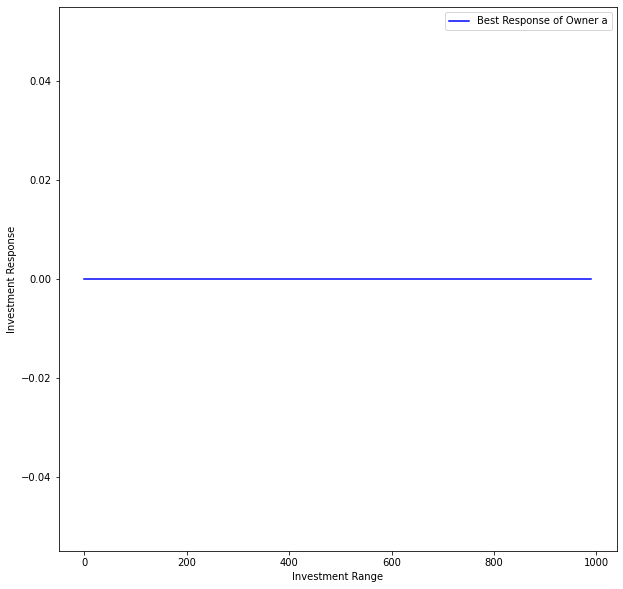

In [ ]:
plt.figure(figsize=(10,10))
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
plt.plot(range(0, 1000, 10), maxinvlist1, color = 'blue')
# plt.plot(maxpricelist2, range(0, 100, 1), color = 'orange')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
plt.legend(['Best Response of Owner a','Best Response of Owner b'])

plt.xlabel('Investment Range')
plt.ylabel('Investment Response')
plt.show() # difference in two maxpricelists is the result of the Binomial dist.

In [ ]:
n_customers

10000

In [ ]:
# policy factor: data restriction
c_res_a = 15; c_res_b = 15

# equilibrium prices
price_s_a = 16; price_s_b = 16

# cost of contract
# c_0_a = 60
# c_0_b = 60

# functionality
# theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
# theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

pricelist1 = []
maxinvlist1 = []

# Get the optimal investment
for jj in range(0, 1000, 10):
  c_0_b = jj
  pricelist1 = []
  for ii in range(0, 1000, 10):
    c_0_a = ii

    theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
    theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
    # pricelist1 = []
    pricelist1.append(pr1)

    # Find which investment could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  maxinvlist1.append(range(0, 1000, 10)[indx])

# Keeping the parameters the same

# prices
# price_s_a = 40
# price_s_b = 40

pricelist2 = []
# maxpricelist1 = []
maxinvlist2 = []

# number of customers
# n_customers = 10000


# Get the optimal price
for jj in range(0, 1000, 10):
  c_0_a = jj
  # price_s_b = jj
  pricelist2 = []
  for ii in range(0, 1000, 10):
    # price_s_a = ii
    c_0_b = ii

    theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
    theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
    # pricelist1 = []

    # pricelist1.append(pr1)
    pricelist2.append(pr2)


    # Find which price could bring the maximum profit
  indx = np.where(pricelist2 == np.max(pricelist2))[0].tolist()[0]
  # maxpricelist1.append(range(0, 100, 1)[indx])
  maxinvlist2.append(range(0, 1000, 10)[indx]) # 15 min.

In [ ]:
# maxinvlist2

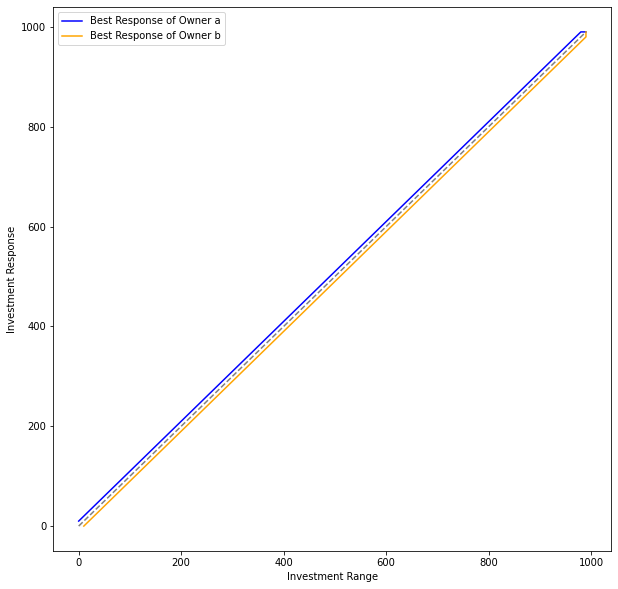

In [ ]:
plt.figure(figsize=(10,10))
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
plt.plot(range(0, 1000, 10), maxinvlist1, color = 'blue')
plt.plot(maxinvlist2, range(0, 1000, 10), color = 'orange')
plt.plot(range(0, 1000, 10), range(0, 1000, 10), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
plt.legend(['Best Response of Owner a','Best Response of Owner b'])

plt.xlabel('Investment Range')
plt.ylabel('Investment Response')
plt.show() # difference in two maxpricelists is the result of the Binomial dist. # Why asymmetric?

In [ ]:
# Show the equilibrium(-a) point(s)
sum_table = pd.DataFrame({'maxinvlist1': maxinvlist1,
                         'maxinvlist2': maxinvlist2,
                         'price range': list(range(0, 1000, 10))})
# sum_table[sum_table['maxpricelist1'] == sum_table['price range']]
# sum_table#[sum_table['maxpricelist1'] == sum_table['maxpricelist2']]
coordinates_blue  = []
coordinates_yellow = []
for i in range(0,len(sum_table)):
  coordinates_blue.append((sum_table["price range"][i], maxinvlist1[i]))
  coordinates_yellow.append((maxinvlist2[i], sum_table["price range"][i]))
sum_table2 = pd.DataFrame({"br1": coordinates_blue, "br2": coordinates_yellow})
# Find the intersection point(s): (firm b, firm a)
[i for i in sum_table2["br1"].tolist() if i in sum_table2["br2"].tolist()]

[(990, 990)]

Step 3: Find the corresponding regulation levels

In [ ]:
# (c*_{0,a}, c*_{0,b}) = (0, 0) # the equil. price is too small to generate a profit
# (c_{res,a}, c_{res,b}) = (5, 5)
# (p_a*, p_b*) = (5，5)
# Symmetric: Just compute one of the regulation levels.

In [ ]:
# investments
c_0_a = 0; c_0_b = 0

# policy factor: data restriction
# c_res_a = 5; c_res_b = 5

# prices
price_s_a = 15
price_s_b = 15

profit_list2 = []
maxreglist2 = []
for i in range(0,100):
  c_res_a = i
  for j in range(0,100): # 0,1000,10
    # cost of contract
    # c_0_a = i # adjust the cost to raise the functionality
    c_res_b = j

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2 = []
    welf = []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
          welf.append(utili_a[i])
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
          welf.append(utili_b[i])
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
          welf.append(utili_a[i])
      else:
        pass

    # m1 = sum(buy)
    m2 = sum(buy2)
    # pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
    profit_list2.append(pr2)

  indx = np.where(profit_list2 == np.max(profit_list2))[0].tolist()[0]
  maxreglist2.append(range(0,100)[indx])

In [ ]:
max(maxreglist2)

0

In [ ]:
len(maxreglist2)

100

In [ ]:
# In equilibrium

## Results

parameter_names = [# 'fair value of raw data', # not considered
                   'data restriction level', # $c_{res, i}$
                  #  'license value', # not considered
                   'cost of contract', # investment of the Owner $c_{0, i}$
                   'price of product', # $p_{s, i}$
                  #  'alpha', # constant incurred in the payment
                   'functionality of product', # $\theta_i$
                   'utility constant', # $\bar{u}_{j,i}$
                  #  'average utility', # may not be important
                   'number of purchase', # $m_i$
                   'total revenue', # $m_i p_{s, i}$
                   'total cost', # $c_{total,i}$
                   'profit'] # $\Pi_i$


# equil. data restriction level
c_res_a = 0; c_res_b = 0

# equil. inv
c_0_a = 0; c_0_b = 0

# equil. prices
price_s_a = 15; price_s_b = 15

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

# reserved utility
ru = np.random.uniform(50, 50, n_customers) # homogenous

# buy randomly from one company if the utilities are the same
bin = np.random.binomial(1, 0.5, n_customers)

buy = []
buy2 = []
welf = []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
      welf.append(utili_a[i])
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
      welf.append(utili_b[i])
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
      welf.append(utili_a[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [#p_0_a,
                           c_res_a,
                          #  p_lic_a,
                           c_0_a,
                           price_s_a,
                          #  alpha_a,
                           theta_1_value_a,
                           u_bar_a,
                          #  round(np.mean(utili_a),2),
                           m1,
                           m1 * price_s_a,
                           deltap_a(c_0_a) + m1 * c_res_a,
                           pr1]
parameter_values_list_b = [#p_0_b,
                           c_res_b,
                          #  p_lic_b,
                           c_0_b, price_s_b,
                          #  alpha_b,
                           theta_1_value_b, u_bar_b,
                          #  round(np.mean(utili_b),2),
                           m2,
                           m2 * price_s_b,
                           deltap_a(c_0_b) + m2 * c_res_b,
                           pr2]

# Objective functions regarding the global welfare
agg_total_cost = deltap_a(c_0_a) + m1 * c_res_a + deltap_a(c_0_b) + m2 * c_res_b
agg_welfare = sum(welf) - agg_total_cost

Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})

print(f"Global welfare equals: {round(agg_welfare, 2)}")
print(f"Global profit equals: {round(pr1 + pr2, 2)}")
# Question: Are the global welfare and the global profit positively correlated?
# No, instead, they might be negatively correlated.
Table_param

Global welfare equals: 854019.44
Global profit equals: 150000


Parameters and Outcomes  Region A  Region B
0    data restriction level       0.0       0.0
1          cost of contract       0.0       0.0
2          price of product      15.0      15.0
3  functionality of product       0.8       0.8
4          utility constant     100.0     100.0
5        number of purchase    4982.0    5018.0
6             total revenue   74730.0   75270.0
7                total cost       0.0       0.0
8                    profit   74730.0   75270.0

In [ ]:
# investments
c_0_a = 0; c_0_b = 0

# policy factor: data restriction
# c_res_a = 5; c_res_b = 5

# prices
price_s_a = 5
price_s_b = 5

profit_list2 = []
maxreglist2 = []
for i in range(0,3):
  c_res_a = i
  for j in range(0,3): # 0,1000,10
    # cost of contract
    # c_0_a = i # adjust the cost to raise the functionality
    c_res_b = j

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2 = []
    welf = []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
          welf.append(utili_a[i])
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
          welf.append(utili_b[i])
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
          welf.append(utili_a[i])
      else:
        pass

    # m1 = sum(buy)
    m2 = sum(buy2)
    # pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
    profit_list2.append(pr2)

  indx = np.where(profit_list2 == np.max(profit_list2))[0].tolist()[0]
  maxreglist2.append(range(0,3)[indx])

# for the other Owner

profit_list1 = []
maxreglist1 = []
for i in range(0,100):
  c_res_b = i
  for j in range(0,100): # 0,1000,10
    # cost of contract
    # c_0_a = i # adjust the cost to raise the functionality
    c_res_a = j

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2 = []
    welf = []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
          welf.append(utili_a[i])
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
          welf.append(utili_b[i])
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
          welf.append(utili_a[i])
      else:
        pass

    m1 = sum(buy)
    # m2 = sum(buy2)
    pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    # pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)
    profit_list1.append(pr1)

  indx = np.where(profit_list1 == np.max(profit_list1))[0].tolist()[0]
  maxreglist1.append(range(0,100)[indx])

## Global welfare analysis in different scenarios

Global Welfare at the Equilibrium Prices: Test the results again and find the according profits and welfare.

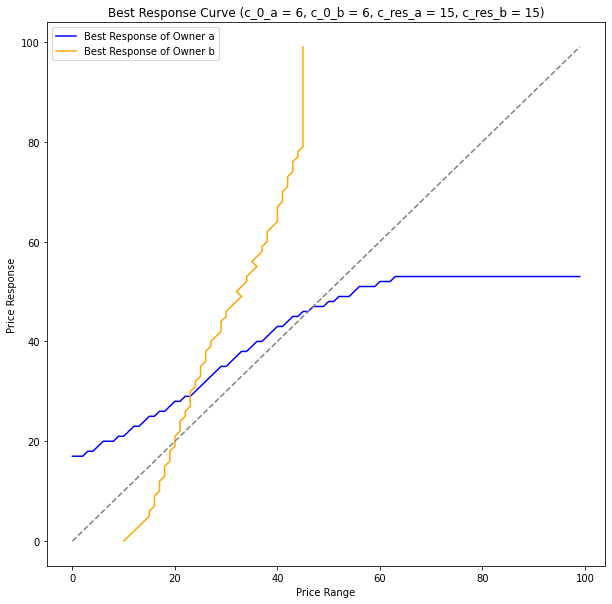

In [ ]:
# Approxiate calc. time: 9 min

# fair value of raw data
# p_0_a = 10; p_0_b = 10

# policy factor: data restriction
c_res_a = 5; c_res_b = 15

# cost of contract
c_0_a = 20 # adjust the cost to raise the functionality
c_0_b = 6

# license
# p_lic_a = 4; p_lic_b = 4

# scale alpha
alpha_a = 2000 # thinking about the final payment to the Developers
alpha_b = 2000

# fundamental
theta_1_bar_a_value = 0.8; theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# prices
# price_s_a = 40
price_s_b = 40

pricelist1 = []
maxpricelist1 = []

# number of customers
n_customers = 10000


# Get the optimal price
for jj in range(0, 100, 1):
  price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, c_0_b, c_res_b)
    # pricelist1 = []
    pricelist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  maxpricelist1.append(range(0, 100, 1)[indx])

# Keeping the parameters the same

# prices
price_s_a = 40
# price_s_b = 40

pricelist1 = []
# maxpricelist1 = []
maxpricelist2 = []

# number of customers
n_customers = 10000


# Get the optimal price
for jj in range(0, 100, 1):
  price_s_a = jj
  # price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    # price_s_a = ii
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, c_0_b, c_res_b)
    # pricelist1 = []

    # pricelist1.append(pr1)
    pricelist1.append(pr2)


    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  # maxpricelist1.append(range(0, 100, 1)[indx])
  maxpricelist2.append(range(0, 100, 1)[indx])

plt.figure(figsize=(10,10))
plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
plt.plot(maxpricelist2, range(0, 100, 1), color = 'orange')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
plt.legend(['Best Response of Owner a','Best Response of Owner b'])

plt.xlabel('Price Range')
plt.ylabel('Price Response')
plt.show() # difference in two maxpricelists is the result of the Binomial dist.

In [ ]:
# Show the equilibrium(-a) point(s)
sum_table = pd.DataFrame({'maxpricelist1': maxpricelist1,
                         'maxpricelist2': maxpricelist2,
                         'price range': list(range(0, 100, 1))})
# sum_table[sum_table['maxpricelist1'] == sum_table['price range']]
# sum_table#[sum_table['maxpricelist1'] == sum_table['maxpricelist2']]
coordinates_blue  = []
coordinates_yellow = []
for i in range(0,len(sum_table)):
  coordinates_blue.append((sum_table["price range"][i], maxpricelist1[i]))
  coordinates_yellow.append((maxpricelist2[i], sum_table["price range"][i]))
sum_table2 = pd.DataFrame({"br1": coordinates_blue, "br2": coordinates_yellow})

In [ ]:
# Find the intersection point(s): (firm b, firm a)
[i for i in sum_table2["br1"].tolist() if i in sum_table2["br2"].tolist()]

[(23, 29)]

In [ ]:
# Plug the equilibrium price(s) into the scenarios and get the
# profits of each Owner, the total profit and the global welfare.

## Results

parameter_names = [# 'fair value of raw data', # not considered
                   'data restriction level', # $c_{res, i}$
                  #  'license value', # not considered
                   'cost of contract', # investment of the Owner $c_{0, i}$
                   'price of product', # $p_{s, i}$
                   'alpha', # constant incurred in the payment
                   'functionality of product', # $\theta_i$
                   'utility constant', # $\bar{u}_{j,i}$
                  #  'average utility', # may not be important
                   'number of purchase', # $m_i$
                   'total revenue', # $m_i p_{s, i}$
                   'total cost', # $c_{total,i}$
                   'profit'] # $\Pi_i$

                  #  [p_0_a, c_res_a, p_lic_a, c_0_a, price_s_a, alpha_a,
                  #          theta_1_value_a, u_bar_a, m1, pr1]

# Parameters
# fair value of raw data
# p_0_a = 10; p_0_b = 10

# policy factor: data restriction
c_res_a = 5; c_res_b = 15

# Variables
# license
# p_lic_a = 4; p_lic_b = 4

# scale alpha
alpha_a = 2000 # thinking about the final payment to the Developers
alpha_b = 2000

# cost of contract
c_0_a = 20; c_0_b = 6

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# equilibrium prices
price_s_a = 29; price_s_b = 23

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

# reserved utility
ru = np.random.uniform(50, 50, n_customers) # homogenous

# buy randomly from one company if the utilities are the same
bin = np.random.binomial(1, 0.5, n_customers)

buy = []
buy2 = []
welf = []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
      welf.append(utili_a[i])
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
      welf.append(utili_b[i])
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
      welf.append(utili_a[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(alpha_a, m1, price_s_a, c_0_a, c_res_a)
pr2 = profit_a(alpha_b, m2, price_s_b, c_0_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [#p_0_a,
                           c_res_a,
                          #  p_lic_a,
                           c_0_a,
                           price_s_a,
                           alpha_a,
                           theta_1_value_a,
                           u_bar_a,
                          #  round(np.mean(utili_a),2),
                           m1,
                           m1 * price_s_a,
                           alpha_a * deltap_a(c_0_a) + m1 * c_res_a,
                           pr1]
parameter_values_list_b = [#p_0_b,
                           c_res_b,
                          #  p_lic_b,
                           c_0_b, price_s_b, alpha_b,
                           theta_1_value_b, u_bar_b,
                          #  round(np.mean(utili_b),2),
                           m2,
                           m2 * price_s_b,
                           alpha_b * deltap_a(c_0_b) + m2 * c_res_b,
                           pr2]

# Objective functions regarding the global welfare
agg_total_cost = alpha_a * deltap_a(c_0_a) + m1 * c_res_a + alpha_b * deltap_a(c_0_b) + m2 * c_res_b
agg_welfare = sum(welf) - agg_total_cost

Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})

print(f"Global welfare equals: {round(agg_welfare, 2)}")
print(f"Global profit equals: {round(pr1 + pr2, 2)}")
# Question: Are the global welfare and the global profit positively correlated?
# No, instead, they might be negatively correlated.
Table_param #\\\\\\\

Global welfare equals: 751129.54
Global profit equals: 99248


Parameters and Outcomes  Region A  Region B
0    data restriction level       5.0      15.0
1          cost of contract      20.0       6.0
2          price of product      29.0      23.0
3                     alpha    2000.0    2000.0
4  functionality of product      40.8      12.8
5          utility constant     100.0     100.0
6        number of purchase    7703.0    2297.0
7             total revenue  223387.0   52831.0
8                total cost  118515.0   58455.0
9                    profit  104872.0   -5624.0

In [ ]:
# Save the values and get the dataframe
values_sce = pd.DataFrame({"Scenario":[1,1,2,2,3,3,4,5,6],
              "Eq_Price_a": [5, 6, 15, 16, 5, 6, 14, 19, 29],
              "Eq_Price_b": [5, 6, 15, 16, 5, 6, 24, 22, 23],
              "Profit_a": [-24000, -19032, -24000, -19000,
                           -80000, -74901, 7770, 66090,
                           104872],
              "Profit_b": [-24000, -18968, -24000, -19000,
                           -80000, -75099, 42930, 955,
                           -5624],
              "Total Profit": [-48000, -19032-18968, -48000,
                               -38000, -160000,
                               -150000, 50700, 67045,
                               99248],
              "Global Welfare": [917000.79, 907000.79,
                                 718380.26,
                                 708380.26,
                                 945681.24,
                                 935681.24,
                                 829257.07,
                                 754014.22,
                                 751129.54]})

In [ ]:
values_sce.to_csv("Welfare_sce.csv", index = False)

In [ ]:
# len(values_sce)
values_sce_1 = values_sce.iloc[[0,2,4,6,7,8]]

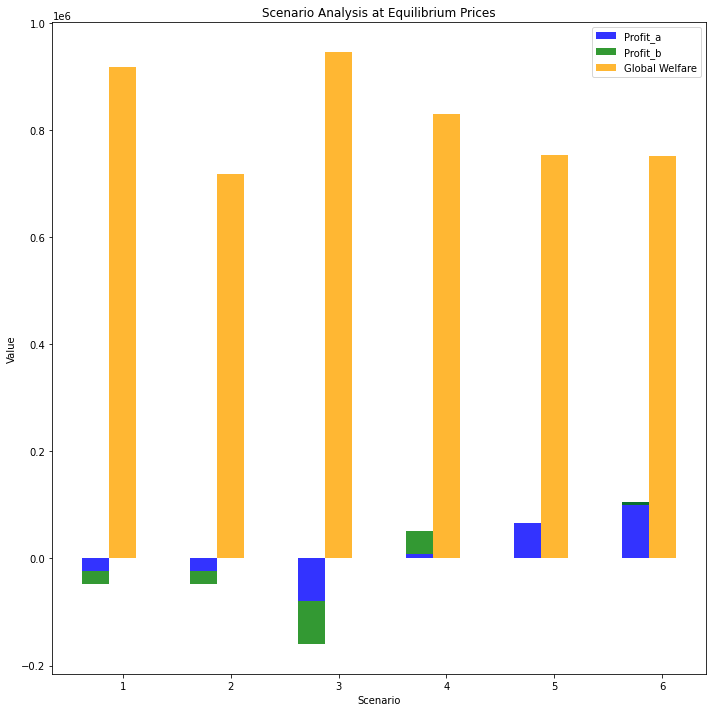

In [ ]:
# Bar chart
# create plot
fig, ax = plt.subplots()
index = np.arange(len(values_sce_1))
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, values_sce_1["Profit_a"], bar_width,
alpha=opacity,
color='b',
label='Profit_a')

rects2 = plt.bar(index, values_sce_1["Profit_b"], bar_width,
alpha=opacity, bottom = values_sce_1["Profit_a"],
color='g',
label='Profit_b')

rects3 = plt.bar(index + bar_width, values_sce_1["Global Welfare"],
                 bar_width,
alpha=opacity,
color='orange',
label='Global Welfare')

# plt.plot(figsize=(200,20))
plt.rcParams["figure.figsize"] = (10,10)

plt.xlabel('Scenario')
plt.ylabel('Value')
plt.title('Scenario Analysis at Equilibrium Prices')
# plt.xticks(index + bar_width, ('1', "1", '2', '2', '3', "3", "4",
                              #  "5", "6"))
plt.xticks(index + bar_width, ('1', '2', "3", "4",
                               "5", "6"))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 1107 Trial of an interactive plot

def f(c_res_a = 5, c_res_b = 5):

    # # policy factor: data restriction
    # c_res_a = 5
    # c_res_b = 5

    # scale alpha
    alpha_a = 2000 # thinking about the final payment to the Developers
    alpha_b = 2000

    # cost of contract
    c_0_a = 6 # adjust the cost to raise the functionality
    c_0_b = 6

    # fundamental
    theta_1_bar_a_value = 0.8
    theta_1_bar_b_value = 0.8

    # functionality
    theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
    theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

    # utility constant
    u_bar_a = 100
    u_bar_b = 100

    # prices
    price_s_b = 40

    pricelist1 = []
    maxpricelist1 = []

    # number of customers
    n_customers = 10000

    # Get the optimal price
    for jj in range(0, 100, 1):
        price_s_b = jj
        pricelist1 = []
        for ii in range(0, 100, 1):
            price_s_a = ii

            # utilities
            utili_a = []
            utili_b = []
            for i in range(0, n_customers):
              utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
              utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

            # reserved utility
            ru = np.random.uniform(50, 50, n_customers) # homogenous

            # buy randomly from one company if the utilities are the same
            bin = np.random.binomial(1, 0.5, n_customers)

            buy = []
            buy2= []

            for i in range(0, n_customers):
              if ru[i] <= max(utili_a[i], utili_b[i]):
                if utili_a[i] > utili_b[i]:
                  buy.append(1)
                elif utili_a[i] < utili_b[i]:
                  buy2.append(1)
                else:
                  buy.append(bin[i])
                  buy2.append(1-bin[i])
              else:
                pass

            m1 = sum(buy)
            m2 = sum(buy2)
            pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
            pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
            # pricelist1 = []
            pricelist1.append(pr1)

            # Find which price could bring the maximum profit
        indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
        maxpricelist1.append(range(0, 100, 1)[indx])

    # For the other firm: Keeping the parameters the same

    # prices
    price_s_a = 40

    pricelist1 = []
    # maxpricelist1 = []
    maxpricelist2 = []

    # number of customers
    n_customers = 10000

    # Get the optimal price
    for jj in range(0, 100, 1):
        price_s_a = jj
        # price_s_b = jj
        pricelist1 = []
        for ii in range(0, 100, 1):
            # price_s_a = ii
            price_s_b = ii

            # utilities
            utili_a = []
            utili_b = []
            for i in range(0, n_customers):
              utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
              utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

            # reserved utility
            ru = np.random.uniform(50, 50, n_customers) # homogenous

            # buy randomly from one company if the utilities are the same
            bin = np.random.binomial(1, 0.5, n_customers)

            buy = []
            buy2= []

            for i in range(0, n_customers):
              if ru[i] <= max(utili_a[i], utili_b[i]):
                if utili_a[i] > utili_b[i]:
                  buy.append(1)
                elif utili_a[i] < utili_b[i]:
                  buy2.append(1)
                else:
                  buy.append(bin[i])
                  buy2.append(1-bin[i])
              else:
                pass

            m1 = sum(buy)
            m2 = sum(buy2)
            pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
            pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
            # pricelist1 = []

            # pricelist1.append(pr1)
            pricelist1.append(pr2)

          # Find which price could bring the maximum profit
        indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
        # maxpricelist1.append(range(0, 100, 1)[indx])
        maxpricelist2.append(range(0, 100, 1)[indx])

    plt.figure(figsize=(10,10))
    plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6)')
    plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
    plt.plot(maxpricelist2, range(0, 100, 1), color = 'orange')
    plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')

    # plt.legend(['Best Response of Owner a','45° Line'])
    plt.legend(['Best Response of Owner a','Best Response of Owner b'])

    plt.xlabel('Price Range')
    plt.ylabel('Price Response')
    plt.show() # difference in two maxpricelists is the result of the Binomial dist.

interactive_plot = interactive(f, c_res_a=(0, 20, 0.5), c_res_b=(0, 20, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px' # height of the output box
interactive_plot

interactive(children=(FloatSlider(value=5.0, description='c_res_a', max=20.0, step=0.5), FloatSlider(value=5.0…

In [ ]:
# 1107 Trial of an interactive plot # simpler version, n_customers = 1000

def f(c_res_a = 5, c_res_b = 5):

    # # policy factor: data restriction
    # c_res_a = 5
    # c_res_b = 5

    # scale alpha
    alpha_a = 2000 # thinking about the final payment to the Developers
    alpha_b = 2000

    # cost of contract
    c_0_a = 6 # adjust the cost to raise the functionality
    c_0_b = 6

    # fundamental
    theta_1_bar_a_value = 0.8
    theta_1_bar_b_value = 0.8

    # functionality
    theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
    theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

    # utility constant
    u_bar_a = 100
    u_bar_b = 100

    # prices
    price_s_b = 40

    pricelist1 = []
    maxpricelist1 = []

    # number of customers
    n_customers = 1000

    # Get the optimal price
    for jj in range(0, 100, 1):
        price_s_b = jj
        pricelist1 = []
        for ii in range(0, 100, 1):
            price_s_a = ii

            # utilities
            utili_a = []
            utili_b = []
            for i in range(0, n_customers):
              utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
              utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

            # reserved utility
            ru = np.random.uniform(50, 50, n_customers) # homogenous

            # buy randomly from one company if the utilities are the same
            bin = np.random.binomial(1, 0.5, n_customers)

            buy = []
            buy2= []

            for i in range(0, n_customers):
              if ru[i] <= max(utili_a[i], utili_b[i]):
                if utili_a[i] > utili_b[i]:
                  buy.append(1)
                elif utili_a[i] < utili_b[i]:
                  buy2.append(1)
                else:
                  buy.append(bin[i])
                  buy2.append(1-bin[i])
              else:
                pass

            m1 = sum(buy)
            m2 = sum(buy2)
            pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
            pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
            # pricelist1 = []
            pricelist1.append(pr1)

            # Find which price could bring the maximum profit
        indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
        maxpricelist1.append(range(0, 100, 1)[indx])

    # For the other firm: Keeping the parameters the same

    # prices
    price_s_a = 40

    pricelist1 = []
    # maxpricelist1 = []
    maxpricelist2 = []

    # number of customers
    n_customers = 1000

    # Get the optimal price
    for jj in range(0, 100, 1):
        price_s_a = jj
        # price_s_b = jj
        pricelist1 = []
        for ii in range(0, 100, 1):
            # price_s_a = ii
            price_s_b = ii

            # utilities
            utili_a = []
            utili_b = []
            for i in range(0, n_customers):
              utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
              utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

            # reserved utility
            ru = np.random.uniform(50, 50, n_customers) # homogenous

            # buy randomly from one company if the utilities are the same
            bin = np.random.binomial(1, 0.5, n_customers)

            buy = []
            buy2= []

            for i in range(0, n_customers):
              if ru[i] <= max(utili_a[i], utili_b[i]):
                if utili_a[i] > utili_b[i]:
                  buy.append(1)
                elif utili_a[i] < utili_b[i]:
                  buy2.append(1)
                else:
                  buy.append(bin[i])
                  buy2.append(1-bin[i])
              else:
                pass

            m1 = sum(buy)
            m2 = sum(buy2)
            pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
            pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
            # pricelist1 = []

            # pricelist1.append(pr1)
            pricelist1.append(pr2)

          # Find which price could bring the maximum profit
        indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
        # maxpricelist1.append(range(0, 100, 1)[indx])
        maxpricelist2.append(range(0, 100, 1)[indx])

    plt.figure(figsize=(10,10))
    plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6)')
    plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
    plt.plot(maxpricelist2, range(0, 100, 1), color = 'orange')
    plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')

    # plt.legend(['Best Response of Owner a','45° Line'])
    plt.legend(['Best Response of Owner a','Best Response of Owner b'])

    plt.xlabel('Price Range')
    plt.ylabel('Price Response')
    plt.show() # difference in two maxpricelists is the result of the Binomial dist.

interactive_plot = interactive(f, c_res_a=(0, 20, 0.5), c_res_b=(0, 20, 0.5))

output = interactive_plot.children[-1]
output.layout.height = '2000px' # height of the output box
interactive_plot

interactive(children=(FloatSlider(value=5.0, description='c_res_a', max=20.0, step=0.5), FloatSlider(value=5.0…

There are multiple equilibria in the case above.

Sequential best response curves:

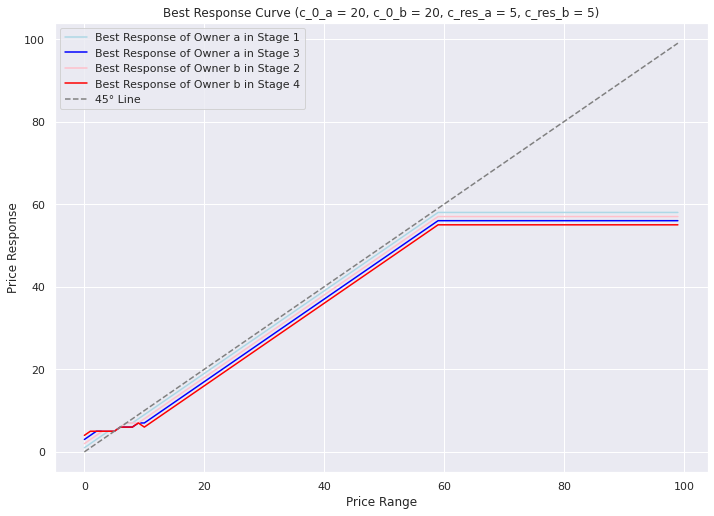

In [ ]:
# Parameters
# fair value of raw data
p_0_a = 10
p_0_b = 10

# policy factor: data restriction
c_res_a = 5
c_res_b = 5

# Variables
# license
p_lic_a = 4
p_lic_b = 4

# scale alpha
alpha_a = 2000 # thinking about the final payment to the Developers
alpha_b = 2000

# cost of contract
c_0_a = 20 # adjust the cost to raise the functionality
c_0_b = 20

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# prices
# price_s_a = 40
price_s_b = 40

pricelist1 = []
maxpricelist1 = []

# number of customers
n_customers = 10000


# Get the optimal price
for jj in range(0, 100, 1):
  price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  maxpricelist1.append(range(0, 100, 1)[indx])

# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
# plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxpricelist2 = []
for jj in range(0, 100, 1):
  price_s_a = maxpricelist1[jj]
  pricelist2 = []
  for ii in range(0, 100, 1):
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    pricelist2.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist2 == np.max(pricelist2))[0].tolist()[0]
  maxpricelist2.append(range(0, 100, 1)[indx])

# # Plot the curve for the 2nd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner b in Stage 2',
#             '45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

'''
In the next stage, firm a will respond to the actions of firm b.
'''
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxpricelist3 = []
for jj in range(0, 100, 1):
  price_s_b = maxpricelist2[jj]
  pricelist3 = []
  for ii in range(0, 100, 1):
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist3.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist3 == np.max(pricelist3))[0].tolist()[0]
  maxpricelist3.append(range(0, 100, 1)[indx])

# # Plot the curve for the 3rd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
# plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner a in Stage 3',
#             'Best Response of Owner b in Stage 2','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

# Further, firm b will adjust the prices too.
'''
In the next stage, firm a will respond to the actions of firm b.
'''
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxpricelist4 = []
for jj in range(0, 100, 1):
  price_s_a = maxpricelist3[jj]
  pricelist4 = []
  for ii in range(0, 100, 1):
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist4.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist4 == np.max(pricelist4))[0].tolist()[0]
  maxpricelist4.append(range(0, 100, 1)[indx])

# Plot the curve for the 4th stage
plt.title('Best Response Curve (c_0_a = 20, c_0_b = 20, c_res_a = 5, c_res_b = 5)')
plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
plt.plot(range(0, 100, 1), maxpricelist2, 'pink')
plt.plot(range(0, 100, 1), maxpricelist4, 'red')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
         linestyle = '--')
plt.legend(['Best Response of Owner a in Stage 1',
            'Best Response of Owner a in Stage 3',
            'Best Response of Owner b in Stage 2',
            'Best Response of Owner b in Stage 4',
            '45° Line'])
plt.xlabel('Price Range')
plt.ylabel('Price Response')
plt.show()

### Asymmetric Cases

#### Case 1: Different costs of contract (functionalities)

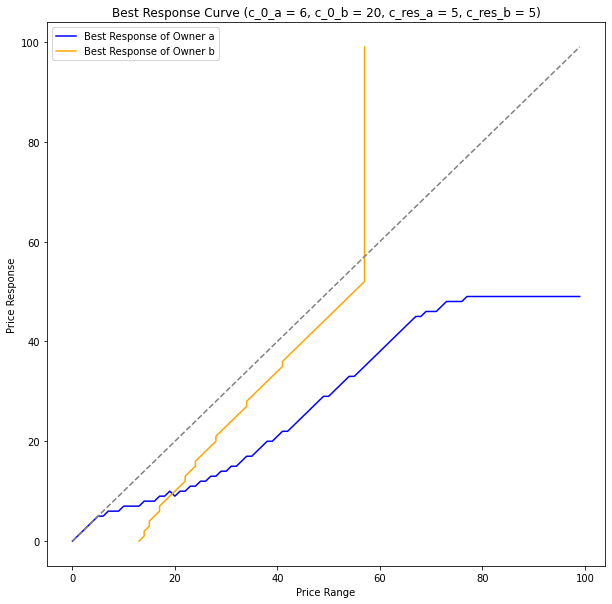

In [ ]:
## Step1: Check the best response of one firm.

# Parameters
# fair value of raw data
p_0_a = 10
p_0_b = 10

# policy factor: data restriction
c_res_a = 5
c_res_b = 5

# Variables
# license
p_lic_a = 4
p_lic_b = 4

# scale alpha
alpha_a = 2000 # thinking about the final payment to the Developers
alpha_b = 2000

# cost of contract # Note: Here is the change!!
c_0_a = 6 # adjust the cost to raise the functionality
c_0_b = 20

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# prices
# price_s_a = 40
price_s_b = 40

pricelist1 = []
maxpricelist1 = []

# number of customers
n_customers = 10000


# Get the optimal price
for jj in range(0, 100, 1):
  price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  maxpricelist1.append(range(0, 100, 1)[indx])

# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()


## Step2: Check the best response of the other firm.
# Keeping the parameters the same

# prices
price_s_a = 40
# price_s_b = 40

pricelist1 = []
# maxpricelist1 = []
maxpricelist2 = []

# number of customers
n_customers = 10000


# Get the optimal price
for jj in range(0, 100, 1):
  price_s_a = jj
  # price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    # price_s_a = ii
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []

    # pricelist1.append(pr1)
    pricelist1.append(pr2)


    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  # maxpricelist1.append(range(0, 100, 1)[indx])
  maxpricelist2.append(range(0, 100, 1)[indx])


# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
# plt.plot(range(0, 100, 1), maxpricelist2, color = 'orange')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()


## Step 3: Plot the graph of best response curves.
plt.figure(figsize=(10,10))
plt.title('Best Response Curve (c_0_a = 6, c_0_b = 20, c_res_a = 5, c_res_b = 5)')
plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
plt.plot(maxpricelist2, range(0, 100, 1), color = 'orange')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')

# plt.legend(['Best Response of Owner a','45° Line'])
plt.legend(['Best Response of Owner a','Best Response of Owner b'])
plt.xlabel('Price Range')
plt.ylabel('Price Response')
plt.show()

In [ ]:
## Step 4: Find the equilibrium / equilibria.
sum_table = pd.DataFrame({'maxpricelist1': maxpricelist1,
                         'maxpricelist2': maxpricelist2,
                         'price range': list(range(0, 100, 1))})
# Check the 45° line.
# sum_table[sum_table['maxpricelist1'] == sum_table['price range']]

# Find the tuples: One approach to get the equilibrium.
# (sum_table['maxpricelist1'][0], sum_table['maxpricelist2'][0])

# generate the tuples
tuple01 = []
tuple02 = []

for i in range(0, len(sum_table)):
    # tuple01.append((sum_table['maxpricelist1'][i], sum_table['maxpricelist2'][i]))
    # tuple02.append((sum_table['maxpricelist2'][i], sum_table['maxpricelist1'][i]))
    tuple01.append((sum_table['price range'][i], sum_table['maxpricelist1'][i]))
    tuple02.append((sum_table['maxpricelist2'][i], sum_table['price range'][i]))


sum_table['tuple_1_2'] = tuple01
sum_table['tuple_2_1'] = tuple02

# sum_table[sum_table['tuple_1_2'] == sum_table['tuple_2_1']] # too strict
# sum_table[5:25]
# sum_table[sum_table['maxpricelist2'] == sum_table['price range']]

# find the tuple in the intersection
ints_list = [i for i in sum_table['tuple_1_2'].tolist() if i in sum_table['tuple_2_1'].tolist()]
ints_list # Equilibrium / Equilibria, (firm b, firm a)

[]

We can apply the codes above when they work.

In [ ]:
# Validation

# Example setting 01
p_0_a = 10; p_0_b = 10 # fair value of raw data
c_res_a = 5; c_res_b = 5 # policy factor: data restriction
alpha_a = 2000; alpha_b = 2000 # scale alpha
c_0_a = 6; c_0_b = 20 # cost of contract
theta_1_bar_a_value = 0.8; theta_1_bar_b_value = 0.8 # fundamental

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

u_bar_a = 100; u_bar_b = 100 # utility constant

price_s_a = 30; price_s_b = 30 # prices

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

# reserved utility
ru = np.random.uniform(50, 50, n_customers) # homogenous

# buy randomly from one company if the utilities are the same
bin = np.random.binomial(1, 0.5, n_customers)

buy = []
buy2= []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [p_0_a, c_res_a, p_lic_a, c_0_a, price_s_a, alpha_a,
                           theta_1_value_a, u_bar_a, round(np.mean(utili_a),2), m1,
                           m1 * price_s_a, alpha_a * deltap_a(c_0_a) + m1 * c_res_a, pr1]
parameter_values_list_b = [p_0_b, c_res_b, p_lic_b, c_0_b, price_s_b, alpha_b,
                           theta_1_value_b, u_bar_b, round(np.mean(utili_b),2), m2,
                           m2 * price_s_b, alpha_b * deltap_a(c_0_b) + m2 * c_res_b, pr2]
Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})
Table_param



Parameters and Outcomes  Region A   Region B
0   fair value of raw data     10.00      10.00
1         data restriction      5.00       5.00
2            license value      4.00       4.00
3         cost of contract      6.00      20.00
4         price of product     30.00      30.00
5                    alpha   2000.00    2000.00
6       quality of product     12.80      40.80
7         utility constant    100.00     100.00
8          average utility     73.15      77.71
9                   orders      0.00   10000.00
10           total revenue      0.00  300000.00
11              total cost  24000.00  130000.00
12                 profits -24000.00  170000.00

In [ ]:
print('Total profits of the industry = ' + str(total_pr))

Total profits of the industry = 153750


In [ ]:
# change to the equilibrium price tuple (10, 8)

p_0_a = 10; p_0_b = 10 # fair value of raw data
c_res_a = 5; c_res_b = 5 # policy factor: data restriction
alpha_a = 2000; alpha_b = 2000 # scale alpha
c_0_a = 6; c_0_b = 20 # cost of contract
theta_1_bar_a_value = 0.8; theta_1_bar_b_value = 0.8 # fundamental

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

u_bar_a = 100; u_bar_b = 100 # utility constant

price_s_a = 8; price_s_b = 10 # prices # Here is the change!!

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

# reserved utility
ru = np.random.uniform(50, 50, n_customers) # homogenous

# buy randomly from one company if the utilities are the same
bin = np.random.binomial(1, 0.5, n_customers)

buy = []
buy2= []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [p_0_a, c_res_a, p_lic_a, c_0_a, price_s_a, alpha_a,
                           theta_1_value_a, u_bar_a, round(np.mean(utili_a),2), m1,
                           m1 * price_s_a, alpha_a * deltap_a(c_0_a) + m1 * c_res_a, pr1]
parameter_values_list_b = [p_0_b, c_res_b, p_lic_b, c_0_b, price_s_b, alpha_b,
                           theta_1_value_b, u_bar_b, round(np.mean(utili_b),2), m2,
                           m2 * price_s_b, alpha_b * deltap_a(c_0_b) + m2 * c_res_b, pr2]
Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})
Table_param

Parameters and Outcomes  Region A   Region B
0   fair value of raw data     10.00      10.00
1         data restriction      5.00       5.00
2            license value      4.00       4.00
3         cost of contract      6.00      20.00
4         price of product      8.00      10.00
5                    alpha   2000.00    2000.00
6       quality of product     12.80      40.80
7         utility constant    100.00     100.00
8          average utility     95.15      97.71
9                   orders   2701.00    7299.00
10           total revenue  21608.00   72990.00
11              total cost  37505.00  116495.00
12                 profits -15897.00  -43505.00

In [ ]:
print('Total profits of the industry = ' + str(total_pr))

Total profits of the industry = -74000


Both firms are worse off, but do they have the incentive to deviate?

In [ ]:
# change to the equilibrium price tuple

p_0_a = 10; p_0_b = 10 # fair value of raw data
c_res_a = 5; c_res_b = 5 # policy factor: data restriction
alpha_a = 2000; alpha_b = 2000 # scale alpha
c_0_a = 6; c_0_b = 20 # cost of contract
theta_1_bar_a_value = 0.8; theta_1_bar_b_value = 0.8 # fundamental

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

u_bar_a = 100; u_bar_b = 100 # utility constant

price_s_a = 8; price_s_b = 9 # prices # Here is the change!!

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

# reserved utility
ru = np.random.uniform(50, 50, n_customers) # homogenous

# buy randomly from one company if the utilities are the same
bin = np.random.binomial(1, 0.5, n_customers)

buy = []
buy2= []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [p_0_a, c_res_a, p_lic_a, c_0_a, price_s_a, alpha_a,
                           theta_1_value_a, u_bar_a, round(np.mean(utili_a),2), m1,
                           m1 * price_s_a, alpha_a * deltap_a(c_0_a) + m1 * c_res_a, pr1]
parameter_values_list_b = [p_0_b, c_res_b, p_lic_b, c_0_b, price_s_b, alpha_b,
                           theta_1_value_b, u_bar_b, round(np.mean(utili_b),2), m2,
                           m2 * price_s_b, alpha_b * deltap_a(c_0_b) + m2 * c_res_b, pr2]
Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})
Table_param

Parameters and Outcomes  Region A   Region B
0   fair value of raw data     10.00      10.00
1         data restriction      5.00       5.00
2            license value      4.00       4.00
3         cost of contract      6.00      20.00
4         price of product      8.00       9.00
5                    alpha   2000.00    2000.00
6       quality of product     12.80      40.80
7         utility constant    100.00     100.00
8          average utility     95.15      98.71
9                   orders   1338.00    8662.00
10           total revenue  10704.00   77958.00
11              total cost  30690.00  123310.00
12                 profits -19986.00  -45352.00

The firms would not deviate.

In [ ]:
# sum_table.head()

In [ ]:
# (9,1) == (9,1)
# len(tuple01) # 100
# len(sum_table) # 100
# tuple01

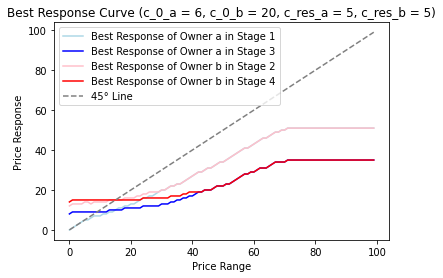

In [ ]:
## Results #### strg + ä expand the codes

parameter_names = ['fair value of raw data',
                   'data restriction',
                   'license value','cost of contract',
                   'price of product', 'alpha', 'quality of product',
                   'utility constant', 'average utility','orders',
                   'total revenue', 'total cost',
                   'profits']

                  #  [p_0_a, c_res_a, p_lic_a, c_0_a, price_s_a, alpha_a,
                  #          theta_1_value_a, u_bar_a, m1, pr1]

# Parameters
# fair value of raw data
p_0_a = 10
p_0_b = 10

# policy factor: data restriction
c_res_a = 5
c_res_b = 5

# Variables
# license
p_lic_a = 4
p_lic_b = 4

# scale alpha
alpha_a = 2000 # thinking about the final payment to the Developers
alpha_b = 2000

# cost of contract
c_0_a = 6 # adjust the cost to raise the functionality
c_0_b = 20

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# prices
# price_s_a = 40
price_s_b = 40

pricelist1 = []
maxpricelist1 = []

# Get the optimal price of A
# for jj in range(0, 100, 20):
  # price_s_b = jj

for jj in range(0, 100, 1):
  price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  maxpricelist1.append(range(0, 100, 1)[indx])

# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
# plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxpricelist2 = []
for jj in range(0, 100, 1):
  price_s_a = maxpricelist1[jj]
  pricelist2 = []
  for ii in range(0, 100, 1):
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    pricelist2.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist2 == np.max(pricelist2))[0].tolist()[0]
  maxpricelist2.append(range(0, 100, 1)[indx])

# # Plot the curve for the 2nd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner b in Stage 2',
#             '45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

'''
In the next stage, firm a will respond to the actions of firm b.
'''
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxpricelist3 = []
for jj in range(0, 100, 1):
  price_s_b = maxpricelist2[jj]
  pricelist3 = []
  for ii in range(0, 100, 1):
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist3.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist3 == np.max(pricelist3))[0].tolist()[0]
  maxpricelist3.append(range(0, 100, 1)[indx])

# # Plot the curve for the 3rd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 20, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
# plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner a in Stage 3',
#             'Best Response of Owner b in Stage 2','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

# Further, firm b will adjust the prices too.
'''
In the next stage, firm a will respond to the actions of firm b.
'''
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxpricelist4 = []
for jj in range(0, 100, 1):
  price_s_a = maxpricelist3[jj]
  pricelist4 = []
  for ii in range(0, 100, 1):
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist4.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist4 == np.max(pricelist4))[0].tolist()[0]
  maxpricelist4.append(range(0, 100, 1)[indx])

# Plot the curve for the 4th stage
plt.title('Best Response Curve (c_0_a = 6, c_0_b = 20, c_res_a = 5, c_res_b = 5)')
plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
plt.plot(range(0, 100, 1), maxpricelist2, 'pink')
plt.plot(range(0, 100, 1), maxpricelist4, 'red')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
         linestyle = '--')
plt.legend(['Best Response of Owner a in Stage 1',
            'Best Response of Owner a in Stage 3',
            'Best Response of Owner b in Stage 2',
            'Best Response of Owner b in Stage 4',
            '45° Line'])
plt.xlabel('Price Range')
plt.ylabel('Price Response')
plt.show() ## 19 min.

Show the equilibrium prices

In [ ]:
# According to the fixed point theorem, there must be at least one equilibrium
# for continuous functions on a certain range. From the graph above we can
# observe that the best responses of Owner b in Stage 2 and 4 intersect with
# each other on the 45° line. We take this as the equilibrium point.
# Need to check: the best responses of b on this price hold the same.

brtable01 = pd.DataFrame({'Continuity': list(range(0, 100, 1)),
                          'BR_a_1': maxpricelist1, 'BR_a_3': maxpricelist3,
                          'BR_b_2': maxpricelist2, 'BR_b_4': maxpricelist4})
eq_brtable01 = brtable01[(brtable01['BR_b_2'] == brtable01['BR_b_4'])
& (brtable01['BR_a_1'] == brtable01['BR_a_3'])]
eq_b = int(eq_brtable01['BR_b_2'])
eq_a = int(eq_brtable01['BR_a_1'])
eq_a, eq_b

Backward Induction: Knowing the equilibrium prices, we check which cost of contract is optimal given different cost of restriction. Since the restriction is only decided by the local government, we only check the behavior of the firm at this stage.

The same simulation method with respect to fixed equilibrium prices and flexible costs of contract.

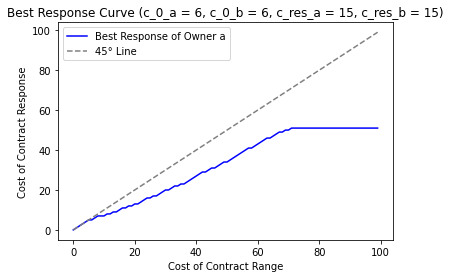

In [ ]:
# former cost of contract for the equilibrium: c_0_a = 6, c_0_b = 20.

# cost of contract
# c_0_a = 6 # adjust the cost to raise the functionality
c_0_b = 20

# functionality
# theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
# theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# equilibrium prices
price_s_a = eq_a
price_s_b = eq_b

# pricelist1 = []
# maxpricelist1 = []
contractlist1 = []
maxcontractlist1 = []

# Get the optimal cost of contract of a

for jj in range(0, 100, 1):
  c_0_b = jj
  contractlist1 = []
  for ii in range(0, 100, 1):
    c_0_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
      theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    contractlist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(contractlist1 == np.max(contractlist1))[0].tolist()[0]
  maxcontractlist1.append(range(0, 100, 1)[indx])

plt.title('Best Response Curve (eq_a = 10, eq_b = 15)')
plt.plot(range(0, 100, 1), maxcontractlist1, color = 'blue')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
plt.legend(['Best Response of Owner a','45° Line'])
plt.xlabel('Cost of Contract Range')
plt.ylabel('Cost of Contract Response')
plt.show()

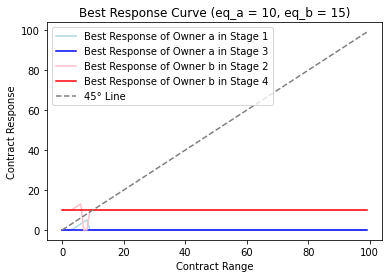

In [ ]:
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxcontractlist2 = []
for jj in range(0, 100, 1):
  c_0_a = maxcontractlist1[jj]
  contractlist2 = []
  for ii in range(0, 100, 1):
    c_0_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
      theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    contractlist2.append(pr2)

    # Find which cost of contract could bring the maximum profit
  indx = np.where(contractlist2 == np.max(contractlist2))[0].tolist()[0]
  maxcontractlist2.append(range(0, 100, 1)[indx])

# # Plot the curve for the 2nd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner b in Stage 2',
#             '45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

maxcontractlist3 = []
for jj in range(0, 100, 1):
  c_0_b = maxcontractlist2[jj]
  contractlist3 = []
  for ii in range(0, 100, 1):
    c_0_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
      theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    contractlist3.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(contractlist3 == np.max(contractlist3))[0].tolist()[0]
  maxcontractlist3.append(range(0, 100, 1)[indx])

# # Plot the curve for the 3rd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 20, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
# plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner a in Stage 3',
#             'Best Response of Owner b in Stage 2','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

# Further, firm b will adjust the prices too.

maxcontractlist4 = []
for jj in range(0, 100, 1):
  c_0_a = maxcontractlist3[jj]
  contractlist4 = [] # check from here!!
  for ii in range(0, 100, 1):
    c_0_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
      theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    contractlist4.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(contractlist4 == np.max(contractlist4))[0].tolist()[0]
  maxcontractlist4.append(range(0, 100, 1)[indx])

# Plot the curve for the 4th stage
plt.title('Best Response Curve (eq_a = 10, eq_b = 15)')
plt.plot(range(0, 100, 1), maxcontractlist1, 'lightblue')
plt.plot(range(0, 100, 1), maxcontractlist3, 'blue')
plt.plot(range(0, 100, 1), maxcontractlist2, 'pink')
plt.plot(range(0, 100, 1), maxcontractlist4, 'red')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
         linestyle = '--')
plt.legend(['Best Response of Owner a in Stage 1',
            'Best Response of Owner a in Stage 3',
            'Best Response of Owner b in Stage 2',
            'Best Response of Owner b in Stage 4',
            '45° Line'])
plt.xlabel('Contract Range')
plt.ylabel('Contract Response')
plt.show() ## 20 min.

In [ ]:
brtable02 = pd.DataFrame({'Continuity': list(range(0, 100, 1)),
                          'BR_a_1': maxcontractlist1,
                          'BR_a_3': maxcontractlist3,
                          'BR_b_2': maxcontractlist2,
                          'BR_b_4': maxcontractlist4})
eq_brtable02 = brtable02[(brtable02['BR_b_2'] == brtable02['BR_b_4'])
& (brtable02['BR_a_1'] == brtable02['BR_a_3'])
& (brtable02['BR_b_2'] == brtable02['Continuity'])]

In [ ]:
eq_brtable02

Continuity  BR_a_1  BR_a_3  BR_b_2  BR_b_4
10          10       0       0      10      10

In [ ]:
eq_c_0_b = int(eq_brtable02['BR_b_2'])
eq_c_0_a = int(eq_brtable02['BR_a_1'])
(eq_c_0_a, eq_c_0_b)

(0, 10)

Now, suppose both regions know the best response prices and costs of contract of the firms, the regions need to reconsider the restriction levels. Here we try to find the optimal costs of restrictions.

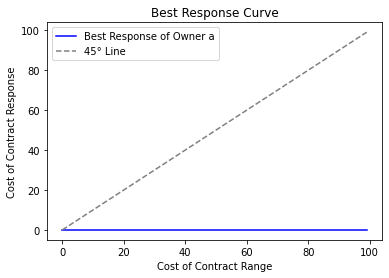

In [ ]:
# Equilibrium prices of (a, b):  (10, 15)
# Equilibrium costs of contract: (0,  10)

# Former data restrictions
c_res_a = 5
c_res_b = 5

# eq. prices
price_s_a = 10
price_s_b = 15

# eq. cost of contract
c_0_a = 0
c_0_b = 10

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# pricelist1 = []
# maxpricelist1 = []
# contractlist1 = []
# maxcontractlist1 = []
reslist1 = []
maxreslist1 = []

# Get the optimal cost of contract of a

for jj in range(0, 100, 1):
  c_res_b = jj
  contractlist1 = []
  for ii in range(0, 100, 1):
    c_res_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    reslist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(reslist1 == np.max(reslist1))[0].tolist()[0]
  maxreslist1.append(range(0, 100, 1)[indx])

plt.title('Best Response Curve')
plt.plot(range(0, 100, 1), maxreslist1, color = 'blue')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
plt.legend(['Best Response of Owner a','45° Line'])
plt.xlabel('Cost of Contract Range')
plt.ylabel('Cost of Contract Response')
plt.show()

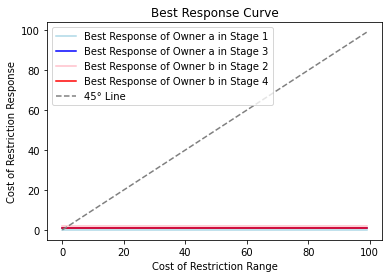

In [ ]:
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxreslist2 = []
for jj in range(0, 100, 1):
  c_res_a = maxreslist1[jj]
  reslist2 = []
  for ii in range(0, 100, 1):
    c_res_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    reslist2.append(pr2)

    # Find which cost of contract could bring the maximum profit
  indx = np.where(reslist2 == np.max(reslist2))[0].tolist()[0]
  maxreslist2.append(range(0, 100, 1)[indx])

# # Plot the curve for the 2nd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner b in Stage 2',
#             '45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

maxreslist3 = []
for jj in range(0, 100, 1):
  c_res_b = maxreslist2[jj]
  reslist3 = []
  for ii in range(0, 100, 1):
    c_res_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    reslist3.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(reslist3 == np.max(reslist3))[0].tolist()[0]
  maxreslist3.append(range(0, 100, 1)[indx])

# # Plot the curve for the 3rd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 20, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
# plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner a in Stage 3',
#             'Best Response of Owner b in Stage 2','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

# Further, firm b will adjust the prices too.

maxreslist4 = []
for jj in range(0, 100, 1):
  c_res_a = maxreslist3[jj]
  reslist4 = [] # check from here!!
  for ii in range(0, 100, 1):
    c_res_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    reslist4.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(reslist4 == np.max(reslist4))[0].tolist()[0]
  maxreslist4.append(range(0, 100, 1)[indx])

# Plot the curve for the 4th stage
plt.title('Best Response Curve')
plt.plot(range(0, 100, 1), maxreslist1, 'lightblue')
plt.plot(range(0, 100, 1), maxreslist3, 'blue')
plt.plot(range(0, 100, 1), maxreslist2, 'pink')
plt.plot(range(0, 100, 1), maxreslist4, 'red')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
         linestyle = '--')
plt.legend(['Best Response of Owner a in Stage 1',
            'Best Response of Owner a in Stage 3',
            'Best Response of Owner b in Stage 2',
            'Best Response of Owner b in Stage 4',
            '45° Line'])
plt.xlabel('Cost of Restriction Range')
plt.ylabel('Cost of Restriction Response')
plt.show() ## 9 min.

In [ ]:
brtable03 = pd.DataFrame({'Continuity': list(range(0, 100, 1)),
                          'BR_a_1': maxreslist1,
                          'BR_a_3': maxreslist3,
                          'BR_b_2': maxreslist2,
                          'BR_b_4': maxreslist4})
eq_brtable03 = brtable03[(brtable03['BR_b_2'] == brtable03['BR_b_4'])
& (brtable03['BR_a_1'] == brtable03['BR_a_3'])
& (brtable03['BR_b_2'] == brtable03['Continuity'])]

In [ ]:
brtable03 # no equilibrium? we take (1, 1) as they are the final round results

Continuity  BR_a_1  BR_a_3  BR_b_2  BR_b_4
0            0       0       1       2       1
1            1       0       1       2       1
2            2       0       1       2       1
3            3       0       1       2       1
4            4       0       1       2       1
..         ...     ...     ...     ...     ...
95          95       0       1       2       1
96          96       0       1       2       1
97          97       0       1       2       1
98          98       0       1       2       1
99          99       0       1       2       1

[100 rows x 5 columns]

Therefore, the data restrictions of (A, B) should be (1, 1).

The equilibrium outcome and the total profits:

In [ ]:
## Results

# eq. prices
p_0_a = 10
p_0_b = 15
# eq. costs of contract
c_0_a = 0
c_0_b = 10
# eq. costs of data restriction
c_res_a = 1
c_res_b = 1

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

buy = []
buy2= []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [p_0_a, c_res_a, p_lic_a, c_0_a, price_s_a, alpha_a,
                           theta_1_value_a, u_bar_a, round(np.mean(utili_a),2), m1,
                           m1 * price_s_a, alpha_a * deltap_a(c_0_a) + m1 * c_res_a, pr1]
parameter_values_list_b = [p_0_b, c_res_b, p_lic_b, c_0_b, price_s_b, alpha_b,
                           theta_1_value_b, u_bar_b, round(np.mean(utili_b),2), m2,
                           m2 * price_s_b, alpha_b * deltap_a(c_0_b) + m2 * c_res_b, pr2]
Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})
Table_param

Parameters and Outcomes  Region A  Region B
0   fair value of raw data     10.00     15.00
1         data restriction      1.00      1.00
2            license value      4.00      4.00
3         cost of contract      0.00     10.00
4         price of product     10.00     15.00
5                    alpha   2000.00   2000.00
6       quality of product      0.80     20.80
7         utility constant    100.00    100.00
8          average utility     90.75     92.09
9                   orders   4673.00   5327.00
10           total revenue  46730.00  79905.00
11              total cost   4673.00  45327.00
12                 profits  42057.00  34578.00

In [ ]:
42057.00 + 34578.00

76635.0

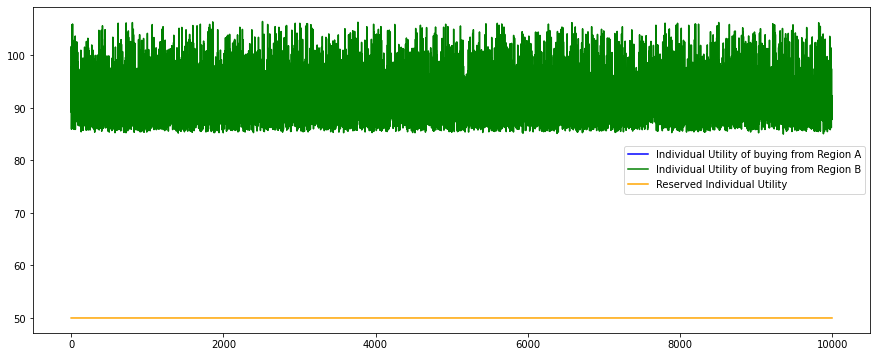

In [ ]:
plt.figure(figsize = [15,6])
plt.plot(utili_a,'blue')
plt.plot(utili_b,'green')
plt.plot(ru,'orange')
plt.legend(['Individual Utility of buying from Region A',
            'Individual Utility of buying from Region B',
            'Reserved Individual Utility'])
plt.show()

Price Grid under certain conditions

In [ ]:
# Parameters
# policy factor: data restriction
c_res_a = 1
c_res_b = 1

# cost of contract
c_0_a = 0
c_0_b = 10

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# prices
profit_a_set = []
profit_b_set = []
total_pr_set = []

for pricea00 in range(0, 100, 5):
  for priceb01 in range(0, 100, 5):
    price_s_a = pricea00
    price_s_b = priceb01

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    total_pr = pr1 + pr2

    profit_a_set.append(pr1)
    profit_b_set.append(pr2)
    total_pr_set.append(total_pr)

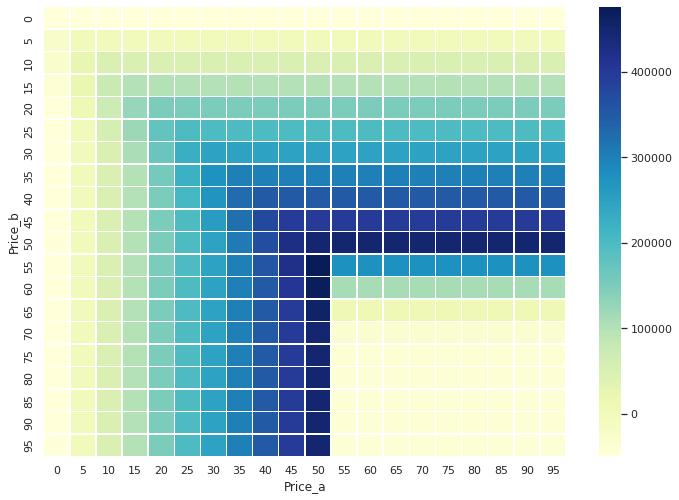

In [ ]:
price_b_000 = list(range(0, 100, 5)) * 20 # inside, b
price_a_000 = np.repeat(list(range(0, 100, 5)), len(list(range(0, 100, 5)))).tolist() # outside, a
heatmap01t = pd.DataFrame({'Price_a': price_a_000, 'Price_b': price_b_000,
              'Profit_total': total_pr_set})
heatmap01 = heatmap01t.pivot("Price_b", "Price_a", "Profit_total")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(heatmap01, cmap="YlGnBu", linewidths=.5) # annot = 'True, fmt="d"
plt.show()

The equilibrium point is indeed not the point of the maximum total profit.

#### Case 2: Different costs of restriction

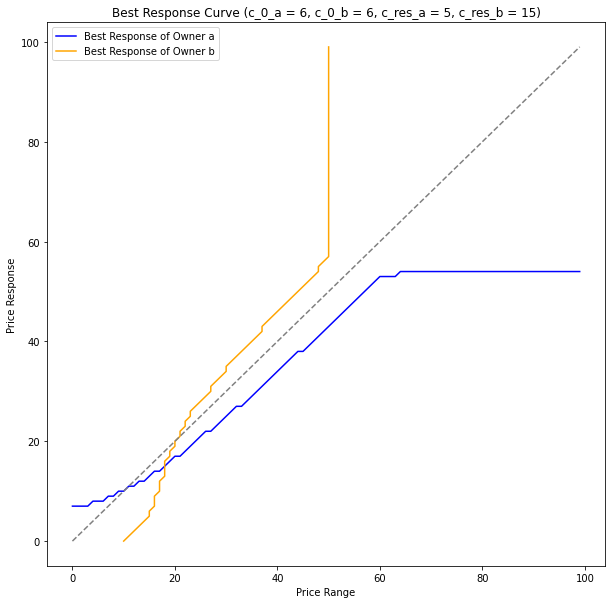

In [ ]:
## Step1: Check the best response of one firm.

# Parameters
# fair value of raw data
p_0_a = 10
p_0_b = 10

# policy factor: data restriction
c_res_a = 5
c_res_b = 15

# Variables
# license
p_lic_a = 4
p_lic_b = 4

# scale alpha
alpha_a = 2000 # thinking about the final payment to the Developers
alpha_b = 2000

# cost of contract # Note: Here is the change!!
c_0_a = 6 # adjust the cost to raise the functionality
c_0_b = 6

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# prices
# price_s_a = 40
price_s_b = 40

pricelist1 = []
maxpricelist1 = []

# number of customers
n_customers = 10000


# Get the optimal price
for jj in range(0, 100, 1):
  price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  maxpricelist1.append(range(0, 100, 1)[indx])

# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()


## Step2: Check the best response of the other firm.
# Keeping the parameters the same

# prices
price_s_a = 40
# price_s_b = 40

pricelist1 = []
# maxpricelist1 = []
maxpricelist2 = []

# number of customers
n_customers = 10000


# Get the optimal price
for jj in range(0, 100, 1):
  price_s_a = jj
  # price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    # price_s_a = ii
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []

    # pricelist1.append(pr1)
    pricelist1.append(pr2)


    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  # maxpricelist1.append(range(0, 100, 1)[indx])
  maxpricelist2.append(range(0, 100, 1)[indx])


# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
# plt.plot(range(0, 100, 1), maxpricelist2, color = 'orange')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()


## Step 3: Plot the graph of best response curves.
plt.figure(figsize=(10,10))
plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 15)')
plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
plt.plot(maxpricelist2, range(0, 100, 1), color = 'orange')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')

# plt.legend(['Best Response of Owner a','45° Line'])
plt.legend(['Best Response of Owner a','Best Response of Owner b'])

plt.xlabel('Price Range')
plt.ylabel('Price Response')
plt.show()

In [ ]:
## Step 4: Find the equilibrium / equilibria.
sum_table = pd.DataFrame({'maxpricelist1': maxpricelist1,
                         'maxpricelist2': maxpricelist2,
                         'price range': list(range(0, 100, 1))})
# Check the 45° line.
# sum_table[sum_table['maxpricelist1'] == sum_table['price range']]

# Find the tuples: One approach to get the equilibrium.
# (sum_table['maxpricelist1'][0], sum_table['maxpricelist2'][0])

# generate the tuples
tuple01 = []
tuple02 = []

for i in range(0, len(sum_table)):
    # tuple01.append((sum_table['maxpricelist1'][i], sum_table['maxpricelist2'][i]))
    # tuple02.append((sum_table['maxpricelist2'][i], sum_table['maxpricelist1'][i]))
    tuple01.append((sum_table['price range'][i], sum_table['maxpricelist1'][i]))
    tuple02.append((sum_table['maxpricelist2'][i], sum_table['price range'][i]))


sum_table['tuple_1_2'] = tuple01
sum_table['tuple_2_1'] = tuple02

# sum_table[sum_table['tuple_1_2'] == sum_table['tuple_2_1']] # too strict
# sum_table[5:25]
# sum_table[sum_table['maxpricelist2'] == sum_table['price range']]

# find the tuple in the intersection
ints_list = [i for i in sum_table['tuple_1_2'].tolist() if i in sum_table['tuple_2_1'].tolist()]
ints_list # Equilibrium / Equilibria, (firm b, firm a)

[(18, 15)]

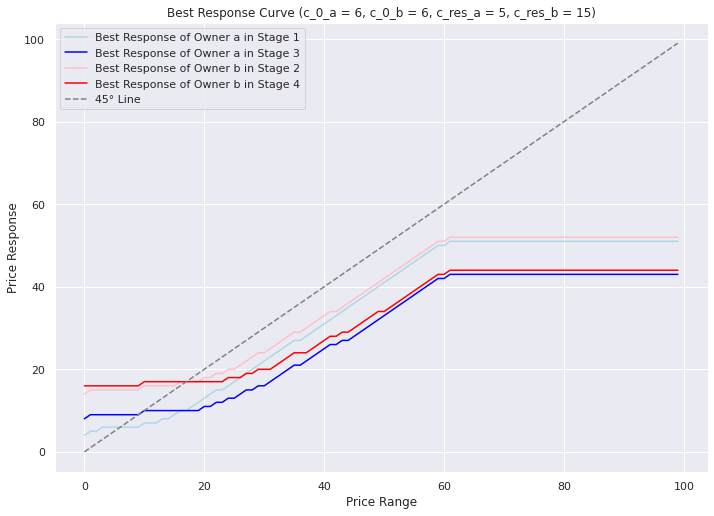

In [ ]:
## Results

# Parameters
# fair value of raw data
p_0_a = 10
p_0_b = 10

# policy factor: data restriction
c_res_a = 5
c_res_b = 15

# Variables
# license
p_lic_a = 4
p_lic_b = 4

# scale alpha
alpha_a = 2000 # thinking about the final payment to the Developers
alpha_b = 2000

# cost of contract
c_0_a = 6 # adjust the cost to raise the functionality
c_0_b = 6

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# prices
# price_s_a = 40
price_s_b = 40

pricelist1 = []
maxpricelist1 = []

# number of customers
# n_customers = 1000 # may be too small
n_customers = 10000

# Get the optimal price of A
# for jj in range(0, 100, 20):
  # price_s_b = jj

for jj in range(0, 100, 1):
  price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  maxpricelist1.append(range(0, 100, 1)[indx])

# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
# plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxpricelist2 = []
for jj in range(0, 100, 1):
  price_s_a = maxpricelist1[jj]
  pricelist2 = []
  for ii in range(0, 100, 1):
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    pricelist2.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist2 == np.max(pricelist2))[0].tolist()[0]
  maxpricelist2.append(range(0, 100, 1)[indx])

# # Plot the curve for the 2nd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner b in Stage 2',
#             '45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

'''
In the next stage, firm a will respond to the actions of firm b.
'''
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxpricelist3 = []
for jj in range(0, 100, 1):
  price_s_b = maxpricelist2[jj]
  pricelist3 = []
  for ii in range(0, 100, 1):
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist3.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist3 == np.max(pricelist3))[0].tolist()[0]
  maxpricelist3.append(range(0, 100, 1)[indx])

# # Plot the curve for the 3rd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
# plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner a in Stage 3',
#             'Best Response of Owner b in Stage 2','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

# Further, firm b will adjust the prices too.
'''
In the next stage, firm a will respond to the actions of firm b.
'''
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxpricelist4 = []
for jj in range(0, 100, 1):
  price_s_a = maxpricelist3[jj]
  pricelist4 = []
  for ii in range(0, 100, 1):
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist4.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist4 == np.max(pricelist4))[0].tolist()[0]
  maxpricelist4.append(range(0, 100, 1)[indx])

# Plot the curve for the 4th stage
plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 15)')
plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
plt.plot(range(0, 100, 1), maxpricelist2, 'pink')
plt.plot(range(0, 100, 1), maxpricelist4, 'red')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
         linestyle = '--')
plt.legend(['Best Response of Owner a in Stage 1',
            'Best Response of Owner a in Stage 3',
            'Best Response of Owner b in Stage 2',
            'Best Response of Owner b in Stage 4',
            '45° Line'])
plt.xlabel('Price Range')
plt.ylabel('Price Response')
plt.show()

In [ ]:
brtable01 = pd.DataFrame({'Continuity': list(range(0, 100, 1)),
                          'BR_a_1': maxpricelist1, 'BR_a_3': maxpricelist3,
                          'BR_b_2': maxpricelist2, 'BR_b_4': maxpricelist4})
eq_brtable01 = brtable01[(brtable01['BR_b_2'] == brtable01['BR_b_4'])
& (brtable01['BR_a_1'] == brtable01['BR_a_3'])]
eq_brtable01

Continuity  BR_a_1  BR_a_3  BR_b_2  BR_b_4
16          16      10      10      17      17
17          17      10      10      17      17

In [ ]:
eq_a = 10
eq_b = 17

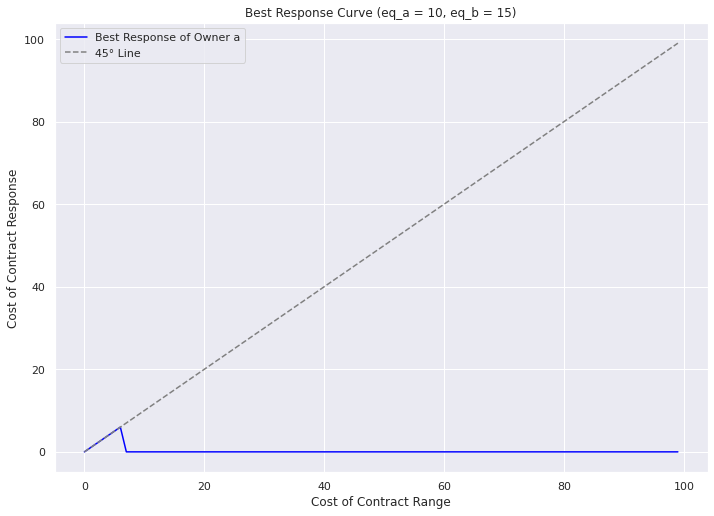

In [ ]:
# former cost of contract for the equilibrium: c_0_a = 6, c_0_b = 6.

# cost of contract
# c_0_a = 6 # adjust the cost to raise the functionality
c_0_b = 6

# functionality
# theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
# theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# equilibrium prices
price_s_a = eq_a
price_s_b = eq_b

# pricelist1 = []
# maxpricelist1 = []
contractlist1 = []
maxcontractlist1 = []

# Get the optimal cost of contract of a

for jj in range(0, 100, 1):
  c_0_b = jj
  contractlist1 = []
  for ii in range(0, 100, 1):
    c_0_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
      theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    contractlist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(contractlist1 == np.max(contractlist1))[0].tolist()[0]
  maxcontractlist1.append(range(0, 100, 1)[indx])

plt.title('Best Response Curve') #  (eq_a = 10, eq_b = 17)
plt.plot(range(0, 100, 1), maxcontractlist1, color = 'blue')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
plt.legend(['Best Response of Owner a','45° Line'])
plt.xlabel('Cost of Contract Range')
plt.ylabel('Cost of Contract Response')
plt.show()

Text(0, 0.5, 'Contract Response')

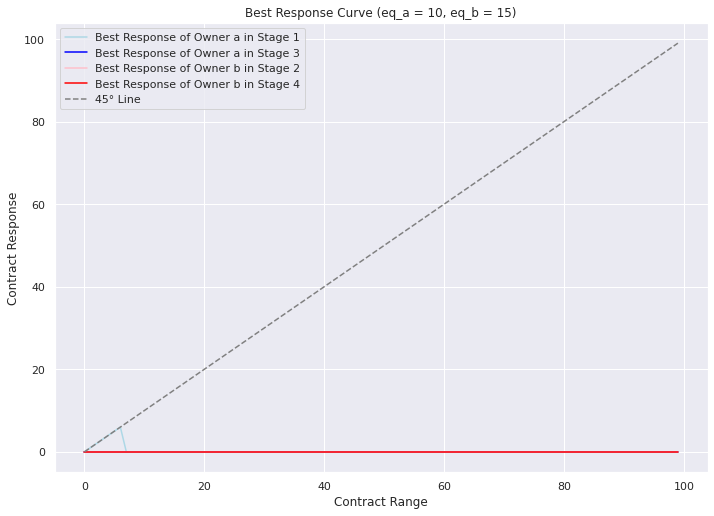

In [ ]:
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxcontractlist2 = []
for jj in range(0, 100, 1):
  c_0_a = maxcontractlist1[jj]
  contractlist2 = []
  for ii in range(0, 100, 1):
    c_0_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
      theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    contractlist2.append(pr2)

    # Find which cost of contract could bring the maximum profit
  indx = np.where(contractlist2 == np.max(contractlist2))[0].tolist()[0]
  maxcontractlist2.append(range(0, 100, 1)[indx])

# # Plot the curve for the 2nd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner b in Stage 2',
#             '45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

maxcontractlist3 = []
for jj in range(0, 100, 1):
  c_0_b = maxcontractlist2[jj]
  contractlist3 = []
  for ii in range(0, 100, 1):
    c_0_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
      theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    contractlist3.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(contractlist3 == np.max(contractlist3))[0].tolist()[0]
  maxcontractlist3.append(range(0, 100, 1)[indx])

# # Plot the curve for the 3rd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 20, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
# plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner a in Stage 3',
#             'Best Response of Owner b in Stage 2','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

# Further, firm b will adjust the prices too.

maxcontractlist4 = []
for jj in range(0, 100, 1):
  c_0_a = maxcontractlist3[jj]
  contractlist4 = [] # check from here!!
  for ii in range(0, 100, 1):
    c_0_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
      theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    contractlist4.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(contractlist4 == np.max(contractlist4))[0].tolist()[0]
  maxcontractlist4.append(range(0, 100, 1)[indx])

# Plot the curve for the 4th stage
plt.title('Best Response Curve (eq_a = 10, eq_b = 15)')
plt.plot(range(0, 100, 1), maxcontractlist1, 'lightblue')
plt.plot(range(0, 100, 1), maxcontractlist3, 'blue')
plt.plot(range(0, 100, 1), maxcontractlist2, 'pink')
plt.plot(range(0, 100, 1), maxcontractlist4, 'red')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
         linestyle = '--')
plt.legend(['Best Response of Owner a in Stage 1',
            'Best Response of Owner a in Stage 3',
            'Best Response of Owner b in Stage 2',
            'Best Response of Owner b in Stage 4',
            '45° Line'])
plt.xlabel('Contract Range')
plt.ylabel('Contract Response')
# plt.show() ## 20 min.

In [ ]:
brtable02 = pd.DataFrame({'Continuity': list(range(0, 100, 1)),
                          'BR_a_1': maxcontractlist1,
                          'BR_a_3': maxcontractlist3,
                          'BR_b_2': maxcontractlist2,
                          'BR_b_4': maxcontractlist4})
eq_brtable02 = brtable02[(brtable02['BR_b_2'] == brtable02['BR_b_4'])
& (brtable02['BR_a_1'] == brtable02['BR_a_3'])
& (brtable02['BR_b_2'] == brtable02['Continuity'])]

In [ ]:
eq_brtable02

Continuity  BR_a_1  BR_a_3  BR_b_2  BR_b_4
0           0       0       0       0       0

In [ ]:
eq_c_0_a = 0
eq_c_0_b = 0

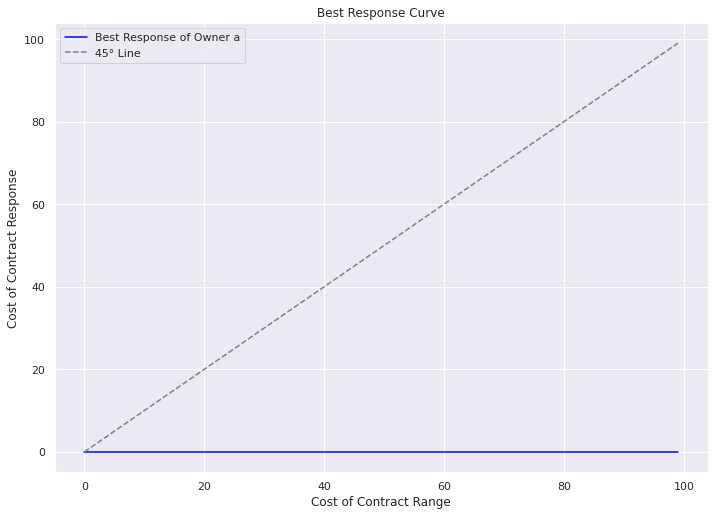

In [ ]:
# Equilibrium prices of (a, b):  (10, 17)
# Equilibrium costs of contract: (0,  0)

# Former data restrictions
c_res_a = 5
c_res_b = 5

# eq. prices
price_s_a = 10
price_s_b = 17

# eq. cost of contract
c_0_a = eq_c_0_a
c_0_b = eq_c_0_b

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# pricelist1 = []
# maxpricelist1 = []
# contractlist1 = []
# maxcontractlist1 = []
reslist1 = []
maxreslist1 = []

# Get the optimal cost of contract of a

for jj in range(0, 100, 1):
  c_res_b = jj
  contractlist1 = []
  for ii in range(0, 100, 1):
    c_res_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    reslist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(reslist1 == np.max(reslist1))[0].tolist()[0]
  maxreslist1.append(range(0, 100, 1)[indx])

plt.title('Best Response Curve')
plt.plot(range(0, 100, 1), maxreslist1, color = 'blue')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
plt.legend(['Best Response of Owner a','45° Line'])
plt.xlabel('Cost of Contract Range')
plt.ylabel('Cost of Contract Response')
plt.show()

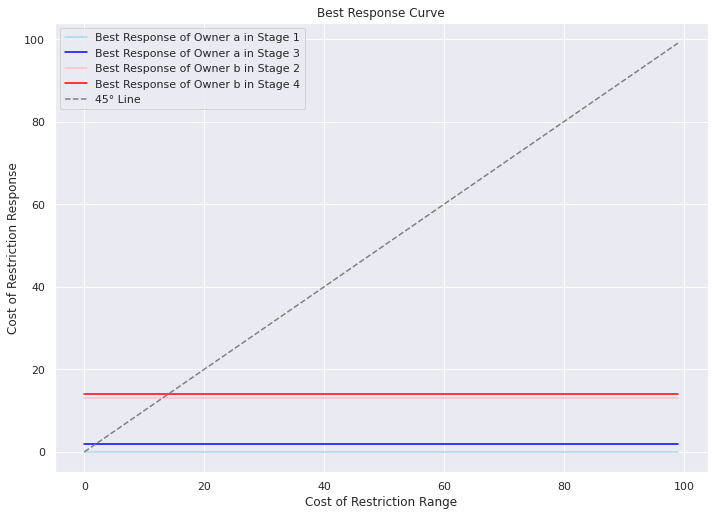

In [ ]:
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxreslist2 = []
for jj in range(0, 100, 1):
  c_res_a = maxreslist1[jj]
  reslist2 = []
  for ii in range(0, 100, 1):
    c_res_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    reslist2.append(pr2)

    # Find which cost of contract could bring the maximum profit
  indx = np.where(reslist2 == np.max(reslist2))[0].tolist()[0]
  maxreslist2.append(range(0, 100, 1)[indx])

# # Plot the curve for the 2nd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner b in Stage 2',
#             '45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

maxreslist3 = []
for jj in range(0, 100, 1):
  c_res_b = maxreslist2[jj]
  reslist3 = []
  for ii in range(0, 100, 1):
    c_res_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    reslist3.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(reslist3 == np.max(reslist3))[0].tolist()[0]
  maxreslist3.append(range(0, 100, 1)[indx])

# # Plot the curve for the 3rd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 20, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
# plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner a in Stage 3',
#             'Best Response of Owner b in Stage 2','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

# Further, firm b will adjust the prices too.

maxreslist4 = []
for jj in range(0, 100, 1):
  c_res_a = maxreslist3[jj]
  reslist4 = [] # check from here!!
  for ii in range(0, 100, 1):
    c_res_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    reslist4.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(reslist4 == np.max(reslist4))[0].tolist()[0]
  maxreslist4.append(range(0, 100, 1)[indx])

# Plot the curve for the 4th stage
plt.title('Best Response Curve')
plt.plot(range(0, 100, 1), maxreslist1, 'lightblue')
plt.plot(range(0, 100, 1), maxreslist3, 'blue')
plt.plot(range(0, 100, 1), maxreslist2, 'pink')
plt.plot(range(0, 100, 1), maxreslist4, 'red')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
         linestyle = '--')
plt.legend(['Best Response of Owner a in Stage 1',
            'Best Response of Owner a in Stage 3',
            'Best Response of Owner b in Stage 2',
            'Best Response of Owner b in Stage 4',
            '45° Line'])
plt.xlabel('Cost of Restriction Range')
plt.ylabel('Cost of Restriction Response')
plt.show() ## 9 min.

In [ ]:
brtable03 = pd.DataFrame({'Continuity': list(range(0, 100, 1)),
                          'BR_a_1': maxreslist1,
                          'BR_a_3': maxreslist3,
                          'BR_b_2': maxreslist2,
                          'BR_b_4': maxreslist4})
eq_brtable03 = brtable03[(brtable03['BR_b_2'] == brtable03['BR_b_4'])
& (brtable03['BR_a_1'] == brtable03['BR_a_3'])
& (brtable03['BR_b_2'] == brtable03['Continuity'])]

In [ ]:
brtable03

Continuity  BR_a_1  BR_a_3  BR_b_2  BR_b_4
0            0       0       2      13      14
1            1       0       2      13      14
2            2       0       2      13      14
3            3       0       2      13      14
4            4       0       2      13      14
..         ...     ...     ...     ...     ...
95          95       0       2      13      14
96          96       0       2      13      14
97          97       0       2      13      14
98          98       0       2      13      14
99          99       0       2      13      14

[100 rows x 5 columns]

In [ ]:
## Results

# eq. prices
p_0_a = 10
p_0_b = 17
# eq. costs of contract
c_0_a = 0
c_0_b = 0
# eq. costs of data restriction
c_res_a = 2
c_res_b = 14

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

buy = []
buy2= []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [p_0_a, c_res_a, p_lic_a, c_0_a, price_s_a, alpha_a,
                           theta_1_value_a, u_bar_a, round(np.mean(utili_a),2), m1,
                           m1 * price_s_a, alpha_a * deltap_a(c_0_a) + m1 * c_res_a, pr1]
parameter_values_list_b = [p_0_b, c_res_b, p_lic_b, c_0_b, price_s_b, alpha_b,
                           theta_1_value_b, u_bar_b, round(np.mean(utili_b),2), m2,
                           m2 * price_s_b, alpha_b * deltap_a(c_0_b) + m2 * c_res_b, pr2]
Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})
Table_param

Parameters and Outcomes  Region A  Region B
0   fair value of raw data     10.00     17.00
1         data restriction      2.00     14.00
2            license value      4.00      4.00
3         cost of contract      0.00      0.00
4         price of product     10.00     17.00
5                    alpha   2000.00   2000.00
6       quality of product      0.80      0.80
7         utility constant    100.00    100.00
8          average utility     91.24     90.15
9                   orders   6696.00   3304.00
10           total revenue  66960.00  56168.00
11              total cost  13392.00  46256.00
12                 profits  53568.00   9912.00

In [ ]:
53568.00 + 9912

63480.0

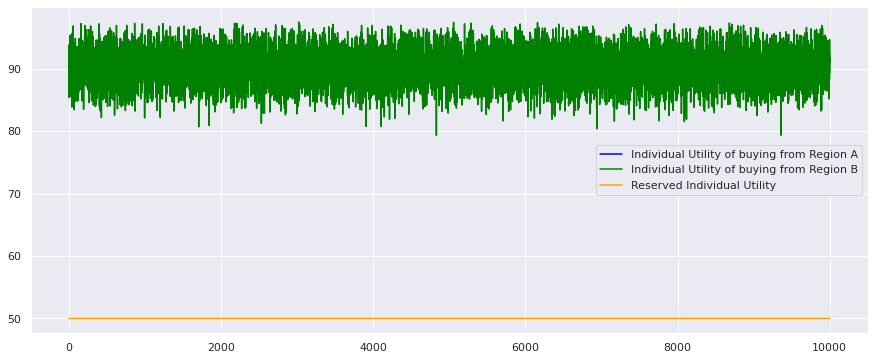

In [ ]:
plt.figure(figsize = [15,6])
plt.plot(utili_a,'blue')
plt.plot(utili_b,'green')
plt.plot(ru,'orange')
plt.legend(['Individual Utility of buying from Region A',
            'Individual Utility of buying from Region B',
            'Reserved Individual Utility'])
plt.show()

In [ ]:
# Parameters
# policy factor: data restriction
c_res_a = 0
c_res_b = 0

# cost of contract
c_0_a = 2
c_0_b = 14

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# prices
profit_a_set = []
profit_b_set = []
total_pr_set = []

for pricea00 in range(0, 100, 5):
  for priceb01 in range(0, 100, 5):
    price_s_a = pricea00
    price_s_b = priceb01

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    total_pr = pr1 + pr2

    profit_a_set.append(pr1)
    profit_b_set.append(pr2)
    total_pr_set.append(total_pr)

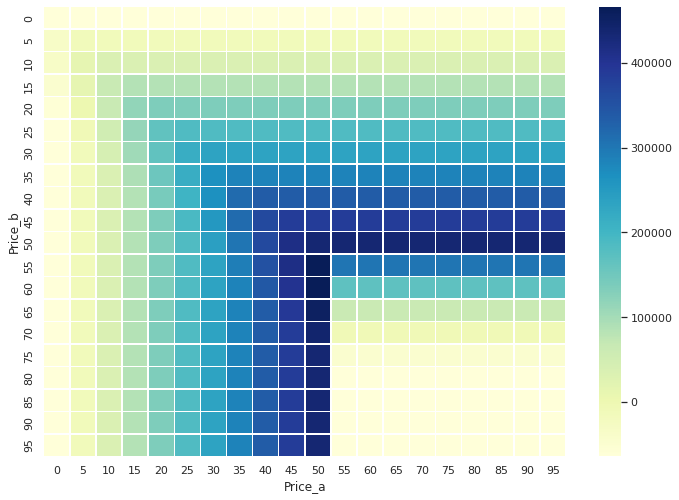

In [ ]:
price_b_000 = list(range(0, 100, 5)) * 20 # inside, b
price_a_000 = np.repeat(list(range(0, 100, 5)), len(list(range(0, 100, 5)))).tolist() # outside, a
heatmap01t = pd.DataFrame({'Price_a': price_a_000, 'Price_b': price_b_000,
              'Profit_total': total_pr_set})
heatmap01 = heatmap01t.pivot("Price_b", "Price_a", "Profit_total")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(heatmap01, cmap="YlGnBu", linewidths=.5) # annot = 'True, fmt="d"
plt.show()

#### Case 3: Different costs of restriction and costs of contract

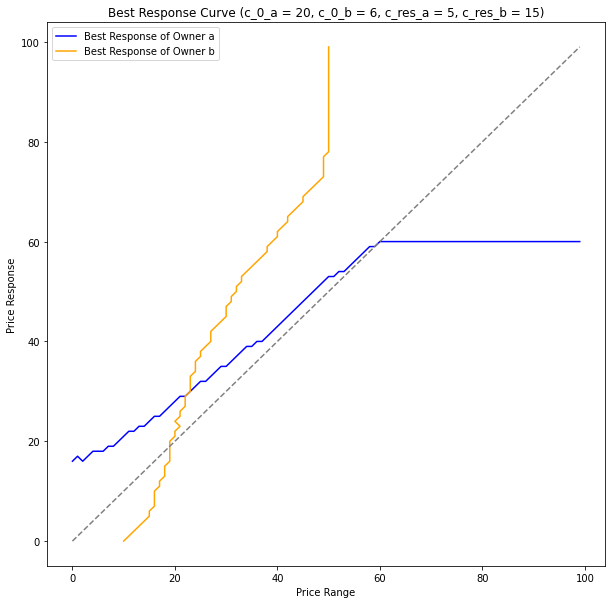

In [ ]:
## Step1: Check the best response of one firm.

# Parameters
# fair value of raw data
p_0_a = 10
p_0_b = 10

# policy factor: data restriction
c_res_a = 5
c_res_b = 15

# Variables
# license
p_lic_a = 4
p_lic_b = 4

# scale alpha
alpha_a = 2000 # thinking about the final payment to the Developers
alpha_b = 2000

# cost of contract # Note: Here is the change!!
c_0_a = 20 # adjust the cost to raise the functionality
c_0_b = 6

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# prices
# price_s_a = 40
price_s_b = 40

pricelist1 = []
maxpricelist1 = []

# number of customers
n_customers = 10000


# Get the optimal price
for jj in range(0, 100, 1):
  price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  maxpricelist1.append(range(0, 100, 1)[indx])

# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()


## Step2: Check the best response of the other firm.
# Keeping the parameters the same

# prices
price_s_a = 40
# price_s_b = 40

pricelist1 = []
# maxpricelist1 = []
maxpricelist2 = []

# number of customers
n_customers = 10000


# Get the optimal price
for jj in range(0, 100, 1):
  price_s_a = jj
  # price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    # price_s_a = ii
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []

    # pricelist1.append(pr1)
    pricelist1.append(pr2)


    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  # maxpricelist1.append(range(0, 100, 1)[indx])
  maxpricelist2.append(range(0, 100, 1)[indx])


# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
# plt.plot(range(0, 100, 1), maxpricelist2, color = 'orange')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()


## Step 3: Plot the graph of best response curves.
plt.figure(figsize=(10,10))
plt.title('Best Response Curve (c_0_a = 20, c_0_b = 6, c_res_a = 5, c_res_b = 15)')
plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
plt.plot(maxpricelist2, range(0, 100, 1), color = 'orange')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')

plt.legend(['Best Response of Owner a','Best Response of Owner b'])
plt.xlabel('Price Range')
plt.ylabel('Price Response')
plt.show()

In [ ]:
## Step 4: Find the equilibrium / equilibria.
sum_table = pd.DataFrame({'maxpricelist1': maxpricelist1,
                         'maxpricelist2': maxpricelist2,
                         'price range': list(range(0, 100, 1))})
# Check the 45° line.
# sum_table[sum_table['maxpricelist1'] == sum_table['price range']]

# Find the tuples: One approach to get the equilibrium.
# (sum_table['maxpricelist1'][0], sum_table['maxpricelist2'][0])

# generate the tuples
tuple01 = []
tuple02 = []

for i in range(0, len(sum_table)):
    # tuple01.append((sum_table['maxpricelist1'][i], sum_table['maxpricelist2'][i]))
    # tuple02.append((sum_table['maxpricelist2'][i], sum_table['maxpricelist1'][i]))
    tuple01.append((sum_table['price range'][i], sum_table['maxpricelist1'][i]))
    tuple02.append((sum_table['maxpricelist2'][i], sum_table['price range'][i]))


sum_table['tuple_1_2'] = tuple01
sum_table['tuple_2_1'] = tuple02

# sum_table[sum_table['tuple_1_2'] == sum_table['tuple_2_1']] # too strict
# sum_table[5:25]
# sum_table[sum_table['maxpricelist2'] == sum_table['price range']]

# find the tuple in the intersection
ints_list = [i for i in sum_table['tuple_1_2'].tolist() if i in sum_table['tuple_2_1'].tolist()]
ints_list # Equilibrium / Equilibria, (firm b, firm a)

[(22, 29), (23, 30)]

In [ ]:
# 1107 Trial of an interactive plot # simpler version, n_customers = 1000

def f(c_res_a = 5, c_res_b = 5):

    # # policy factor: data restriction
    # c_res_a = 5
    # c_res_b = 5

    # scale alpha
    alpha_a = 2000 # thinking about the final payment to the Developers
    alpha_b = 2000

    # cost of contract
    c_0_a = 20 # adjust the cost to raise the functionality
    c_0_b = 6

    # fundamental
    theta_1_bar_a_value = 0.8
    theta_1_bar_b_value = 0.8

    # functionality
    theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
    theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

    # utility constant
    u_bar_a = 100
    u_bar_b = 100

    # prices
    price_s_b = 40

    pricelist1 = []
    maxpricelist1 = []

    # number of customers
    n_customers = 1000

    # Get the optimal price
    for jj in range(0, 100, 1):
        price_s_b = jj
        pricelist1 = []
        for ii in range(0, 100, 1):
            price_s_a = ii

            # utilities
            utili_a = []
            utili_b = []
            for i in range(0, n_customers):
              utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
              utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

            # reserved utility
            ru = np.random.uniform(50, 50, n_customers) # homogenous

            # buy randomly from one company if the utilities are the same
            bin = np.random.binomial(1, 0.5, n_customers)

            buy = []
            buy2= []

            for i in range(0, n_customers):
              if ru[i] <= max(utili_a[i], utili_b[i]):
                if utili_a[i] > utili_b[i]:
                  buy.append(1)
                elif utili_a[i] < utili_b[i]:
                  buy2.append(1)
                else:
                  buy.append(bin[i])
                  buy2.append(1-bin[i])
              else:
                pass

            m1 = sum(buy)
            m2 = sum(buy2)
            pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
            pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
            # pricelist1 = []
            pricelist1.append(pr1)

            # Find which price could bring the maximum profit
        indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
        maxpricelist1.append(range(0, 100, 1)[indx])

    # For the other firm: Keeping the parameters the same

    # prices
    price_s_a = 40

    pricelist1 = []
    # maxpricelist1 = []
    maxpricelist2 = []

    # number of customers
    n_customers = 1000

    # Get the optimal price
    for jj in range(0, 100, 1):
        price_s_a = jj
        # price_s_b = jj
        pricelist1 = []
        for ii in range(0, 100, 1):
            # price_s_a = ii
            price_s_b = ii

            # utilities
            utili_a = []
            utili_b = []
            for i in range(0, n_customers):
              utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
              utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

            # reserved utility
            ru = np.random.uniform(50, 50, n_customers) # homogenous

            # buy randomly from one company if the utilities are the same
            bin = np.random.binomial(1, 0.5, n_customers)

            buy = []
            buy2= []

            for i in range(0, n_customers):
              if ru[i] <= max(utili_a[i], utili_b[i]):
                if utili_a[i] > utili_b[i]:
                  buy.append(1)
                elif utili_a[i] < utili_b[i]:
                  buy2.append(1)
                else:
                  buy.append(bin[i])
                  buy2.append(1-bin[i])
              else:
                pass

            m1 = sum(buy)
            m2 = sum(buy2)
            pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
            pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
            # pricelist1 = []

            # pricelist1.append(pr1)
            pricelist1.append(pr2)

          # Find which price could bring the maximum profit
        indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
        # maxpricelist1.append(range(0, 100, 1)[indx])
        maxpricelist2.append(range(0, 100, 1)[indx])

    plt.figure(figsize=(10,10))
    plt.title('Best Response Curve (c_0_a = 20, c_0_b = 6)')
    plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
    plt.plot(maxpricelist2, range(0, 100, 1), color = 'orange')
    plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')

    # plt.legend(['Best Response of Owner a','45° Line'])
    plt.legend(['Best Response of Owner a','Best Response of Owner b'])

    plt.xlabel('Price Range')
    plt.ylabel('Price Response')
    plt.show() # difference in two maxpricelists is the result of the Binomial dist.

interactive_plot = interactive(f, c_res_a=(0, 20, 0.5), c_res_b=(0, 20, 0.5))

output = interactive_plot.children[-1]
output.layout.height = '1500px' # height of the output box
interactive_plot

interactive(children=(FloatSlider(value=5.0, description='c_res_a', max=20.0, step=0.5), FloatSlider(value=5.0…

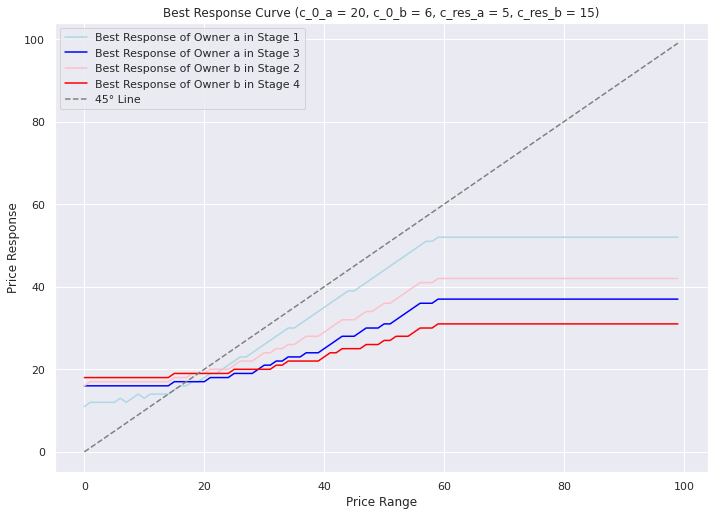

In [ ]:
# Parameters
# fair value of raw data
p_0_a = 10
p_0_b = 10

# policy factor: data restriction
c_res_a = 5
c_res_b = 15

# Variables
# license
p_lic_a = 4
p_lic_b = 4

# scale alpha
alpha_a = 2000 # thinking about the final payment to the Developers
alpha_b = 2000

# cost of contract
c_0_a = 20 # adjust the cost to raise the functionality
c_0_b = 6

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# prices
# price_s_a = 40
price_s_b = 40

pricelist1 = []
maxpricelist1 = []

# number of customers
# n_customers = 1000 # may be too small
n_customers = 10000

# Get the optimal price of A
# for jj in range(0, 100, 20):
  # price_s_b = jj

for jj in range(0, 100, 1):
  price_s_b = jj
  pricelist1 = []
  for ii in range(0, 100, 1):
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist1 == np.max(pricelist1))[0].tolist()[0]
  maxpricelist1.append(range(0, 100, 1)[indx])

# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 15, c_res_b = 15)')
# plt.plot(range(0, 100, 1), maxpricelist1, color = 'blue')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
# plt.legend(['Best Response of Owner a','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxpricelist2 = []
for jj in range(0, 100, 1):
  price_s_a = maxpricelist1[jj]
  pricelist2 = []
  for ii in range(0, 100, 1):
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    pricelist2.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist2 == np.max(pricelist2))[0].tolist()[0]
  maxpricelist2.append(range(0, 100, 1)[indx])

# # Plot the curve for the 2nd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner b in Stage 2',
#             '45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

'''
In the next stage, firm a will respond to the actions of firm b.
'''
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxpricelist3 = []
for jj in range(0, 100, 1):
  price_s_b = maxpricelist2[jj]
  pricelist3 = []
  for ii in range(0, 100, 1):
    price_s_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist3.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist3 == np.max(pricelist3))[0].tolist()[0]
  maxpricelist3.append(range(0, 100, 1)[indx])

# # Plot the curve for the 3rd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
# plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner a in Stage 3',
#             'Best Response of Owner b in Stage 2','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

# Further, firm b will adjust the prices too.
'''
In the next stage, firm a will respond to the actions of firm b.
'''
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxpricelist4 = []
for jj in range(0, 100, 1):
  price_s_a = maxpricelist3[jj]
  pricelist4 = []
  for ii in range(0, 100, 1):
    price_s_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    pricelist4.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(pricelist4 == np.max(pricelist4))[0].tolist()[0]
  maxpricelist4.append(range(0, 100, 1)[indx])

# Plot the curve for the 4th stage
plt.title('Best Response Curve (c_0_a = 20, c_0_b = 6, c_res_a = 5, c_res_b = 15)')
plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
plt.plot(range(0, 100, 1), maxpricelist2, 'pink')
plt.plot(range(0, 100, 1), maxpricelist4, 'red')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
         linestyle = '--')
plt.legend(['Best Response of Owner a in Stage 1',
            'Best Response of Owner a in Stage 3',
            'Best Response of Owner b in Stage 2',
            'Best Response of Owner b in Stage 4',
            '45° Line'])
plt.xlabel('Price Range')
plt.ylabel('Price Response')
plt.show()

In [ ]:
brtable01 = pd.DataFrame({'Continuity': list(range(0, 100, 1)),
                          'BR_a_1': maxpricelist1, 'BR_a_3': maxpricelist3,
                          'BR_b_2': maxpricelist2, 'BR_b_4': maxpricelist4})
eq_brtable01 = brtable01[(brtable01['BR_b_2'] == brtable01['BR_b_4'])
& (brtable01['BR_a_1'] == brtable01['BR_a_3'])]
eq_brtable01

Continuity  BR_a_1  BR_a_3  BR_b_2  BR_b_4
18          18      17      17      19      19
19          19      17      17      19      19

In [ ]:
eq_a = 17
eq_b = 19

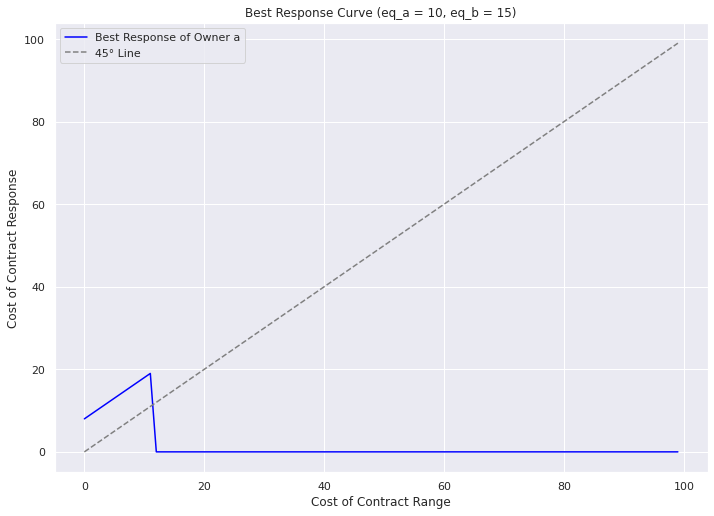

In [ ]:
# former cost of contract for the equilibrium: c_0_a = 6, c_0_b = 6.

# cost of contract
# c_0_a = 6 # adjust the cost to raise the functionality
c_0_b = 6

# functionality
# theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
# theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# equilibrium prices
price_s_a = eq_a
price_s_b = eq_b

# pricelist1 = []
# maxpricelist1 = []
contractlist1 = []
maxcontractlist1 = []

# Get the optimal cost of contract of a

for jj in range(0, 100, 1):
  c_0_b = jj
  contractlist1 = []
  for ii in range(0, 100, 1):
    c_0_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
      theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    contractlist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(contractlist1 == np.max(contractlist1))[0].tolist()[0]
  maxcontractlist1.append(range(0, 100, 1)[indx])

plt.title('Best Response Curve (eq_a = 10, eq_b = 15)')
plt.plot(range(0, 100, 1), maxcontractlist1, color = 'blue')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
plt.legend(['Best Response of Owner a','45° Line'])
plt.xlabel('Cost of Contract Range')
plt.ylabel('Cost of Contract Response')
plt.show()

Text(0, 0.5, 'Contract Response')

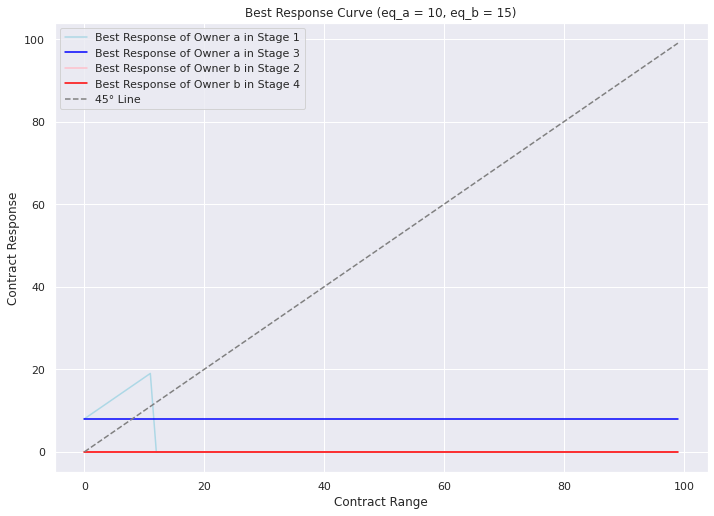

In [ ]:
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxcontractlist2 = []
for jj in range(0, 100, 1):
  c_0_a = maxcontractlist1[jj]
  contractlist2 = []
  for ii in range(0, 100, 1):
    c_0_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
      theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    contractlist2.append(pr2)

    # Find which cost of contract could bring the maximum profit
  indx = np.where(contractlist2 == np.max(contractlist2))[0].tolist()[0]
  maxcontractlist2.append(range(0, 100, 1)[indx])

# # Plot the curve for the 2nd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner b in Stage 2',
#             '45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

maxcontractlist3 = []
for jj in range(0, 100, 1):
  c_0_b = maxcontractlist2[jj]
  contractlist3 = []
  for ii in range(0, 100, 1):
    c_0_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
      theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    contractlist3.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(contractlist3 == np.max(contractlist3))[0].tolist()[0]
  maxcontractlist3.append(range(0, 100, 1)[indx])

# # Plot the curve for the 3rd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 20, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
# plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner a in Stage 3',
#             'Best Response of Owner b in Stage 2','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

# Further, firm b will adjust the prices too.

maxcontractlist4 = []
for jj in range(0, 100, 1):
  c_0_a = maxcontractlist3[jj]
  contractlist4 = [] # check from here!!
  for ii in range(0, 100, 1):
    c_0_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
      theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    contractlist4.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(contractlist4 == np.max(contractlist4))[0].tolist()[0]
  maxcontractlist4.append(range(0, 100, 1)[indx])

# Plot the curve for the 4th stage
plt.title('Best Response Curve (eq_a = 10, eq_b = 15)')
plt.plot(range(0, 100, 1), maxcontractlist1, 'lightblue')
plt.plot(range(0, 100, 1), maxcontractlist3, 'blue')
plt.plot(range(0, 100, 1), maxcontractlist2, 'pink')
plt.plot(range(0, 100, 1), maxcontractlist4, 'red')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
         linestyle = '--')
plt.legend(['Best Response of Owner a in Stage 1',
            'Best Response of Owner a in Stage 3',
            'Best Response of Owner b in Stage 2',
            'Best Response of Owner b in Stage 4',
            '45° Line'])
plt.xlabel('Contract Range')
plt.ylabel('Contract Response')
# plt.show() ## 20 min.

In [ ]:
brtable02 = pd.DataFrame({'Continuity': list(range(0, 100, 1)),
                          'BR_a_1': maxcontractlist1,
                          'BR_a_3': maxcontractlist3,
                          'BR_b_2': maxcontractlist2,
                          'BR_b_4': maxcontractlist4})
eq_brtable02 = brtable02[(brtable02['BR_b_2'] == brtable02['BR_b_4'])
& (brtable02['BR_a_1'] == brtable02['BR_a_3'])
& (brtable02['BR_b_2'] == brtable02['Continuity'])]

In [ ]:
eq_brtable02

Continuity  BR_a_1  BR_a_3  BR_b_2  BR_b_4
0           0       8       8       0       0

In [ ]:
eq_c_0_a = 8
eq_c_0_b = 0

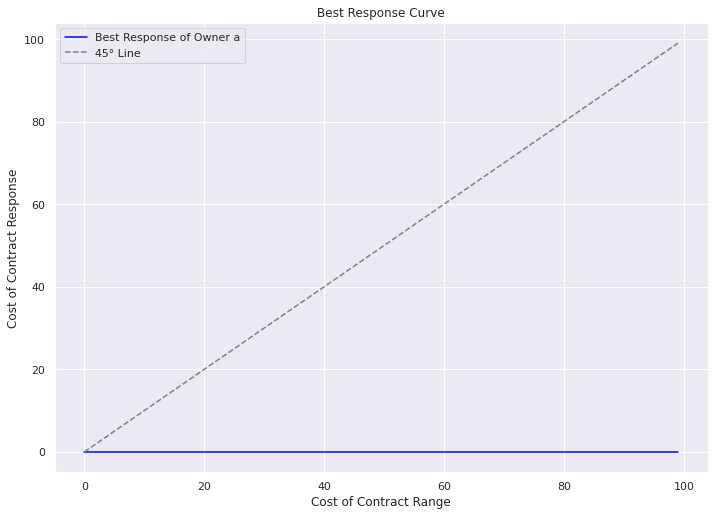

In [ ]:
# Equilibrium prices of (a, b):  (17,19)
# Equilibrium costs of contract: (8,  0)

# Former data restrictions
c_res_a = 5
c_res_b = 5

# eq. prices
price_s_a = eq_a
price_s_b = eq_b

# eq. cost of contract
c_0_a = eq_c_0_a
c_0_b = eq_c_0_b

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# pricelist1 = []
# maxpricelist1 = []
# contractlist1 = []
# maxcontractlist1 = []
reslist1 = []
maxreslist1 = []

# Get the optimal cost of contract of a

for jj in range(0, 100, 1):
  c_res_b = jj
  contractlist1 = []
  for ii in range(0, 100, 1):
    c_res_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    reslist1.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(reslist1 == np.max(reslist1))[0].tolist()[0]
  maxreslist1.append(range(0, 100, 1)[indx])

plt.title('Best Response Curve')
plt.plot(range(0, 100, 1), maxreslist1, color = 'blue')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey', linestyle = '--')
plt.legend(['Best Response of Owner a','45° Line'])
plt.xlabel('Cost of Restriction Range')
plt.ylabel('Cost of Restriction Response')
plt.show()

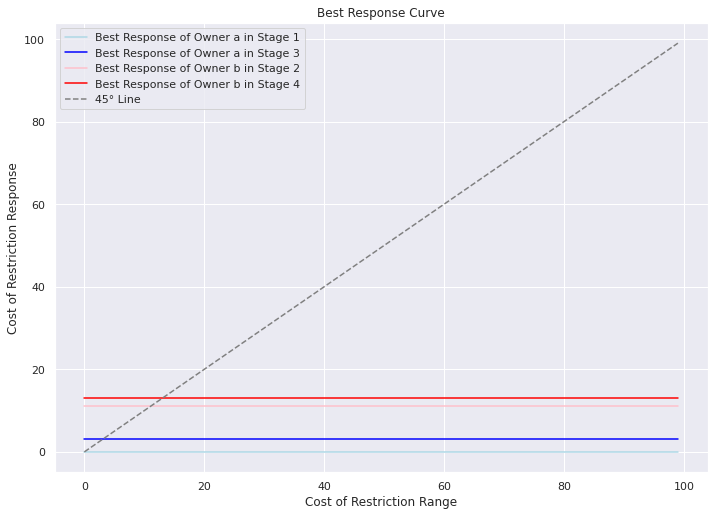

In [ ]:
'''
In the 2nd round, Firm b takes actions according to the best responses of
firm a.
'''
maxreslist2 = []
for jj in range(0, 100, 1):
  c_res_a = maxreslist1[jj]
  reslist2 = []
  for ii in range(0, 100, 1):
    c_res_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    reslist2.append(pr2)

    # Find which cost of contract could bring the maximum profit
  indx = np.where(reslist2 == np.max(reslist2))[0].tolist()[0]
  maxreslist2.append(range(0, 100, 1)[indx])

# # Plot the curve for the 2nd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 6, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner b in Stage 2',
#             '45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

maxreslist3 = []
for jj in range(0, 100, 1):
  c_res_b = maxreslist2[jj]
  reslist3 = []
  for ii in range(0, 100, 1):
    c_res_a = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    reslist3.append(pr1)

    # Find which price could bring the maximum profit
  indx = np.where(reslist3 == np.max(reslist3))[0].tolist()[0]
  maxreslist3.append(range(0, 100, 1)[indx])

# # Plot the curve for the 3rd stage
# plt.title('Best Response Curve (c_0_a = 6, c_0_b = 20, c_res_a = 5, c_res_b = 5)')
# plt.plot(range(0, 100, 1), maxpricelist1, 'lightblue')
# plt.plot(range(0, 100, 1), maxpricelist3, 'blue')
# plt.plot(range(0, 100, 1), maxpricelist2, 'red')
# plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
#          linestyle = '--')
# plt.legend(['Best Response of Owner a in Stage 1',
#             'Best Response of Owner a in Stage 3',
#             'Best Response of Owner b in Stage 2','45° Line'])
# plt.xlabel('Price Range')
# plt.ylabel('Price Response')
# plt.show()

# Further, firm b will adjust the prices too.

maxreslist4 = []
for jj in range(0, 100, 1):
  c_res_a = maxreslist3[jj]
  reslist4 = [] # check from here!!
  for ii in range(0, 100, 1):
    c_res_b = ii

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    # pricelist1 = []
    reslist4.append(pr2)

    # Find which price could bring the maximum profit
  indx = np.where(reslist4 == np.max(reslist4))[0].tolist()[0]
  maxreslist4.append(range(0, 100, 1)[indx])

# Plot the curve for the 4th stage
plt.title('Best Response Curve')
plt.plot(range(0, 100, 1), maxreslist1, 'lightblue')
plt.plot(range(0, 100, 1), maxreslist3, 'blue')
plt.plot(range(0, 100, 1), maxreslist2, 'pink')
plt.plot(range(0, 100, 1), maxreslist4, 'red')
plt.plot(range(0, 100, 1), range(0, 100, 1), color = 'grey',
         linestyle = '--')
plt.legend(['Best Response of Owner a in Stage 1',
            'Best Response of Owner a in Stage 3',
            'Best Response of Owner b in Stage 2',
            'Best Response of Owner b in Stage 4',
            '45° Line'])
plt.xlabel('Cost of Restriction Range')
plt.ylabel('Cost of Restriction Response')
plt.show() ## 9 min.

In [ ]:
brtable03 = pd.DataFrame({'Continuity': list(range(0, 100, 1)),
                          'BR_a_1': maxreslist1,
                          'BR_a_3': maxreslist3,
                          'BR_b_2': maxreslist2,
                          'BR_b_4': maxreslist4})
eq_brtable03 = brtable03[(brtable03['BR_b_2'] == brtable03['BR_b_4'])
& (brtable03['BR_a_1'] == brtable03['BR_a_3'])
& (brtable03['BR_b_2'] == brtable03['Continuity'])]

In [ ]:
brtable03

Continuity  BR_a_1  BR_a_3  BR_b_2  BR_b_4
0            0       0       3      11      13
1            1       0       3      11      13
2            2       0       3      11      13
3            3       0       3      11      13
4            4       0       3      11      13
..         ...     ...     ...     ...     ...
95          95       0       3      11      13
96          96       0       3      11      13
97          97       0       3      11      13
98          98       0       3      11      13
99          99       0       3      11      13

[100 rows x 5 columns]

In [ ]:
## Results

# eq. prices
p_0_a = 17
p_0_b = 19
# eq. costs of contract
c_0_a = 8
c_0_b = 0
# eq. costs of data restriction
c_res_a = 3
c_res_b = 13

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utilities
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

buy = []
buy2= []

for i in range(0, n_customers):
  if ru[i] <= max(utili_a[i], utili_b[i]):
    if utili_a[i] > utili_b[i]:
      buy.append(1)
    elif utili_a[i] < utili_b[i]:
      buy2.append(1)
    else:
      buy.append(bin[i])
      buy2.append(1-bin[i])
  else:
    pass

m1 = sum(buy)
m2 = sum(buy2)
pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)

total_pr = sum([pr1, pr2])
parameter_values_list_a = [p_0_a, c_res_a, p_lic_a, c_0_a, price_s_a, alpha_a,
                           theta_1_value_a, u_bar_a, round(np.mean(utili_a),2), m1,
                           m1 * price_s_a, alpha_a * deltap_a(c_0_a) + m1 * c_res_a, pr1]
parameter_values_list_b = [p_0_b, c_res_b, p_lic_b, c_0_b, price_s_b, alpha_b,
                           theta_1_value_b, u_bar_b, round(np.mean(utili_b),2), m2,
                           m2 * price_s_b, alpha_b * deltap_a(c_0_b) + m2 * c_res_b, pr2]
Table_param = pd.DataFrame({'Parameters and Outcomes': parameter_names,
              'Region A': parameter_values_list_a,
              'Region B': parameter_values_list_b})
Table_param

Parameters and Outcomes   Region A  Region B
0   fair value of raw data      17.00     19.00
1         data restriction       3.00     13.00
2            license value       4.00      4.00
3         cost of contract       8.00      0.00
4         price of product      17.00     19.00
5                    alpha    2000.00   2000.00
6       quality of product      16.80      0.80
7         utility constant     100.00    100.00
8          average utility      89.81     87.66
9                   orders    6583.00   3417.00
10           total revenue  111911.00  64923.00
11              total cost   51749.00  44421.00
12                 profits   60162.00  20502.00

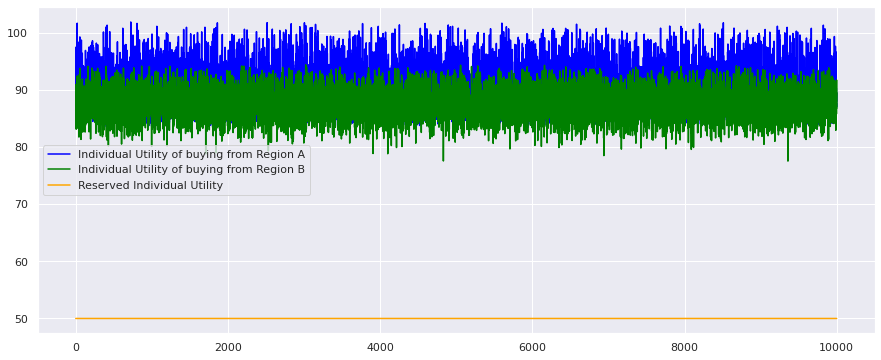

In [ ]:
plt.figure(figsize = [15,6])
plt.plot(utili_a,'blue')
plt.plot(utili_b,'green')
plt.plot(ru,'orange')
plt.legend(['Individual Utility of buying from Region A',
            'Individual Utility of buying from Region B',
            'Reserved Individual Utility'])
plt.show()

In [ ]:
# Parameters
# policy factor: data restriction
c_res_a = 3
c_res_b = 13

# cost of contract
c_0_a = 8
c_0_b = 0

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# prices
profit_a_set = []
profit_b_set = []
total_pr_set = []

for pricea00 in range(0, 100, 5):
  for priceb01 in range(0, 100, 5):
    price_s_a = pricea00
    price_s_b = priceb01

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(alpha_a, m1, price_s_a, p_0_a, c_0_a, p_lic_a, c_res_a)
    pr2 = profit_a(alpha_b, m2, price_s_b, p_0_b, c_0_b, p_lic_b, c_res_b)
    total_pr = pr1 + pr2

    profit_a_set.append(pr1)
    profit_b_set.append(pr2)
    total_pr_set.append(total_pr)

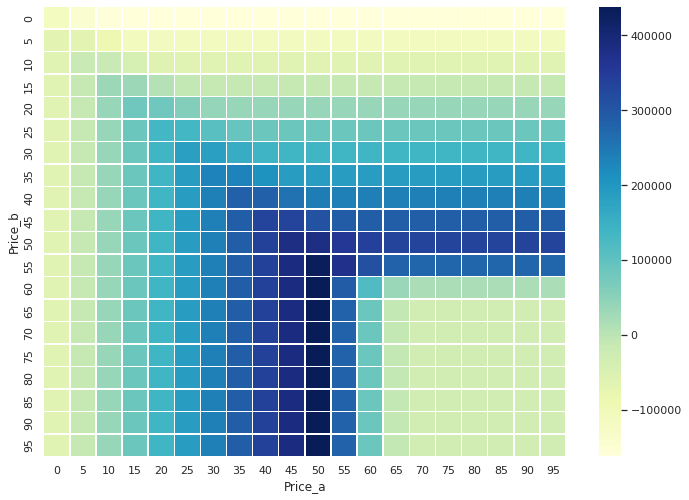

In [ ]:
price_b_000 = list(range(0, 100, 5)) * 20 # inside, b
price_a_000 = np.repeat(list(range(0, 100, 5)), len(list(range(0, 100, 5)))).tolist() # outside, a
heatmap01t = pd.DataFrame({'Price_a': price_a_000, 'Price_b': price_b_000,
              'Profit_total': total_pr_set})
heatmap01 = heatmap01t.pivot("Price_b", "Price_a", "Profit_total")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(heatmap01, cmap="YlGnBu", linewidths=.5) # annot = 'True, fmt="d"
plt.show()

#### Validation of customer distribution

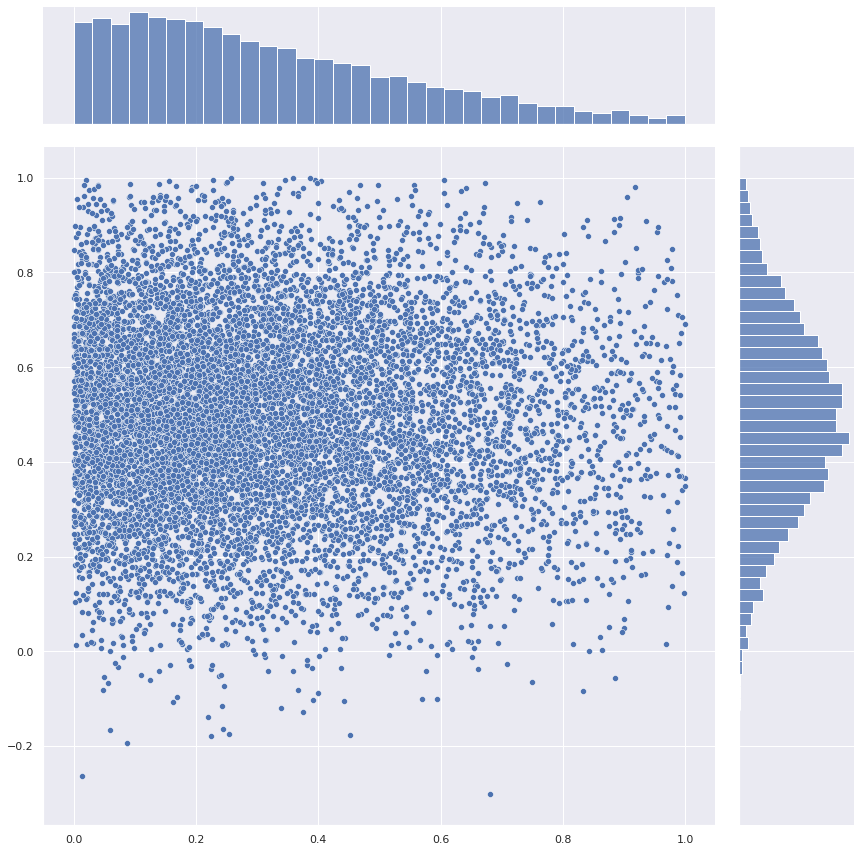

In [ ]:
sns.jointplot(s,st_R, x = "x_j", y="y_j", height = 12)

### Summary of finding equilibrium

In [ ]:
paramlist_new = ['c_res_A_0', 'c_res_B_0', 'c_0_a_0','c_0_b_0', 'p_s_a_br',
                 'p_s_b_br', 'c_0_a_br', 'c_0_b_br', 'c_res_A_br', 'c_res_B_br',
                 'profit_a_br', 'profit_b_br', 'profit_total_br']
case01 = [5, 5, 6, 20, 10, 15, 0, 10, 1, 1, 42057, 34578, 76635]
case02 = [5, 15, 6, 6, 10, 17, 0, 0, 2, 14, 53568, 9912, 63480]
case03 = [5, 15, 20, 6, 17, 19, 8, 0, 3, 13, 60162, 20502, 80664]

In [ ]:
pd.DataFrame(data = {'Case 1': case01, 'Case 2': case02, 'Case 3': case03},
             index = paramlist_new)

Case 1  Case 2  Case 3
c_res_A_0             5       5       5
c_res_B_0             5      15      15
c_0_a_0               6       6      20
c_0_b_0              20       6       6
p_s_a_br             10      10      17
p_s_b_br             15      17      19
c_0_a_br              0       0       8
c_0_b_br             10       0       0
c_res_A_br            1       2       3
c_res_B_br            1      14      13
profit_a_br       42057   53568   60162
profit_b_br       34578    9912   20502
profit_total_br   76635   63480   80664

## Discussion on different forms of the functions in the model

So far we had the assumptions of the linearity of all the functions for simplicity. Here we discuss the possible non-linearity of the functions and check the results.

Discussions on the form of the utility function of the Consumers:

(1) $u_{ij} = \bar{u} + x_j \theta_j + y_j c_{res,j} - p_i$

(2) $u_{ij} = \bar{u} + x_j \frac{1 - e^{-\beta_1 \theta_j}}{\beta_1} + y_j \frac{1 - e^{-\beta_2 c_{res,j}}}{\beta_2} - p_i$

(2') $u_{ij} = \bar{u} + x_j (1 - e^{-\theta_j}) + y_j (1- e^{-c_{res,j}}) + \frac{1}{p_i}$

(3) $u_{ij} = \bar{u} + x_j \frac{\theta_j^{1-\beta_3}}{1-\beta_3} + y_j \frac{c_{res,j}^{1-\beta_4}}{1-\beta_4} - p_i $

(3') $u_{ij} = \bar{u} + x_j \log \theta_j + y_j \log c_{res,j} - p_i$

(4) $u_{ij} = \bar{u} + x_j (\theta_j - \beta_5 \theta_j^2) + y_j (c_{res,j} - \beta_6 c_{res,j}^2) - p_i$

Parameters: $\beta_1, \beta_2, \beta_3, \beta_4, \beta_5, \beta_6 > 0$, $\beta_3, \beta_4 \neq 1$.

Here we depict the relationships between (i) $u_{ij}$ and $\theta_j$; (ii) $u_{ij}$ and $c_{res,j}$, holding $\bar{u}$, $x_j$, $y_j$ and $p_i$ as constants.

Functions mentioned before:

$\theta_i = \bar{\theta}_i + 2 c_{0,i}$

$\Pi_i = m_i (p_i - c_{res,i}) - 2 c_{0,i} $

$m_i = \sum_j \mathbb{1}_{u_{ij} > u_{-ij}} + \sum_j \beta \mathbb{1}_{u_{ij} = u_{-ij}}$

$\beta \sim Bin(1,0.5)$

In [ ]:
np.mean(s), np.mean(st_R)

(0.5024301515183401, 0.013794678807017095)

In [ ]:
## (1) Linear

u_bar0 = np.mean(ru)
# x_j0 = np.mean(s)
# y_j0 = np.mean(st_R)
x_j0 = 1 # 0.5, 0, 1
y_j0 = 0 # 1, 0, -1

p0 = 20 # example

c_0_a_list = list(range(60)) # step = 1
theta_1_bar0 = 0.8
theta0_list = []
for inv in c_0_a_list:
  theta0_list.append(theta_func(theta_1_bar0, inv))

c_res0_list = [0, 5, 10, 15, 20] # data restriction level
u0_list = [] # utility of a Consumer
for res in c_res0_list:
  for theta0 in theta0_list:
    u0_list.append(u_bar0 + x_j0 * theta0 + y_j0 * res - p0)

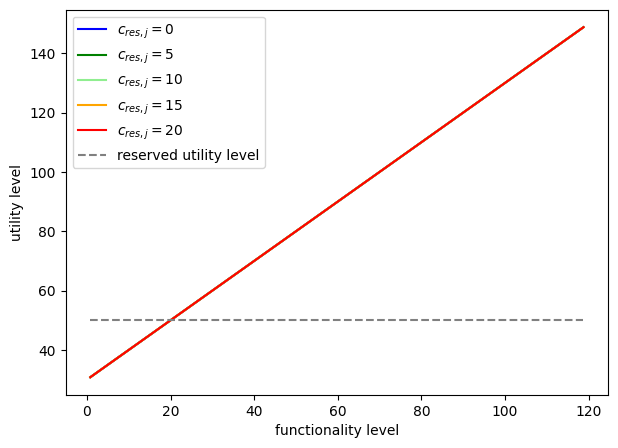

In [ ]:
# np.reshape(u0_list, (5, 60))[0] # res = 0
# np.reshape(u0_list, (5, 60))[1] # res = 5
# u_bar0 + x_j0 * theta0_list[1] + y_j0 * 5 - p0
plt.figure(figsize = [7,5])
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[0], color = 'blue')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[1], color = 'green')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[2], color = 'lightgreen')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[3], color = 'orange')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[4], color = 'red')
plt.plot(theta0_list, [50] * 60, linestyle = '--', color = 'grey')
plt.legend(['$c_{res,j} = 0$', '$c_{res,j} = 5$', '$c_{res,j} = 10$',
            '$c_{res,j} = 15$', '$c_{res,j} = 20$', 'reserved utility level'])
# plt.yticks(np.arange(30, 90, 10))
plt.xlabel('functionality level')
plt.ylabel('utility level')
plt.show()

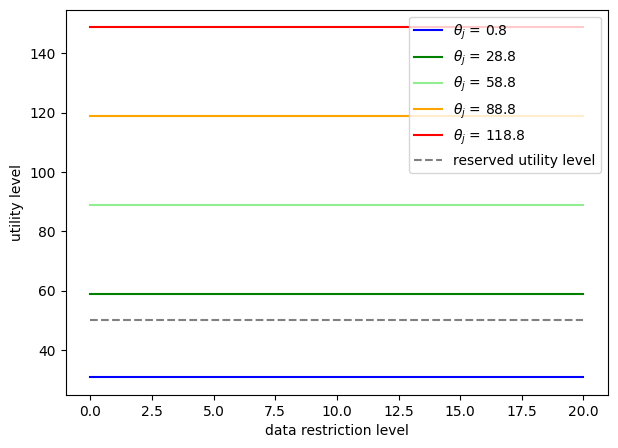

In [ ]:
# np.reshape(u0_list, (5, 60)).T[0] # theta = theta0_list[0] = 0.8
# np.reshape(u0_list, (5, 60)).T[59] # theta = theta0_list[59] = 118.8
plt.figure(figsize = [7,5])
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[0], color = 'blue')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[14], color = 'green')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[29], color = 'lightgreen')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[44], color = 'orange')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[59], color = 'red')
plt.plot(c_res0_list, [50] * 5, linestyle = '--', color = 'grey')
plt.legend([r'$\theta_j$' + ' = ' + str(theta0_list[0]),
            r'$\theta_j$' + ' = ' + str(theta0_list[14]),
            r'$\theta_j$' + ' = ' + str(theta0_list[29]),
            r'$\theta_j$' + ' = ' + str(theta0_list[44]),
            r'$\theta_j$' + ' = ' + str(theta0_list[59]),
            'reserved utility level'],
           loc = 'upper right')
plt.xlabel('data restriction level')
plt.ylabel('utility level')
# plt.yticks(np.arange(30, 90, 10))
plt.show()

In [ ]:
## (2) CARA Utility Function with risk-aversion

# u_bar0 = np.mean(ru)
# x_j0 = np.mean(s)
# y_j0 = np.mean(st_R)
# p0 = 20 # example

c_0_a_list = list(range(60)) # step = 1
theta_1_bar0 = 0.8
theta0_list = []
for inv in c_0_a_list:
  theta0_list.append(theta_func(theta_1_bar0, inv))

c_res0_list = [0, 5, 10, 15, 20] # data restriction level
u0_list = [] # utility of a Consumer

# Parameters for the utility functions
## aleph > 0 for risk-aversion
## keeping reserved utility level unchanged
aleph1 = 0.01
aleph2 = 0.01

for res in c_res0_list:
  for theta0 in theta0_list:
    u0_list.append(u_bar0 + x_j0 * (1 - np.exp(-aleph1 * theta0))/aleph1
                    + y_j0 * (1 - np.exp(-aleph2 * res))/aleph2 - p0)

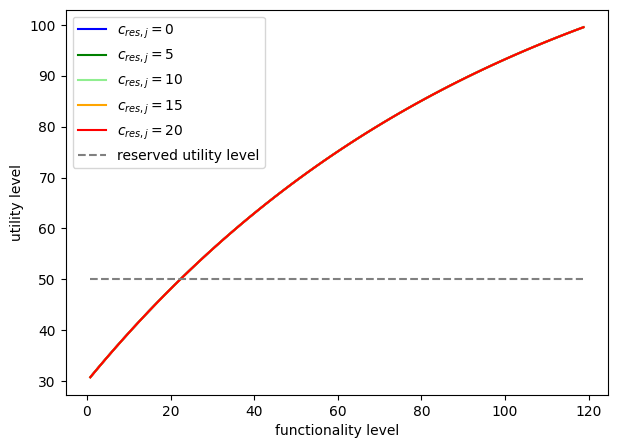

In [ ]:
plt.figure(figsize = [7,5])
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[0], color = 'blue')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[1], color = 'green')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[2], color = 'lightgreen')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[3], color = 'orange')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[4], color = 'red')
plt.plot(theta0_list, [50] * 60, linestyle = '--', color = 'grey')
plt.legend(['$c_{res,j} = 0$', '$c_{res,j} = 5$', '$c_{res,j} = 10$',
            '$c_{res,j} = 15$', '$c_{res,j} = 20$', 'reserved utility level'])
# plt.yticks(np.arange(30, 90, 10))
plt.xlabel('functionality level')
plt.ylabel('utility level')
plt.show()

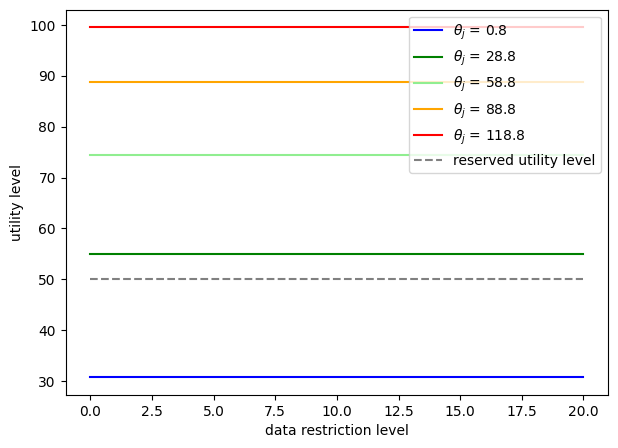

In [ ]:
plt.figure(figsize = [7,5])
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[0], color = 'blue')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[14], color = 'green')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[29], color = 'lightgreen')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[44], color = 'orange')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[59], color = 'red')
plt.plot(c_res0_list, [50] * 5, linestyle = '--', color = 'grey')
plt.legend([r'$\theta_j$' + ' = ' + str(theta0_list[0]),
            r'$\theta_j$' + ' = ' + str(theta0_list[14]),
            r'$\theta_j$' + ' = ' + str(theta0_list[29]),
            r'$\theta_j$' + ' = ' + str(theta0_list[44]),
            r'$\theta_j$' + ' = ' + str(theta0_list[59]),
            'reserved utility level'],
           loc = 'upper right')
plt.xlabel('data restriction level')
plt.ylabel('utility level')
plt.show()

In [ ]:
## (3) CRRA utility function. $\eta > 0$ for risk-aversion.
## $\eta = 1$ for ln function.

# u_bar0 = np.mean(ru)
# x_j0 = np.mean(s)
# y_j0 = np.mean(st_R)
# p0 = 20 # example

c_0_a_list = list(range(60)) # step = 1
theta_1_bar0 = 0.8
theta0_list = []
for inv in c_0_a_list:
  theta0_list.append(theta_func(theta_1_bar0, inv))

c_res0_list = [0, 5, 10, 15, 20] # data restriction level
u0_list = [] # utility of a Consumer

# Parameters for the utility functions
## eta > 0 for risk-aversion
## keeping reserved utility level unchanged
## 0.0 cannot be raised to a negative power
eta1 = 0.2
eta2 = 0.2

# for res in c_res0_list:
#   for theta0 in theta0_list:
#     u0_list.append(u_bar0 + x_j0 * np.log(theta0)
#                     + y_j0 * np.log(res) - p0)

for res in c_res0_list:
  for theta0 in theta0_list:
    u0_list.append(u_bar0 + x_j0 * (theta0 ** (1 - eta1)) / (1 - eta1)
                    + y_j0 * (res ** (1 - eta2)) / (1 - eta2)  - p0)

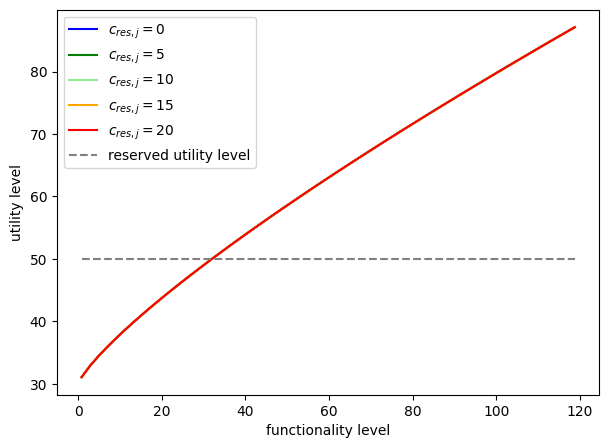

In [ ]:
plt.figure(figsize = [7,5])
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[0], color = 'blue')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[1], color = 'green')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[2], color = 'lightgreen')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[3], color = 'orange')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[4], color = 'red')
plt.plot(theta0_list, [50] * 60, linestyle = '--', color = 'grey')
plt.legend(['$c_{res,j} = 0$', '$c_{res,j} = 5$', '$c_{res,j} = 10$',
            '$c_{res,j} = 15$', '$c_{res,j} = 20$', 'reserved utility level'])
plt.xlabel('functionality level')
plt.ylabel('utility level')
plt.show()

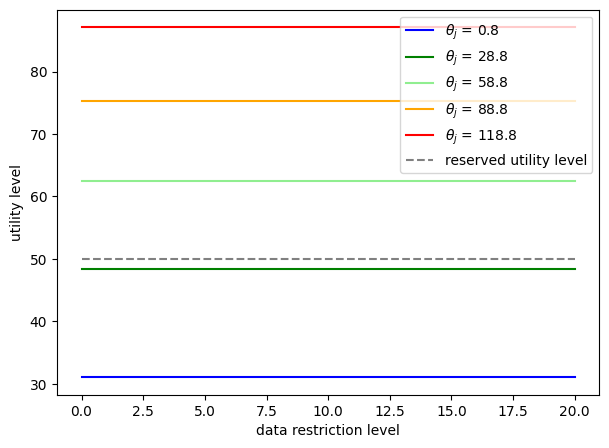

In [ ]:
plt.figure(figsize = [7,5])
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[0], color = 'blue')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[14], color = 'green')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[29], color = 'lightgreen')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[44], color = 'orange')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[59], color = 'red')
plt.plot(c_res0_list, [50] * 5, linestyle = '--', color = 'grey')
plt.legend([r'$\theta_j$' + ' = ' + str(theta0_list[0]),
            r'$\theta_j$' + ' = ' + str(theta0_list[14]),
            r'$\theta_j$' + ' = ' + str(theta0_list[29]),
            r'$\theta_j$' + ' = ' + str(theta0_list[44]),
            r'$\theta_j$' + ' = ' + str(theta0_list[59]),
            'reserved utility level'],
           loc = 'upper right')
plt.xlabel('data restriction level')
plt.ylabel('utility level')
plt.show()

Economic implications of the CARA and the CRRA utility function: Consumers are more risk-averse with respect to functionality, i.e. the marginal utility decreases as the product gains more functionality. For those who prefer higher data restriction level, this works for the same. For those who dislike data restrictions, ...

In [ ]:
## (4) Quadratic Utility

# u_bar0 = np.mean(ru)
# x_j0 = np.mean(s)
# y_j0 = np.mean(st_R)
# p0 = 20 # example

c_0_a_list = list(range(60)) # step = 1
theta_1_bar0 = 0.8
theta0_list = []
for inv in c_0_a_list:
  theta0_list.append(theta_func(theta_1_bar0, inv))

c_res0_list = [0, 5, 10, 15, 20] # data restriction level
u0_list = [] # utility of a Consumer

# Parameters for the utility functions
## beta_5 > 0, beta_6 > 0;
beta_5 = 0.01
beta_6 = 0.01

for res in c_res0_list:
  for theta0 in theta0_list:
    u0_list.append(u_bar0 + x_j0 * (theta0 - beta_5 * theta0**2)
                    + y_j0 * (res - beta_6 * res**2)  - p0)

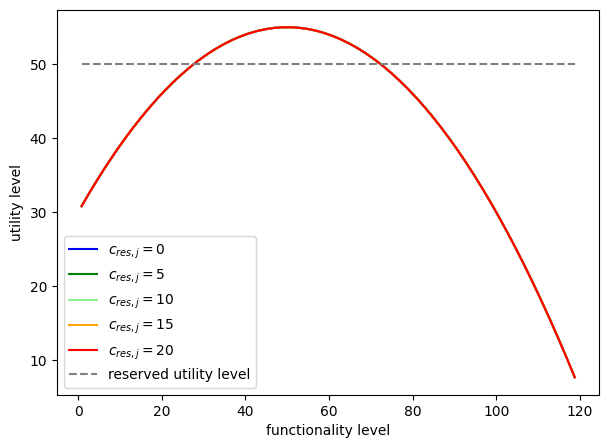

In [ ]:
plt.figure(figsize = [7,5])
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[0], color = 'blue')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[1], color = 'green')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[2], color = 'lightgreen')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[3], color = 'orange')
plt.plot(theta0_list, np.reshape(u0_list, (5, 60))[4], color = 'red')
plt.plot(theta0_list, [50] * 60, linestyle = '--', color = 'grey')
plt.legend(['$c_{res,j} = 0$', '$c_{res,j} = 5$', '$c_{res,j} = 10$',
            '$c_{res,j} = 15$', '$c_{res,j} = 20$', 'reserved utility level'])
plt.xlabel('functionality level')
plt.ylabel('utility level')
plt.show()

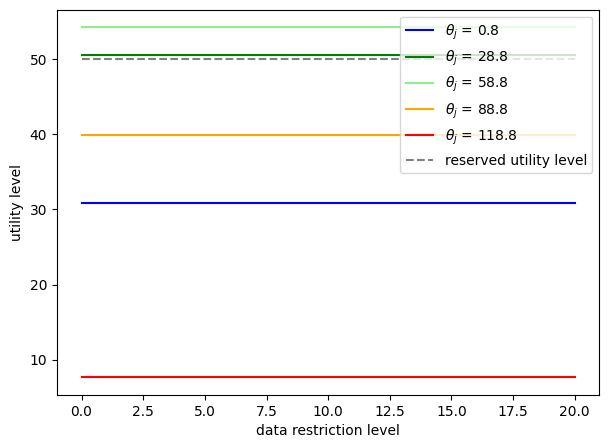

In [ ]:
plt.figure(figsize = [7,5])
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[0], color = 'blue')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[14], color = 'green')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[29], color = 'lightgreen')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[44], color = 'orange')
plt.plot(c_res0_list, np.reshape(u0_list, (5, 60)).T[59], color = 'red')
plt.plot(c_res0_list, [50] * 5, linestyle = '--', color = 'grey')
plt.legend([r'$\theta_j$' + ' = ' + str(theta0_list[0]),
            r'$\theta_j$' + ' = ' + str(theta0_list[14]),
            r'$\theta_j$' + ' = ' + str(theta0_list[29]),
            r'$\theta_j$' + ' = ' + str(theta0_list[44]),
            r'$\theta_j$' + ' = ' + str(theta0_list[59]),
            'reserved utility level'],
           loc = 'upper right')
plt.xlabel('data restriction level')
plt.ylabel('utility level')
plt.show()

## Dynamics with heuristics

### Possible extension 01: Price heuristics

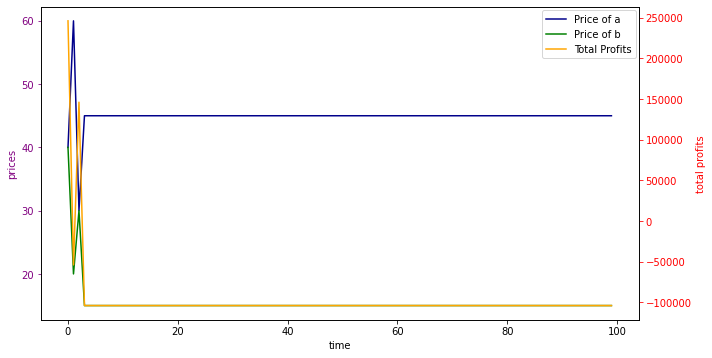

<Figure size 1080x720 with 0 Axes>

In [ ]:
kappa_a = 0.2; kappa_b = 0.2 # prices_s1; same change ratio
# kappa_a = 0.2; kappa_b = 0.5 # prices_s1_1; different change ratio
# kappa_a = 0.5; kappa_b = 0.5 # prices_s1_2; same change ratio

# scale alpha
# alpha_a = 2000 # thinking about the final payment to the Developers
# alpha_b = 2000

# cost of contract
c_0_a = 60 # adjust the cost to raise the functionality
c_0_b = 60

# policy factor: data restriction
c_res_a = 5; c_res_b = 5

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100
u_bar_b = 100

# initial prices: fixed starting point at 40, collect the scenarios
price_s_a = 40
price_s_b = 40

# loop and track the changes

price_s_a_newlist = []
price_s_b_newlist = []
profit_a_newlist = []
profit_b_newlist = []
total_profit_newlist = []

periods = 200 # t = ... periods

for t in range(periods):

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)

    total_pr = sum([pr1, pr2])

    price_s_a_newlist.append(price_s_a)
    price_s_b_newlist.append(price_s_b)
    profit_a_newlist.append(pr1)
    profit_b_newlist.append(pr2)
    total_profit_newlist.append(total_pr)

    # price updates

    if pr1 > pr2 and pr1 > 0:
        price_s_a = price_s_a * (1 + kappa_a)
        price_s_b = price_s_b * (1 - kappa_b)
    elif pr1 < pr2 and pr2 > 0:
        price_s_a = price_s_a * (1 - kappa_a)
        price_s_b = price_s_b * (1 + kappa_b)
    else:
        pass

fig, ax1 = plt.subplots(figsize = [10,5], constrained_layout=False)
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(range(inner_period), price_s_a_newlist[0:inner_period],
         'darkblue') #, label = 'price a')
ax1.plot(range(inner_period), price_s_b_newlist[0:inner_period],
         'green') #, label = 'price b')
ax1.set_xlabel('time')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('prices', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
ax2.plot(range(inner_period), total_profit_newlist[0:inner_period], 'orange')
ax2.set_ylabel('total profits', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

fig.subplots_adjust(bottom=0.1)   ##  Need to play with this number.

fig.legend(labels=['Price of a',
            'Price of b',
            'Total Profits'], bbox_to_anchor=(0.89, 0.98),
           loc="upper right", ncol=1)

plt.figure(figsize = [15,10])
plt.show()

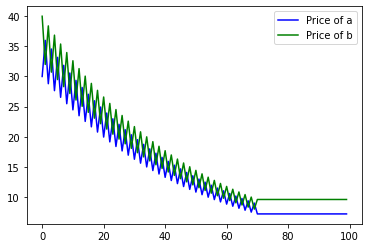

In [ ]:
inner_period = 100
plt.plot(range(inner_period), price_s_a_newlist[0:inner_period], 'blue')
plt.plot(range(inner_period), price_s_b_newlist[0:inner_period], 'green')
# plt.plot(range(20), profit_a_newlist, 'darkblue')
# plt.plot(range(20), profit_b_newlist, 'darkgreen')
# plt.plot(range(20), total_profit_newlist, 'orange')

plt.legend(['Price of a',
            'Price of b'#,
            # 'Profit of a'
            # 'Profit of b'
            # 'Total Profits'
            ])
plt.show()

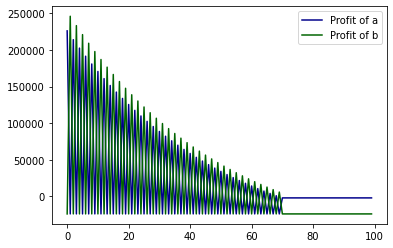

In [ ]:
inner_period = 100
# plt.plot(range(inner_period), price_s_a_newlist[0:inner_period], 'blue')
# plt.plot(range(inner_period), price_s_b_newlist[0:inner_period], 'green')
plt.plot(range(inner_period), profit_a_newlist[0:inner_period], 'darkblue')
plt.plot(range(inner_period), profit_b_newlist[0:inner_period], 'darkgreen')
# plt.plot(range(20), total_profit_newlist, 'orange')

plt.legend([
    # 'Price of a',
            # 'Price of b'#,
            'Profit of a',
            'Profit of b'
            # 'Total Profits'
            ])
plt.show()

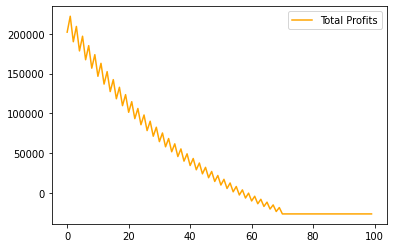

In [ ]:
inner_period = 100
# plt.plot(range(inner_period), price_s_a_newlist[0:inner_period], 'blue')
# plt.plot(range(inner_period), price_s_b_newlist[0:inner_period], 'green')
# plt.plot(range(inner_period), profit_a_newlist[0:inner_period], 'darkblue')
# plt.plot(range(inner_period), profit_b_newlist[0:inner_period], 'darkgreen')
plt.plot(range(inner_period), total_profit_newlist[0:inner_period], 'orange')

plt.legend([
    # 'Price of a',
            # 'Price of b'#,
            # 'Profit of a',
            # 'Profit of b'
            'Total Profits'
            ])
plt.show()

### Possible extension 02: Price heuristics + Investment heuristics

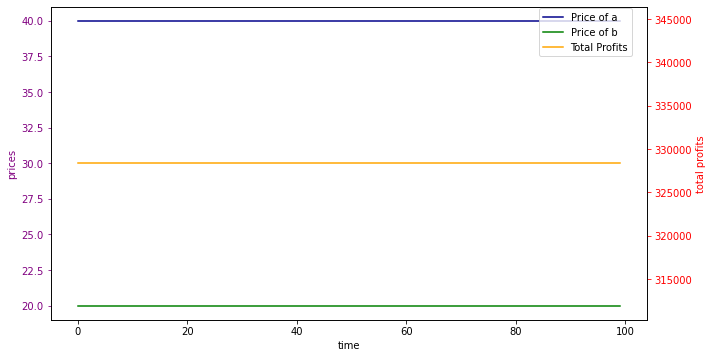

<Figure size 1080x720 with 0 Axes>

In [ ]:
inner_period = 100

kappa_a = 0.2; kappa_b = 0.2 # prices_s1; same change ratio
# kappa_a = 0.2; kappa_b = 0.5 # prices_s1_1; different change ratio
# kappa_a = 0.5; kappa_b = 0.5 # prices_s1_2; same change ratio

eta_a = 0.2; eta_b = 0.2 # prices_s1_3; same change ratio in investments

# scale alpha
# alpha_a = 2000 # thinking about the final payment to the Developers
# alpha_b = 2000

# initial cost of contract
c_0_a = 200 # adjust the cost to raise the functionality
c_0_b = 60

# policy factor: data restriction
c_res_a = 5; c_res_b = 15

# fundamental
theta_1_bar_a_value = 0.8
theta_1_bar_b_value = 0.8

# utility constant
u_bar_a = 100
u_bar_b = 100

# initial prices: fixed starting points, collect the scenarios
price_s_a = 40
price_s_b = 20

# loop and track the changes
c_0_a_newlist = []
c_0_b_newlist = []
price_s_a_newlist = []
price_s_b_newlist = []
theta_1_value_a_newlist = []
theta_1_value_b_newlist = []
profit_a_newlist = []
profit_b_newlist = []
total_profit_newlist = []
agg_welfare_newlist = []

periods = 100 # t = ... periods

for t in range(periods):

    # functionality
    theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
    theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

    # utilities
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    # reserved utility
    np.random.seed(0)
    ru = np.random.uniform(50, 50, n_customers) # homogenous

    # buy randomly from one company if the utilities are the same
    bin = np.random.binomial(1, 0.5, n_customers)

    buy = []
    buy2= []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)

    total_pr = sum([pr1, pr2])
    agg_total_cost = deltap_a(c_0_a) + m1 * c_res_a + deltap_a(c_0_b) + m2 * c_res_b
    agg_welfare = sum(welf) - agg_total_cost

    price_s_a_newlist.append(price_s_a)
    price_s_b_newlist.append(price_s_b)
    theta_1_value_a_newlist.append(theta_1_value_a)
    theta_1_value_b_newlist.append(theta_1_value_b)
    agg_welfare_newlist.append(agg_welfare)

    profit_a_newlist.append(pr1)
    profit_b_newlist.append(pr2)
    total_profit_newlist.append(total_pr)
    c_0_a_newlist.append(c_0_a)
    c_0_b_newlist.append(c_0_b)

    # price updates
    rho_1 = 1.1
    rho_2 = 1.1

    if price_s_a/price_s_b <= (1/rho_1) and theta_1_value_a/theta_1_value_b >= rho_2:
        price_s_a = price_s_a * (1 + kappa_a)
        price_s_b = price_s_b * (1 - kappa_b)
    elif price_s_a/price_s_b >= rho_1 and theta_1_value_a/theta_1_value_b <= (1/rho_2):
        price_s_a = price_s_a * (1 - kappa_a)
        price_s_b = price_s_b * (1 + kappa_b)
    else:
        pass


    if t > 5:
        if (price_s_a_newlist[t - 6]/price_s_b_newlist[t - 6] >= rho_1
            and theta_1_value_a_newlist[t - 6]/theta_1_value_b_newlist[t - 6] <= (1/rho_2)
            and t % 6 == 0):
            c_0_a = c_0_a * (1 + eta_a)
            # c_0_b = c_0_b
        elif (price_s_a_newlist[t - 6]/price_s_b_newlist[t - 6] <= 1/rho_1
            and theta_1_value_a_newlist[t - 6]/theta_1_value_b_newlist[t - 6] >= (rho_2)
            and t % 6 == 0):
            c_0_b = c_0_b * (1 + eta_b)
        else:
            pass
    else:
        pass

# Draw the figures

fig, ax1 = plt.subplots(figsize = [10,5], constrained_layout=False)
# t = np.arange(0.01, 10.0, 0.01)
# s1 = np.exp(t)
ax1.plot(range(inner_period), price_s_a_newlist[0:inner_period],
         'darkblue') #, label = 'price a')
ax1.plot(range(inner_period), price_s_b_newlist[0:inner_period],
         'green') #, label = 'price b')
ax1.set_xlabel('time')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('prices', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
ax2.plot(range(inner_period), total_profit_newlist[0:inner_period], 'orange')
ax2.set_ylabel('total profits', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

fig.subplots_adjust(bottom=0.1)   ##  Need to play with this number.

fig.legend(labels=['Price of a',
            'Price of b',
            'Total Profits'], bbox_to_anchor=(0.89, 0.98),
           loc="upper right", ncol=1)

plt.figure(figsize = [15,10])
plt.show()

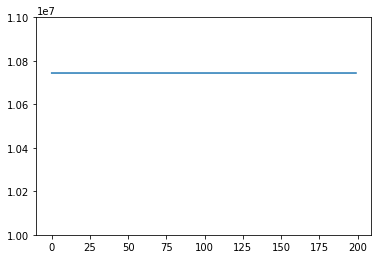

In [ ]:
plt.plot(range(inner_period), agg_welfare_newlist)
plt.ylim([10e6, 11e6])
plt.show()

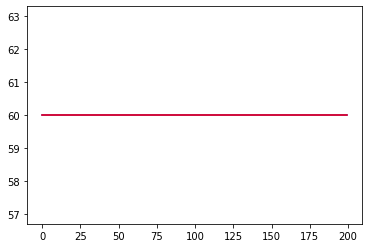

In [ ]:
plt.plot(c_0_a_newlist, 'b')
plt.plot(c_0_b_newlist, 'r')
plt.show()

In [ ]:
price_s_a_newlist.index(price_s_a)

ValueError: ignored

In [ ]:
['apple', 'pear'].index('apple')

0

In [ ]:
16%4

0

In [ ]:
price_s_a_newlist.index(price_s_a_newlist[t]) == t

False

In [ ]:
t

199

In [ ]:
# import random
# random.seed(0)
import numpy as np
import pandas as pd
np.random.seed(0)
ru = np.random.uniform(0, 100, 100)
df03 = pd.DataFrame({'random_seed_0_t3': ru.tolist()})
df03.to_csv('random_seed_0_t3.csv', index = False)

### Possible extension 03: Price heuristics under Market Analysis

Starting point

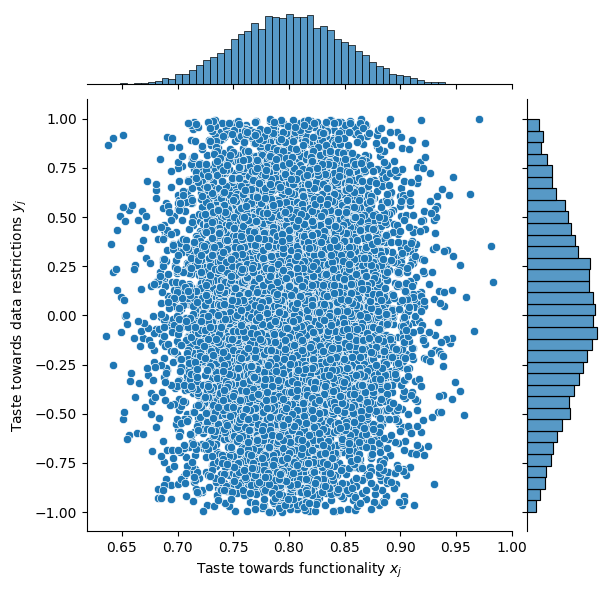

In [ ]:
### Unif. Dist. Setting
## Distribution of tastes
# sns.jointplot(data = pts_df, x = "Taste towards functionality $x_j$",
#                              y = "Taste towards data restrictions $y_j$",
#                              height = 6)

### Norm. Dist. Setting
## Distribution of tastes
# pts_df02 = pd.read_csv('rand_sample01.csv')
# pts_df02 = pd.read_csv('rand_sample02_new_10000.csv') # dislikes data restrictions
# pts_df02 = pd.read_csv('rand_sample03_new_10000.csv') # prefer data restrictions
pts_df02 = pd.read_csv('rand_sample_n01_10000.csv') # same mean but different variances
# pts_df02 = pd.read_csv('rand_sample_n02_10000.csv') # same mean but different variances

pts_df02.columns = ['Taste towards functionality $x_j$',
                    'Taste towards data restrictions $y_j$']
s = np.array(pts_df02['Taste towards functionality $x_j$'])
st_R = np.array(pts_df02['Taste towards data restrictions $y_j$'])

sns.jointplot(data = pts_df02, x = "Taste towards functionality $x_j$",
                             y = "Taste towards data restrictions $y_j$",
                             height = 6)

In [ ]:
len(pts_df02) # 10000 Consumers

10000

Price dynamics based on the market share

- Both Owners adjust the prices of the products based on the market analysis

- Following the six scenarios, the data restriction levels and the investments are considered exogenous

- Initial selling prices of $a$ and $b$: (100, 100), (100, 80), (80, 100) (we want to show how the initial price difference influences the dynamics)

2023.5.4.

- Do we need to set the exit conditions? Say, if a company earns a negative profit for many periods, then it exits the market?

- Guess: Even there is a small difference in the initial prices, the results can be very different! No, at least a difference of 5 does not change the results, yet 5.1 does.

- Guess: If the price of the opponent does not fall into the range of the price alternatives, then there will be large differences. Yes, we when the price difference exceeds the range of alternatives, one firm can always raise the price and have negative profits.

- Is it more reasonable that the alternative set should contain the price offered by the opponent in the last period? Otherwise the Owner would steadily increase the prices with continuous losses.

2023.5.5.

Check the textbook of Nagle again.

2023.5.15.

Add the results of the normal distribution.

2023.6.13.

Prof. Dawid: Corrected a typo in the codes (that would make a "cycle in the later periods, which could not be well explained").

In [ ]:
# n_s # One thought: Compare the most restricted cases: the ratio between them.

In [ ]:
## Profits of Owners at the initial point ######

# Owners select a sample of Consumers
## sample size n_s = 100
## Consumer j's taste tuple: (s[j], st_R[j])
n_s = 100 # not the number of total Consumers!

## Reserved utility level
ru_value = 50

## Initial selling prices
# price_s_a = 100; price_s_b = 100 # Case 1 # Initial prices
# price_s_a = 100; price_s_b = 80 # Case 2 # Great difference!!
# price_s_a = 100; price_s_b = 99 # Case 2.1 # No great difference
# price_s_a = 100; price_s_b = 95 # Case 2.2 # No great difference
# price_s_a = 100; price_s_b = 90 # Case 2.3 # Great difference!!
# price_s_a = 100; price_s_b = 93 # Case 2.4 # Great difference!!
# price_s_a = 100; price_s_b = 94 # Case 2.5 # Great difference!!
# price_s_a = 100; price_s_b = 94.9 # Case 2.6 # Great difference!!
# price_s_a = 80; price_s_b = 100 # Case 3
# price_s_a = 96; price_s_b = 100 # Case 3.1
# price_s_a = 95.9; price_s_b = 100 # Case 3.2 # No
# price_s_a = 94.9; price_s_b = 100 # Case 3.3 # Yes

# price_s_a = 89.9; price_s_b = 100

# price_s_a = 100; price_s_b = 20 # Case 4
# price_s_a = 20; price_s_b = 100 # Case 5
price_s_a = 20; price_s_b = 20 # Case 6 # Initial prices

# cost of contract; data restriction level
# c_0_a = 60; c_0_b = 60; c_res_a = 5; c_res_b = 5; # Scen 1
# c_0_a = 6; c_0_b = 6; c_res_a = 5; c_res_b = 5; # Scen 1.1
# c_0_a = 60; c_0_b = 60; c_res_a = 15; c_res_b = 15; # Scen 2
# c_0_a = 200; c_0_b = 200; c_res_a = 5; c_res_b = 5; # Scen 3
# c_0_a = 6; c_0_b = 20; c_res_a = 5; c_res_b = 5; # Scen 4
# c_0_a = 60; c_0_b = 60; c_res_a = 5; c_res_b = 15; # Scen 5
# c_0_a = 200; c_0_b = 60; c_res_a = 5; c_res_b = 15; # Scen 6

# new cases from the static game example
# c_0_a = 10; c_0_b = 10; c_res_a = 0; c_res_b = 0; # Scen 7.0 # enter other investments

# c_0_a = 6; c_0_b = 6; c_res_a = 0; c_res_b = 0; # Scen 7.1 # enter the initial investment
# c_0_a = 6; c_0_b = 0; c_res_a = 0; c_res_b = 0; # Scen 7.2 # enter the initial investment
# c_0_a = 6; c_0_b = 6; c_res_a = 0; c_res_b = 10; # Scen 7.3 # enter the initial investment
# c_0_a = 6; c_0_b = 0; c_res_a = 0; c_res_b = 10; # Scen 7.4 # enter the initial investment
# c_0_a = 6; c_0_b = 6; c_res_a = 10; c_res_b = 10; # Scen 7.5 # enter the initial investment
c_0_a = 6; c_0_b = 0; c_res_a = 10; c_res_b = 10; # Scen 7.6 # enter the initial investment

# c_0_a = 60; c_0_b = 60; c_res_a = 5; c_res_b = 5; # Scen 1

# initial investment
inv_a = c_0_a; inv_b = c_0_b

# fundamental
theta_1_bar_a_value = 0.8; theta_1_bar_b_value = 0.8;

# functionality
theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)

# utility constant
u_bar_a = 100; u_bar_b = 100;

# utility levels
utili_a = []
utili_b = []
for i in range(0, n_customers):
  utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
  utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

# reserved utility
# ru = np.random.uniform(50, 50, n_customers) # homog. here
ru = np.array([50] * n_customers) # homog. here, cleaner codes

# buy randomly from one company if the utilities are the same
bin = []
for i in range(50): # 50 random seeds
  np.random.seed(i) # 1. randomness in 1st period of product selections
  bin.append(np.random.binomial(1, 0.5, n_customers))

buy = []
buy2 = []
welf = []
welf_a = []; welf_b = [] # aggregate utility of Consumers related to the Owner

# get the mean for different random seeds
for j in range(50):
  for i in range(n_customers):
    if ru[i] <= max(utili_a[i], utili_b[i]):
      if utili_a[i] > utili_b[i]:
        buy.append(1)
        welf.append(utili_a[i])
        welf_a.append(utili_a[i])
      elif utili_a[i] < utili_b[i]:
        buy2.append(1)
        welf.append(utili_b[i])
        welf_b.append(utili_b[i])
      else:
        buy.append(bin[j][i])
        buy2.append(1-bin[j][i])
        if buy[-1] > 0: # Buying from Owner $a$
          welf.append(utili_a[i])
          welf_a.append(utili_a[i])
        else:
          welf.append(utili_b[i])
          welf_b.append(utili_b[i])
    else:
      pass

m1 = np.round(sum(buy)/50, 0)
m2 = np.round(sum(buy2)/50,0)
pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)

# Objective functions regarding the global welfare
agg_total_cost = deltap_a(c_0_a) + m1 * c_res_a + deltap_a(c_0_b) + m2 * c_res_b
agg_welfare = np.round(sum(welf)/50, 0) - agg_total_cost

# Regarding the welfare linked to one Owner
agg_total_cost_a = deltap_a(c_0_a) + m1 * c_res_a
agg_welfare_a = np.round(sum(welf_a)/50, 0) - agg_total_cost_a
# agg_welfare_a_pr = agg_welfare_a + pr1 # Considering welfare and profit
agg_welfare_a_pr = np.round(sum(welf_a)/50, 0) + pr1
agg_welfare_a_wf = np.round(sum(welf_a)/50, 0)

agg_total_cost_b = deltap_a(c_0_b) + m2 * c_res_b
agg_welfare_b = np.round(sum(welf_b)/50, 0) - agg_total_cost_b
# agg_welfare_b_pr = agg_welfare_b + pr2
agg_welfare_b_pr = np.round(sum(welf_b)/50, 0) + pr2
agg_welfare_b_wf = np.round(sum(welf_b)/50, 0)

## Save the initial values
price_s_a0 = price_s_a
price_s_b0 = price_s_b
pra0 = pr1
prb0 = pr2
prall0 = pr1 + pr2
welf0 = agg_welfare
welf0_a = agg_welfare_a; welf0_b = agg_welfare_b
welf0_a_pr = agg_welfare_a_pr; welf0_b_pr = agg_welfare_b_pr
welf0_a_wf = agg_welfare_a_wf; welf0_b_wf = agg_welfare_b_wf

In [ ]:
m1, m2, price_s_a, price_s_b

(10000.0, 0.0, 20, 20)

In [ ]:
welf0, welf0_a, welf0_b, welf0_a_wf, welf0_a_pr, welf0_b_pr, welf0_b_wf

(802943.0, 802943.0, 0.0, 902955.0, 1002739.0, 0.0, 0.0)

In [ ]:
# The amount of changing investment (regarded as the "learning step")
Delta_1_a = 3 # new: 0.05, 0.25, 1, 0.5 old: 5, 0.01, 0.03, 0.5, 2, 3, 20, 0.1
eta_a = Delta_1_a
Delta_1_b = 3 # 0.5 may be too small? 2, 3
eta_b = Delta_1_b

## Check the results in multiple rounds:
t = 1000 # 5, 10, 15, 100, 300, 500, 1000 ## 10 rounds: One Owner gets a loss (49.9 < 50 in the symmetric case)
### 300: better for the convergence than 100 (Scen. 3 suggests)
# t = 300

# Random variable of investment updates
rv_update = 1 # 0.01, 0.05, 0.1, 0.0, 1.0

# Parameter for checking the trend of investments: 0 is the benchmark # get different realizations
myu = 0 # 0.1, -18 cannot run # Seed must be between 0 and 2**32 - 1 # -14, -13, ... , 0, ...

# Update threshold ratio
# update_threshold = 1  # Update scen 1 # update_threshold = 1.2 # Update scen 1#
# update_threshold = 1.5 # Update scen 2
# update_threshold = 2  # Update scen 3

# update_threshold = 1.05  # Update scen 1'
update_threshold_02 = 0.01 # Focusing on the growth rate # 0.01, 0.05, 0.1, 0.001

## Update frequency parameter
tau = 6 # 3, 6, 18

# Consumers buy randomly from one company if the utilities are the same
np.random.seed(0) # 2. randomness in later periods of product selections
bin = np.random.binomial(1, 0.5, n_customers) # this could also be extended (taking mean value with different random seeds)

In [ ]:
price_s_a

20

In [ ]:
# Save the values with different random seeds (myu)

price_s_a_list_new = []; price_s_b_list_new = []
inv_a_list_new = []; inv_b_list_new = []
profit_a_list_new = []; profit_b_list_new = []
welf_a_list_new = []; welf_b_list_new = []

for myu in range(30): # 30, (50 random seeds more than 1 hour, may be reduced)

  ## Starting from each random seed
  # Initial prices
  price_s_a = 20; price_s_b = 20;

  # Initial investments
  c_0_a = 6; c_0_b = 6;

  # List for recording the values
  results_mult = []; pr1_list = []; pr2_list = []; welf_list = []
  results_mult01 = []; results_mult02 = []
  inv_a_list = []; inv_b_list = []
  c_0_a_list1 = [c_0_a]; c_0_b_list1 = [c_0_b] # updated investment list

  # First round ## Attention here!!
  # price_s_a = 100; price_s_b = 100

  price_a_new = price_s_a ## define the initial substitute for the prices
  price_b_new = price_s_b

  for k in range(t): # k is the order of the period, t is the total number of periods

    ### Replace must be False, or there would be one Consumer filling out multiple
    ### surveys for one product!!

    consumer_id = list(range(n_customers))
    np.random.seed(k)
    consumer_id_a = list(np.random.choice(consumer_id, replace=False, size=100)) # Owner a
    np.random.seed(k+1)
    consumer_id_b = list(np.random.choice(consumer_id, replace=False, size=100)) # Owner b

    ## Find the specific Consumers in the dataframe of tastes

    pts_df_a = pts_df.loc[consumer_id_a,:] # specific consumers and their tastes
    pts_df_b = pts_df.loc[consumer_id_b,:]

    ## Consumers participate in the survey and make decisions

    # price alternatives offered by Owner a

    price_alt_list_a = list(range(int(price_s_a-2), int(price_s_a+3)))

    # [price_s_a-10, price_s_a+10]; list(range(int(price_s_a-5), int(price_s_a+6)))

    # price alternatives offered by Owner b

    price_alt_list_b = list(range(int(price_s_b-2), int(price_s_b+3)))

    # [price_s_a-10, price_s_a+10]; list(range(int(price_s_a-5), int(price_s_a+6)))

    ## Construct utility level lists under every price alternative

    utili_a_alt_list = []
    utili_b_alt_list = []

    for j in price_alt_list_a:

      price_alt = j

      ## Utility levels of Consumers in the sample
      ### for now theta_1_value_a does not change
      ### (assuming no change in functionality)

      utili_a = []

      for i in range(0, n_s):
        utili_a.append(util(u_bar_a,
                            pts_df_a.loc[pts_df_a.index[i],
                                        'Taste towards functionality $x_j$'],
                            pts_df_a.loc[pts_df_a.index[i],
                                        'Taste towards data restrictions $y_j$'],
                            theta_1_value_a, c_res_a, price_alt))

      utili_a_alt_list.append(utili_a)

    ### utili_a_alt_list[0] # Every consumer's response to the first price alternative
    ### utili_a_alt_list[1] # Every consumer's response to the second price alternative

    for j in price_alt_list_b:

      price_alt = j

      utili_b = []

      for i in range(0, n_s):
        utili_b.append(util(u_bar_b,
                            pts_df_b.loc[pts_df_b.index[i],
                                        'Taste towards functionality $x_j$'],
                            pts_df_b.loc[pts_df_b.index[i],
                                        'Taste towards data restrictions $y_j$'],
                            theta_1_value_b, c_res_b, price_alt))

      utili_b_alt_list.append(utili_b)

    ## Transpose: For each price alternative, the Consumer's utility level

    utili_a_alt_tlist = list(map(list, zip(*utili_a_alt_list)))
    utili_b_alt_tlist = list(map(list, zip(*utili_b_alt_list)))

    ## Consumers give responses

    ### Count how many people will buy under a certain price?

    response_a_list = []; response_b_list = [];
    response_a_list_t = []; response_b_list_t = [];

    ## Responses to Owner a: Whether Consumers buy the product of a
    ## assuming that b offers the same price as beforef

    for j in range(len(utili_a_alt_tlist)): # Sample size: n_s, Consumer j
      for i in range(len(utili_a_alt_tlist[j])): # One certain Consumer given different prices, Price i
        if utili_a_alt_tlist[j][i] >= ru_value:
          if utili_a_alt_tlist[j][i] > util(u_bar_b,
                                            pts_df_a.loc[pts_df_a.index[j],
                                          'Taste towards functionality $x_j$'],
                                            pts_df_a.loc[pts_df_a.index[j],
                                          'Taste towards data restrictions $y_j$'],
                              theta_1_value_b, c_res_b, price_s_b):
            response_a = 1
          elif utili_a_alt_tlist[j][i] == util(u_bar_b,
                                              pts_df_a.loc[pts_df_a.index[j],
                                          'Taste towards functionality $x_j$'],
                                          pts_df_a.loc[pts_df_a.index[j],
                                          'Taste towards data restrictions $y_j$'],
                              theta_1_value_b, c_res_b, price_s_b):
            # np.random.seed()
            response_a = np.random.binomial(1, 0.5, 1)[0] # indifference
          else:
            response_a = 0
        else:
          response_a = 0
        response_a_list_t.append(response_a) # decision under one price alternative

      response_a_list.append(response_a_list_t)
      response_a_list_t = []

    ## Generate a table according to the answer of "response_a_list"

    orders_a_list = []
    for i in range(0,len(response_a_list[0])):
      orders_a_list.append(np.sum(np.array(response_a_list)[:, i]))

    ## Calculate the orders based on the market share (how many consumers will buy)

    orders_a_list_ms = []
    for i in range(0,len(response_a_list[0])):
      orders_a_list_ms.append(n_customers * orders_a_list[i]/n_s)

    ## Calculate the profits under each price alternative

    profit_a_list = []
    for i in range(0,len(response_a_list[0])):
      m = orders_a_list_ms[i]
      # profit_a_list.append(profit_a(m, price_s_a, c_0_a, c_res_a))
      profit_a_list.append(profit_a(m, price_alt_list_a[i], c_0_a, c_res_a)) # 0613

    ## Find the price which gives the largest profit (if multiple, find the largest price)

    # if max(profit_a_list) > 0:
    try:
      # price_a_argmax = price_alt_list_a[len(profit_a_list) - profit_a_list[::-1].index(max(profit_a_list)) - 1] # 0525
      price_a_argmax = price_alt_list_a[profit_a_list.index(max(profit_a_list))]
    except:
      price_a_argmax = price_alt_list_a[profit_a_list.index(max(profit_a_list))]
    price_a_new = price_a_argmax
    # else:
    #   # price_a_new = price_s_a
    #   pass

    ## Same for Owner b

    for j in range(len(utili_b_alt_tlist)): # Sample size: n_s, Consumer j
      for i in range(len(utili_b_alt_tlist[j])): # One certain Consumer given different prices, Price i
        if utili_b_alt_tlist[j][i] >= ru_value:
          if utili_b_alt_tlist[j][i] > util(u_bar_a,
                                            pts_df_b.loc[pts_df_b.index[j],
                                          'Taste towards functionality $x_j$'],
                                            pts_df_b.loc[pts_df_b.index[j],
                                          'Taste towards data restrictions $y_j$'],
                              theta_1_value_a, c_res_a, price_s_a):
            response_b = 1
          elif utili_b_alt_tlist[j][i] == util(u_bar_a,
                                              pts_df_b.loc[pts_df_b.index[j],
                                          'Taste towards functionality $x_j$'],
                                          pts_df_b.loc[pts_df_b.index[j],
                                          'Taste towards data restrictions $y_j$'],
                              theta_1_value_a, c_res_a, price_s_a):
            # np.random.seed()
            response_b = np.random.binomial(1, 0.5, 1)[0] # indifference
          else:
            response_b = 0
        else:
          response_b = 0
        response_b_list_t.append(response_b) # decision under one price alternative

      response_b_list.append(response_b_list_t)
      response_b_list_t = []

    ## Generate a table according to the answer of "response_b_list"

    orders_b_list = []
    for i in range(0,len(response_b_list[0])):
      orders_b_list.append(np.sum(np.array(response_b_list)[:, i]))

    ## Calculate the orders based on the market share (how many consumers will buy)

    orders_b_list_ms = []
    for i in range(0,len(response_b_list[0])):
      orders_b_list_ms.append(n_customers * orders_b_list[i]/n_s)

    ## Calculate the profits under each price alternative

    profit_b_list = []
    for i in range(0,len(response_b_list[0])):
      m = orders_b_list_ms[i]
      # profit_b_list.append(profit_a(m, price_s_b, c_0_b, c_res_b))
      profit_b_list.append(profit_a(m, price_alt_list_b[i], c_0_b, c_res_b)) # 0613


    ## Find the price which gives the largest profit (if multiple, find the largest price)

    # if max(profit_b_list) > 0:
    try:
      # price_b_argmax = price_alt_list_b[len(profit_b_list) - profit_b_list[::-1].index(max(profit_b_list)) - 1] # multiple
      price_b_argmax = price_alt_list_b[profit_b_list.index(max(profit_b_list))]
    except:
      price_b_argmax = price_alt_list_b[profit_b_list.index(max(profit_b_list))] # only one
    price_b_new = price_b_argmax
    # else:
    #   # price_b_new = price_s_b
    #   pass

    ## Next period

    ## Surveys, same sample size, new price alternatives based on the new price
    ### Assuming the policy factors, the investments and the functionality do not change
    ### Assuming the utility constants and the way to calculate the utility level do not change
    ### Assuming that the reserved utility does not change

    price_s_a = price_a_new
    price_s_b = price_b_new

    ### Heuristics!!!01
    ## Suppose there is an investment for both at the period 6:
    if k == tau:
      c_0_a = c_0_a + eta_a
      c_0_b = c_0_b + eta_b

    c_0_a_list1.append(c_0_a)
    c_0_b_list1.append(c_0_b)

    ## Random changes in the investment
    # if k % 6 == 0:
    #   c_0_a = c_0_a + rv_a_list[k]
    #   c_0_b = c_0_b + rv_b_list[k]

    ### 0718
    ## Average profit over the last five periods
    # if k > 11: ### 0908 check
    if (k > (2 * tau - 1)) and (k % tau == 0):
      profit_a_last_five = [] # the last five of this period (when \tau = 6)
      profit_a_last_five_p1 = [] # the last five (essentially last tau periods) of the former period
      for i in range(1, tau): # find last five
        profit_a_last_five.append(results_mult[-i][2]) # the second position in results_mult is pr1 (the profit of a)
        profit_a_last_five_p1.append(results_mult[-i-tau][2])
      profit_a_last_five_mean = np.mean(profit_a_last_five)
      profit_a_last_five_mean_p1 = np.mean(profit_a_last_five_p1)

      profit_b_last_five = []
      profit_b_last_five_p1 = []
      for i in range(1, tau): # find last five
        profit_b_last_five.append(results_mult[-i][3])
        profit_b_last_five_p1.append(results_mult[-i-tau][3])
      profit_b_last_five_mean = np.mean(profit_b_last_five)
      profit_b_last_five_mean_p1 = np.mean(profit_b_last_five_p1)
    else:
      pass

    ## Investment updates
    ## Heuristic0825: Compare the average profits (whether there has been an investment)

    ## Owner updates the investment
    if (k > (2 * tau - 1)) and (k % tau == 0):
      # if (profit_a_last_five_mean/profit_a_last_five_mean_p1 > update_threshold): # the ratio should be larger than 1 (eg. 1.05)
      if ((profit_a_last_five_mean - profit_a_last_five_mean_p1)/np.abs(profit_a_last_five_mean_p1) > update_threshold_02):
        if c_0_a_list1[-1] > c_0_a_list1[-2]: # increasing trend, positvie corr.
          c_0_a = c_0_a + eta_a
        elif c_0_a_list1[-1] < c_0_a_list1[-2]: # decreasing trend
          c_0_a = c_0_a - eta_a
        else: # unchanged
          pass

      # elif (profit_a_last_five_mean/profit_a_last_five_mean_p1 < (1/update_threshold)):
      elif ((profit_a_last_five_mean - profit_a_last_five_mean_p1)/np.abs(profit_a_last_five_mean_p1) < -update_threshold_02):
        if c_0_a_list1[-1] > c_0_a_list1[-2]: # increasing trend, negative corr.
          c_0_a = c_0_a - eta_a
        elif c_0_a_list1[-1] < c_0_a_list1[-2]: # decreasing trend
          c_0_a = c_0_a + eta_a
        else: # unchanged
          pass
      else:
        pass
      if c_0_a > 0: # guarantee a postive investment
        c_0_a_list1.append(c_0_a)
      else:
        c_0_a = 0
        c_0_a_list1.append(c_0_a)
    else:
      pass

    ## Check for constant
    if (k > (3 * tau - 1)) and (k % tau == 0):
      if c_0_a_list1[-1] == c_0_a_list1[-2]:
        if c_0_a_list1[-2] == c_0_a_list1[-3]: # if the investment is stable for three periods
          if c_0_a_list1[-1] > 0:
            value_investment = c_0_a_list1[-1]
            np.random.seed(k-1+myu)
            prob00 = np.random.choice([-1, 1], size=1)[0]
            if prob00 > 0:
              np.random.seed(k+myu)
              c_0_a = value_investment + np.random.choice([-rv_update, rv_update], size=1)[0] # adjustment of the investment
            else:
              c_0_a = value_investment
            c_0_a_list1[-1] = c_0_a
          else: # if the investment is stable at zero
            value_investment = c_0_a_list1[-1]
            # np.random.seed(k+myu)
            np.random.seed(k-1+myu) # in this period prob00 should be the same as above
            prob00 = np.random.choice([-1, 1], size=1)[0]
            if prob00 > 0:
              # np.random.seed(k+myu)
              c_0_a = value_investment + rv_update # adjustment of the investment
              # c_0_a = value_investment + np.random.choice([-rv_update, rv_update], size=1)[0] # adjustment of the investment
            else:
              c_0_a = value_investment
            c_0_a_list1[-1] = c_0_a
        else:
          pass
      else:
        pass
    else:
      pass

    ## Same for Owner b
    if (k > (2 * tau - 1)) and (k % tau == 0):
      # if (profit_b_last_five_mean/profit_b_last_five_mean_p1 > update_threshold): # the ratio should be larger than 1 (eg. 1.05)
      if ((profit_b_last_five_mean - profit_b_last_five_mean_p1)/np.abs(profit_b_last_five_mean_p1) > update_threshold_02):
        if c_0_b_list1[-1] > c_0_b_list1[-2]: # increasing trend, positvie corr.
        # if c_0_b_list1[-1] >= c_0_b_list1[-2]: # increasing trend, positvie corr.
          c_0_b = c_0_b + eta_b
        elif c_0_b_list1[-1] < c_0_b_list1[-2]: # decreasing trend
          c_0_b = c_0_b - eta_b
        else: # unchanged
          pass
          # c_0_b = c_0_b - eta_b

      # elif (profit_b_last_five_mean/profit_b_last_five_mean_p1 < (1/update_threshold)):
      elif ((profit_b_last_five_mean - profit_b_last_five_mean_p1)/np.abs(profit_b_last_five_mean_p1) < -update_threshold_02):
        if c_0_b_list1[-1] > c_0_b_list1[-2]: # increasing trend, negative corr.
        # if c_0_b_list1[-1] >= c_0_b_list1[-2]: # increasing trend, negative corr.
          c_0_b = c_0_b - eta_b
        elif c_0_b_list1[-1] < c_0_b_list1[-2]: # decreasing trend
          c_0_b = c_0_b + eta_b
        else: # unchanged
          pass
          # c_0_b = c_0_b + eta_b
      else:
        pass
      if c_0_b > 0: # guarantee a postive investment
        c_0_b_list1.append(c_0_b)
      else:
        c_0_b = 0
        c_0_b_list1.append(c_0_b)
    else:
      pass

    ## Check for constant
    if (k > (3 * tau - 1)) and (k % tau == 0):
      if c_0_b_list1[-1] == c_0_b_list1[-2]:
        if c_0_b_list1[-2] == c_0_b_list1[-3]: # if the investment is stable for three periods
          if c_0_b_list1[-1] > 0:
            value_investment = c_0_b_list1[-1]
            np.random.seed(k+myu)
            prob00 = np.random.choice([-1, 1], size=1)[0]
            if prob00 > 0:
              np.random.seed(k+1+myu) # may differ from a because of randomness
              c_0_b = value_investment + np.random.choice([-rv_update, rv_update], size=1)[0] # adjustment of the investment
            else:
              c_0_b = value_investment
            c_0_b_list1[-1] = c_0_b
          else: # if the investment is stable at zero
            value_investment = c_0_b_list1[-1]
            # np.random.seed(k+1+myu)
            np.random.seed(k+myu)
            prob00 = np.random.choice([-1, 1], size=1)[0]
            if prob00 > 0:
              # np.random.seed(k+1+myu)
              c_0_b = value_investment + rv_update # adjustment of the investment
            else:
              c_0_b = value_investment
            c_0_b_list1[-1] = c_0_b
        else:
          pass
      else:
        pass
    else:
      pass
    ### Heuristics!!!0825


    ## Insert the investment to functionality
    # functionality
    theta_1_value_a = theta_func(theta_1_bar_a_value, c_0_a)
    theta_1_value_b = theta_func(theta_1_bar_b_value, c_0_b)
    ### 0718

    # utility levels
    utili_a = []
    utili_b = []
    for i in range(0, n_customers):
      utili_a.append(util(u_bar_a, s[i], st_R[i], theta_1_value_a, c_res_a, price_s_a))
      utili_b.append(util(u_bar_b, s[i], st_R[i], theta_1_value_b, c_res_b, price_s_b))

    buy = []; buy2 = []; welf = []; welf_a = []; welf_b = []

    for i in range(0, n_customers):
      if ru[i] <= max(utili_a[i], utili_b[i]):
        if utili_a[i] > utili_b[i]:
          buy.append(1)
          welf.append(utili_a[i])
          welf_a.append(utili_a[i])
        elif utili_a[i] < utili_b[i]:
          buy2.append(1)
          welf.append(utili_b[i])
          welf_b.append(utili_b[i])
        else:
          buy.append(bin[i])
          buy2.append(1-bin[i])
          if buy[-1] > 0:
            welf.append(utili_a[i])
            welf_a.append(utili_a[i])
          else:
            welf.append(utili_b[i])
            welf_b.append(utili_b[i])
      else:
        pass

    m1 = sum(buy)
    m2 = sum(buy2)
    pr1 = profit_a(m1, price_s_a, c_0_a, c_res_a)
    pr2 = profit_a(m2, price_s_b, c_0_b, c_res_b)

    # Objective functions regarding the global welfare
    agg_total_cost = deltap_a(c_0_a) + m1 * c_res_a + deltap_a(c_0_b) + m2 * c_res_b
    agg_welfare = sum(welf) - agg_total_cost

    # Regarding the welfare linked to one Owner
    agg_total_cost_a = deltap_a(c_0_a) + m1 * c_res_a
    agg_welfare_a = sum(welf_a) - agg_total_cost_a
    # agg_welfare_a_pr = agg_welfare_a + pr1 # Considering welfare and profit
    agg_welfare_a_pr = sum(welf_a) + pr1
    agg_welfare_a_wf = sum(welf_a)

    agg_total_cost_b = deltap_a(c_0_b) + m2 * c_res_b
    agg_welfare_b = sum(welf_b) - agg_total_cost_b
    # agg_welfare_b_pr = agg_welfare_b + pr2
    agg_welfare_b_pr = sum(welf_b) + pr2
    agg_welfare_b_wf = sum(welf_b)

    ## Save the results of this round

    results_mult.append([price_s_a, price_s_b, pr1, pr2, pr1 + pr2, agg_welfare])
    results_mult01.append([agg_welfare_a, agg_welfare_b, agg_welfare_a_pr, agg_welfare_b_pr])
    results_mult02.append([agg_welfare_a_wf, agg_welfare_b_wf])

    inv_a_list.append(c_0_a)
    inv_b_list.append(c_0_b)

    ### Save the profits of this round
    # pr1_list.append(pr1)
    # pr2_list.append(pr2)
    # welf_list.append(agg_welfare)

  # results_mult # Format: price_a, price_b, profit_a, profit_b, total_profit
  ## Transpose: Show the changes in each variable

  results_tmult = list(map(list, zip(*results_mult)))

  # results_tmult[0] # Changes in price_a
  results_tmult01 = list(map(list, zip(*results_mult01)))
  results_tmult02 = list(map(list, zip(*results_mult02)))

  # Save the values

  price_s_a_list_new.append([price_s_a0] + results_tmult[0])
  price_s_b_list_new.append([price_s_b0] + results_tmult[1])

  inv_a_list_new.append([inv_a] + inv_a_list)
  inv_b_list_new.append([inv_b] + inv_b_list)

  profit_a_list_new.append([pra0] + results_tmult[2])
  profit_b_list_new.append([prb0] + results_tmult[3])

  welf_a_list_new.append([welf0_a_pr] + results_tmult01[2])
  welf_b_list_new.append([welf0_b_pr] + results_tmult01[3])


In [ ]:
## Save the time series with different random seeds

with open("prices001.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(price_s_a_list_new)

with open("prices_b001.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(price_s_b_list_new)

with open("inv_a_list_new.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(inv_a_list_new)

with open("inv_b_list_new.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(inv_b_list_new)

with open("profit_a_list_new.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(profit_a_list_new)

with open("profit_b_list_new.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(profit_b_list_new)

with open("welf_a_list_new.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(welf_a_list_new)

with open("welf_b_list_new.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(welf_b_list_new)

In [ ]:
########
# 19:02 - 20:07 Check 30 seeds, 1000 periods' simulation # 1h 5min. (eduroam)
# 22:44 - 23:51 1h 7min. (o2)
# Fewer price alternatives, less computation time. (40min.)

In [ ]:
n_s

100

In [ ]:
pd.DataFrame({'prices_a_01': price_s_a_list_new[0],
              'prices_a_02': price_s_a_list_new[1],
              'prices_a_03': price_s_a_list_new[2]})

[20,
 30,
 29,
 34,
 29,
 32,
 29,
 27,
 29,
 27,
 30,
 25,
 30,
 26,
 29,
 28,
 29,
 28,
 24,
 22,
 27,
 28,
 32,
 28,
 33,
 30,
 30,
 34,
 29,
 34,
 31,
 31,
 33,
 34,
 33,
 32,
 27,
 27,
 30,
 31,
 29,
 33,
 32,
 27,
 32,
 33,
 29,
 31,
 26,
 31,
 31,
 30,
 31,
 31,
 28,
 28,
 28,
 23,
 28,
 33,
 31,
 27,
 31,
 30,
 32,
 31,
 27,
 32,
 28,
 32,
 30,
 25,
 28,
 24,
 28,
 26,
 29,
 31,
 31,
 30,
 31,
 31,
 26,
 29,
 29,
 27,
 23,
 28,
 25,
 26,
 24,
 25,
 26,
 29,
 34,
 29,
 24,
 26,
 21,
 26,
 25,
 29,
 30,
 26,
 26,
 27,
 29,
 24,
 26,
 28,
 33,
 28,
 33,
 29,
 34,
 29,
 24,
 22,
 20,
 25,
 21,
 21,
 23,
 21,
 23,
 22,
 23,
 26,
 22,
 21,
 20,
 22,
 24,
 28,
 32,
 29,
 25,
 25,
 26,
 28,
 30,
 32,
 27,
 24,
 27,
 24,
 25,
 23,
 20,
 23,
 21,
 26,
 22,
 22,
 24,
 20,
 22,
 17,
 21,
 18,
 22,
 21,
 22,
 19,
 24,
 21,
 23,
 27,
 23,
 24,
 24,
 21,
 26,
 30,
 29,
 29,
 24,
 25,
 23,
 28,
 27,
 28,
 27,
 32,
 27,
 25,
 27,
 24,
 27,
 32,
 33,
 31,
 28,
 27,
 26,
 26,
 21,
 25,
 24,
 23,


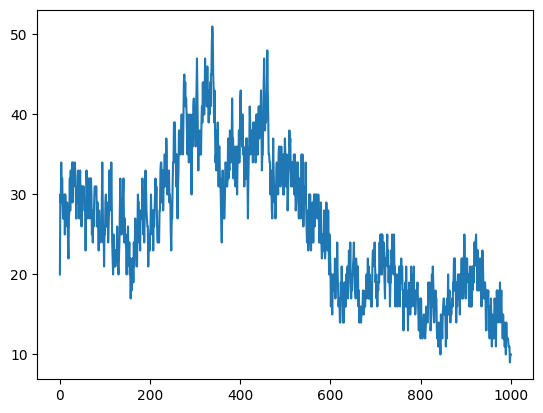

In [ ]:
plt.plot(price_s_b_list_new[2])

In [ ]:
# price_s_a_list_new

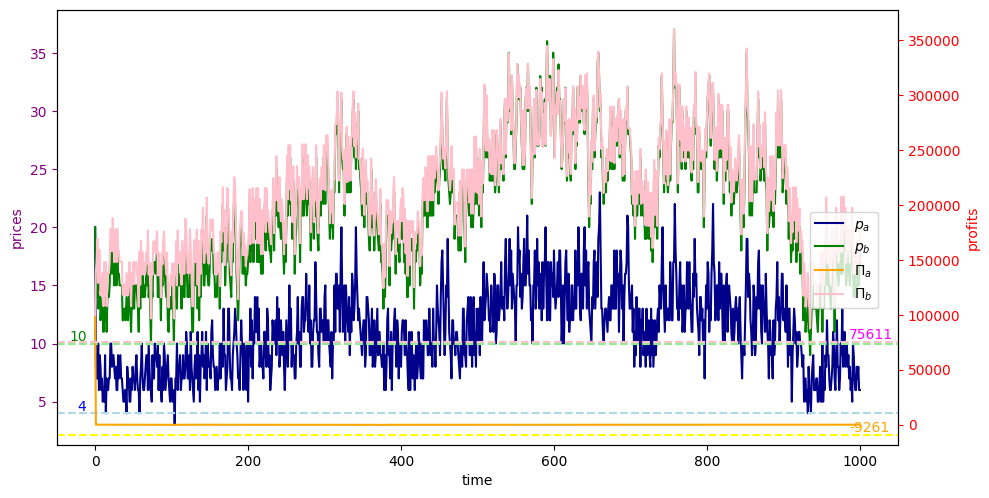

<Figure size 9000x6000 with 0 Axes>

In [ ]:
# Draw the figures

fig, ax1 = plt.subplots(figsize = [10,5], constrained_layout=False)


ax1.plot(range(t+1), price_s_a_list_new[0], 'darkblue')
ax1.plot(range(t+1), price_s_b_list_new[0], 'green')
# ax1.plot(range(t+1), inv_a_list_new, "-.", color = 'aqua')
# ax1.plot(range(t+1), inv_b_list_new, "-.", color = '#EEDFCC')

ax1.set_xlabel('time')

# Make the y-axis label, ticks and tick labels match the line color.

ax1.set_ylabel('prices', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
ax2.plot(range(t+1), profit_a_list_new[0], 'orange')
ax2.plot(range(t+1), profit_b_list_new[0], 'pink') #magenta
ax2.set_ylabel('profits', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

fig.subplots_adjust(bottom=0.1)   ##  Need to play with this number.

fig.legend(labels=['$p_a$',
            '$p_b$', # "$c_{0,a}$", "$c_{0,b}$",
            '$\Pi_a$',
            '$\Pi_b$'],
           bbox_to_anchor=(0.89, 0.58),
           ncol=1)

ax1.axhline(y = results_tmult[0][-1], color='lightblue', linestyle='--')
ax1.axhline(y = results_tmult[1][-1], color='lightgreen', linestyle='--')
ax2.axhline(y = results_tmult[2][-1], color='yellow', linestyle='--')
ax2.axhline(y = results_tmult[3][-1], color='pink', linestyle='--')

ax1.text(-18, results_tmult[0][-1], f'{results_tmult[0][-1]}',
         ha='center', va='bottom', color='blue')
ax1.text(-22, results_tmult[1][-1], f'{results_tmult[1][-1]}',
         ha='center', va='bottom', color='green')


# ax2.text(312, results_tmult[2][-1], f'{int(results_tmult[2][-1])}', #309
#          ha='center', va='bottom', color='orange')

# ax2.text(314, results_tmult[3][-1], f'{int(results_tmult[3][-1])}', #1012
#          ha='center', va='bottom', color='magenta')


ax2.text(1012, results_tmult[2][-1], f'{int(results_tmult[2][-1])}', #309
         ha='center', va='bottom', color='orange')

ax2.text(1014, results_tmult[3][-1], f'{int(results_tmult[3][-1])}', #1012
         ha='center', va='bottom', color='magenta')

plt.figure(figsize = [15,10], dpi=600) # sce2_new1_case1

plt.show() # lightblue and lightgreen dashlines show the values in the last period # fig0001

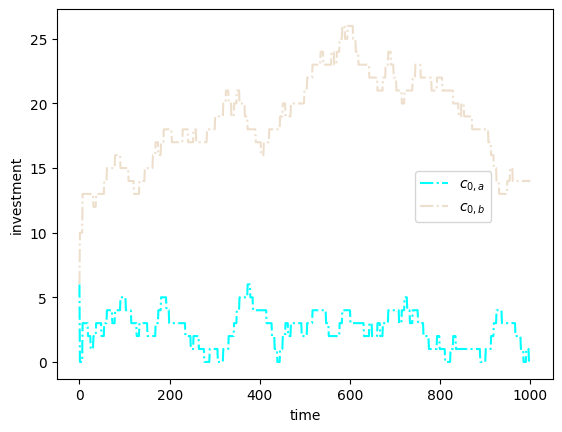

In [ ]:
plt.plot(range(t+1), inv_a_list_new[0], "-.", color = 'aqua') # range(t+1)
plt.plot(range(t+1), inv_b_list_new[0], "-.", color = '#EEDFCC')

plt.xlabel('time')
plt.ylabel('investment')
plt.legend(labels=["$c_{0,a}$", "$c_{0,b}$"],
           bbox_to_anchor=(0.89, 0.58),
           ncol=1)
plt.show() # fig0002

In [ ]:
results_tmult

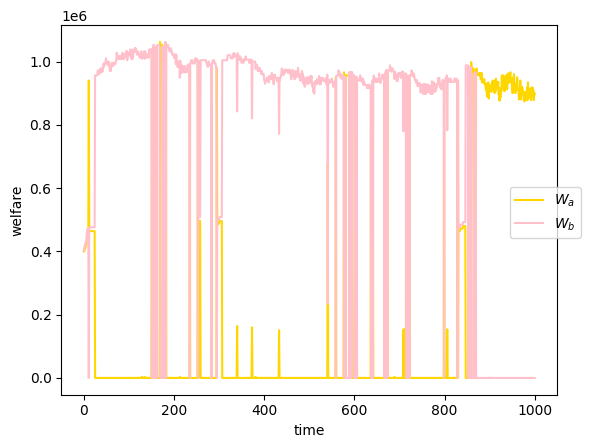

In [ ]:
plt.plot(range(t+1), [welf0_a] + results_tmult01[0], "-", color = 'gold') # range(t+1)
plt.plot(range(t+1), [welf0_b] + results_tmult01[1], "-", color = 'pink')

# plt.plot(range(t+1), [welf0_a_pr] + results_tmult01[2], "-.", color = 'hotpink') # range(t+1)
# plt.plot(range(t+1), [welf0_b_pr] + results_tmult01[3], "-.", color = 'khaki')

plt.xlabel('time')
plt.ylabel('welfare')
plt.legend(labels=["$W_a$", "$W_b$"
  #, "$W^{'}_a$", "$W^{'}_b$"
  ],
           bbox_to_anchor=(0.89, 0.58),
           ncol=1)
plt.show() # fig0002_1

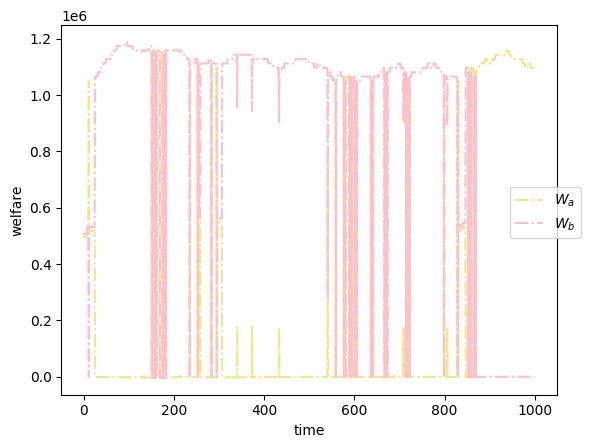

In [ ]:
# plt.plot(range(t+1), [welf0_a] + results_tmult01[0], "-", color = 'crimson') # range(t+1)
# plt.plot(range(t+1), [welf0_b] + results_tmult01[1], "-", color = 'gold')

plt.plot(range(t+1), [welf0_a_pr] + results_tmult01[2], "-.", color = 'khaki') # range(t+1)
plt.plot(range(t+1), [welf0_b_pr] + results_tmult01[3], "-.", color = 'pink')

plt.xlabel('time')
plt.ylabel('welfare')
# plt.legend(labels=["$W^{'}_a$", "$W^{'}_b$"],
#            bbox_to_anchor=(0.89, 0.58),
#            ncol=1)
plt.legend(labels=["$W_a$", "$W_b$"],
           bbox_to_anchor=(0.89, 0.58),
           ncol=1)

plt.show() # fig0002_1

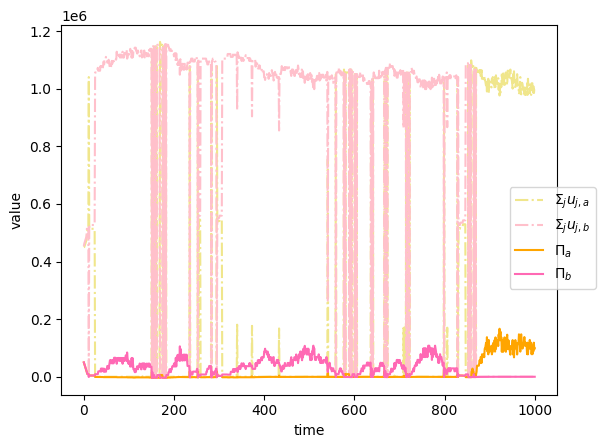

In [ ]:
# Decompose the aggregate utility and the profit
plt.plot(range(t+1), [welf0_a_wf] + results_tmult02[0], "-.", color = 'khaki') # range(t+1)
plt.plot(range(t+1), [welf0_b_wf] + results_tmult02[1], "-.", color = 'pink')
plt.plot(range(t+1), profit_a_list_new, 'orange')
plt.plot(range(t+1), profit_b_list_new, 'hotpink') #magenta

plt.xlabel('time')
plt.ylabel('value')
plt.legend(labels=["$\Sigma_j u_{j,a}$", "$\Sigma_j u_{j,b}$", "$\Pi_a$", "$\Pi_b$"],
           bbox_to_anchor=(0.89, 0.58),
           ncol=1)
plt.show() # fig0002_2

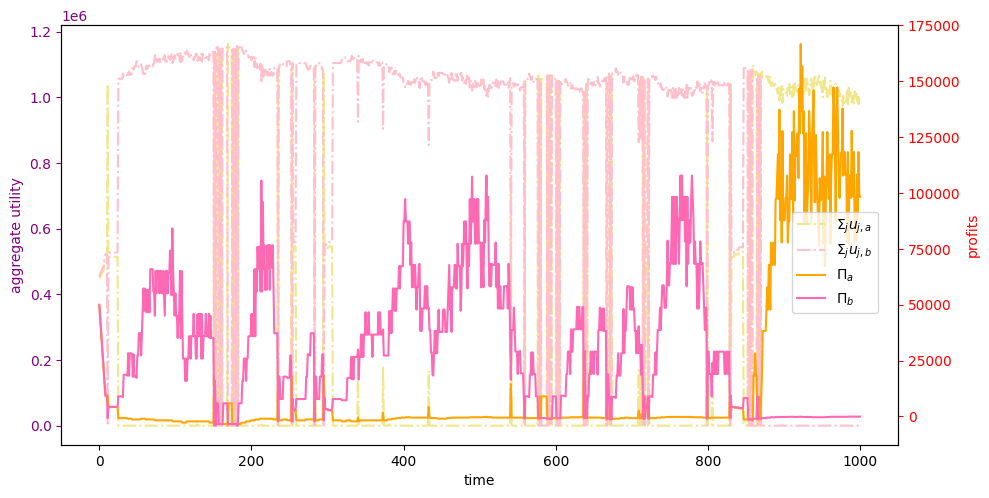

<Figure size 9000x6000 with 0 Axes>

In [ ]:
# Draw the figures

fig, ax1 = plt.subplots(figsize = [10,5], constrained_layout=False)

# ax1.plot(range(t+1), price_s_a_list_new, 'darkblue')
# ax1.plot(range(t+1), price_s_b_list_new, 'green')
ax1.plot(range(t+1), [welf0_a_wf] + results_tmult02[0], "-.", color = 'khaki') # range(t+1)
ax1.plot(range(t+1), [welf0_b_wf] + results_tmult02[1], "-.", color = 'pink')

ax1.set_xlabel('time')
ax1.set_ylabel('aggregate utility', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
ax2.plot(range(t+1), profit_a_list_new, 'orange')
ax2.plot(range(t+1), profit_b_list_new, 'hotpink') #magenta
ax2.set_ylabel('profits', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

fig.subplots_adjust(bottom=0.1)   ##  Need to play with this number.

fig.legend(labels=['$\Sigma_j u_{j,a}$',
            '$\Sigma_j u_{j,b}$', # "$c_{0,a}$", "$c_{0,b}$",
            '$\Pi_a$',
            '$\Pi_b$'],
           bbox_to_anchor=(0.89, 0.58),
           ncol=1)

plt.figure(figsize = [15,10], dpi=600) # sce2_new1_case1

plt.show() # lightblue and lightgreen dashlines show the values in the last period # fig0001

In [ ]:
0.2 * 10**6

200000.0

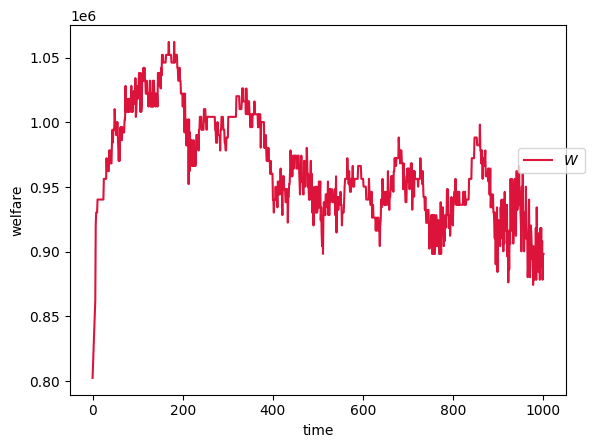

In [ ]:
# Check
results_aggre = np.add([welf0_a] + results_tmult01[0],
                       [welf0_b] + results_tmult01[1])

plt.plot(range(t+1), results_aggre, "-", color = 'crimson') # range(t+1)

plt.xlabel('time')
plt.ylabel('welfare')
plt.legend(labels=["$W$"],
           bbox_to_anchor=(0.89, 0.58),
           ncol=1)
plt.show() # fig0002

In [ ]:
inv_a_list_new[0:10]

[6, 6, 6, 6, 6, 6, 6, 9, 9, 9]

In [ ]:
profit_a_list_new[0:10]

[49154, 44208, 39272, 34336, 29400, 24464, 19528, 14079, 9143, 9143]

In [ ]:
profit_b_list_new[0:10]

[50414, 45360, 40296, 35232, 30168, 25104, 20040, 14463, 9399, 9399]

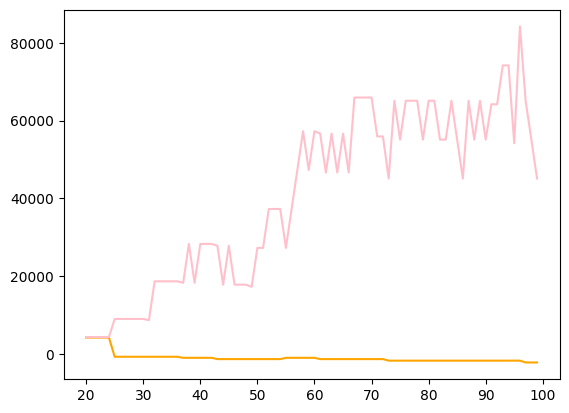

In [ ]:
## Visualize the profits of 20 - 100 (periods)
plt.plot(list(range(20,100)), profit_a_list_new[20:100], color = "orange")
plt.plot(list(range(20,100)), profit_b_list_new[20:100], color = "pink")
plt.show()

In [ ]:
np.min(results_tmult[2])

-4096

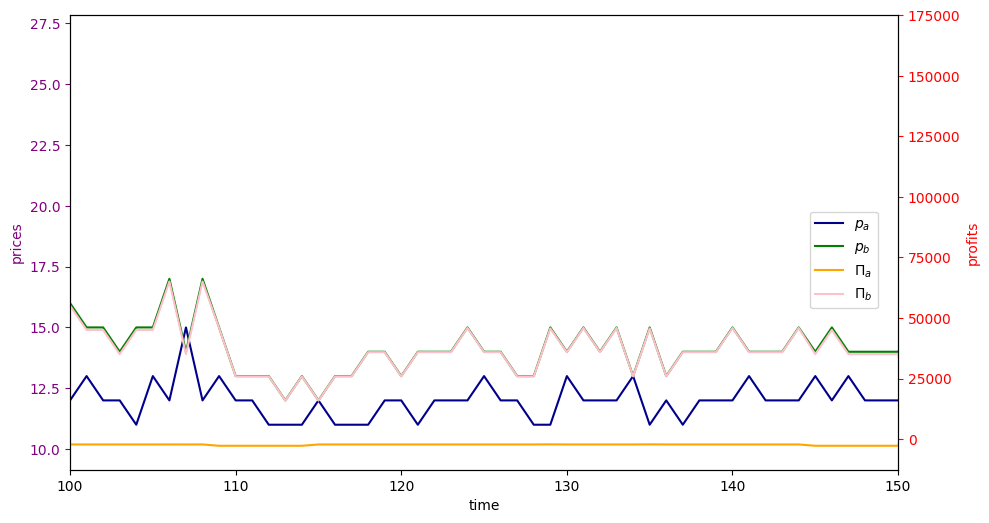

<Figure size 3000x2400 with 0 Axes>

In [ ]:
# Part of the figure above
# Draw the figures

fig, ax1 = plt.subplots(figsize = [10,5], constrained_layout=False)

ax1.plot(range(t+1), [price_s_a0] + results_tmult[0], 'darkblue')
ax1.plot(range(t+1), [price_s_b0] + results_tmult[1], 'green')

ax1.set_xlabel('time')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_xlim([100, 150])
ax1.set_ylabel('prices', color='purple')
ax1.tick_params('y', colors='purple')
# ax1.set_ylim([0, 10])

ax2 = ax1.twinx()
ax2.plot(range(t+1), [pra0] + results_tmult[2], 'orange')
ax2.plot(range(t+1), [prb0] + results_tmult[3], 'pink') #magenta
ax2.set_ylabel('profits', color='r')
ax2.tick_params('y', colors='r')
# ax2.set_ylim([-30000, 0])


fig.tight_layout()

fig.subplots_adjust(bottom=0.05)   ##  Need to play with this number.

fig.legend(labels=['$p_a$',
            '$p_b$',
            '$\Pi_a$',
            '$\Pi_b$'],
           bbox_to_anchor=(0.89, 0.58),
           ncol=1)

# ax1.axhline(y = results_tmult[0][-1], color='lightblue', linestyle='--')
# ax1.axhline(y = results_tmult[1][-1], color='lightgreen', linestyle='--')

# ax1.text(44.5, results_tmult[0][-1], f'{results_tmult[0][-1]}',
#          ha='center', va='bottom', color='blue')
# ax1.text(44.5, results_tmult[1][-1], f'{results_tmult[1][-1]}',
#          ha='center', va='bottom', color='green')

plt.figure(figsize = [10,8], dpi=300) # sce2_new1_case1

plt.show()

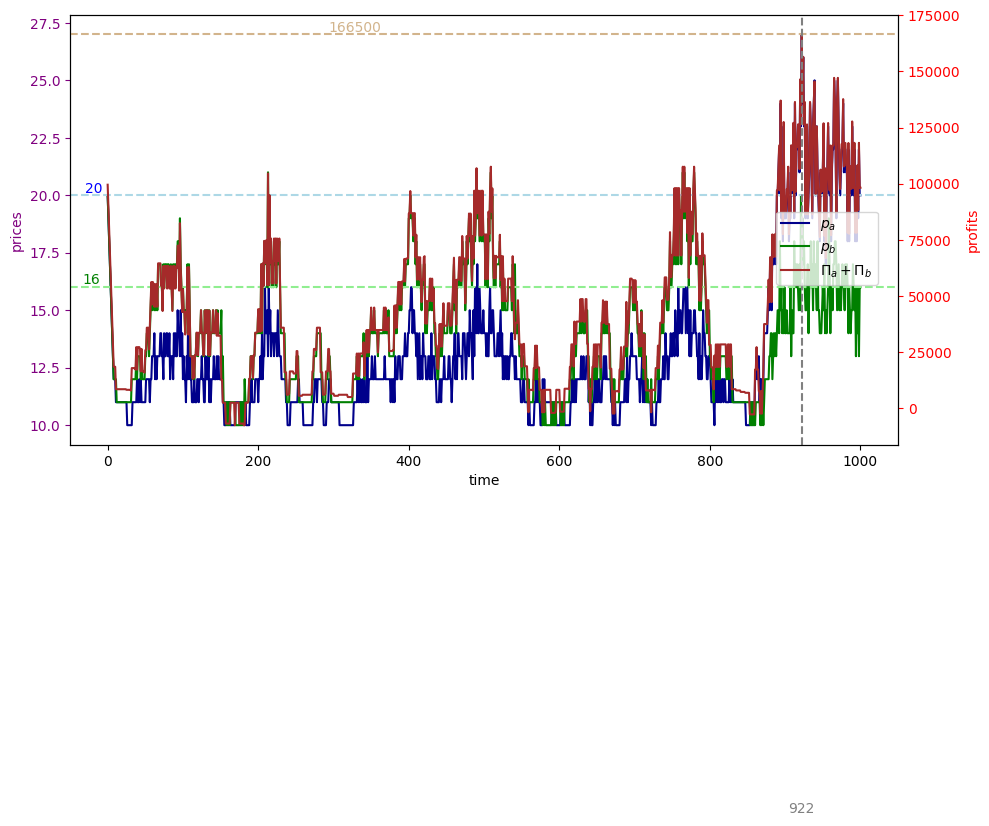

<Figure size 9000x6000 with 0 Axes>

In [ ]:
# Draw the figures

fig, ax1 = plt.subplots(figsize = [10,5], constrained_layout=False)

ax1.plot(range(t+1), [price_s_a0] + results_tmult[0], 'darkblue')
ax1.plot(range(t+1), [price_s_b0] + results_tmult[1], 'green')
ax1.set_xlabel('time')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('prices', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
ax2.plot(range(t+1), [prall0] + results_tmult[4], 'brown')
ax2.set_ylabel('profits', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

fig.subplots_adjust(bottom=0.1)   ##  Need to play with this number.

fig.legend(labels=['$p_a$',
            '$p_b$',
            '$\Pi_a + \Pi_b$'],
           bbox_to_anchor=(0.89, 0.58),
           ncol=1)

ax1.axhline(y = results_tmult[0][-1], color='lightblue', linestyle='--')
ax1.axhline(y = results_tmult[1][-1], color='lightgreen', linestyle='--')
# ax2.axhline(y = results_tmult[4][-1], color='sandybrown', linestyle='--')

if np.max(results_tmult[4]) > prall0:
  ax2.axhline(y = np.max(results_tmult[4]), color='tan', linestyle='--')
  ax2.axvline(x = 1 + results_tmult[4].index(np.max(results_tmult[4])),
              color='grey', linestyle='--')
else:
  ax2.axhline(y = prall0, color='tan', linestyle='--')
  ax2.axvline(x = 0,
              color='grey', linestyle='--')

ax1.text(-18, results_tmult[0][-1], f'{results_tmult[0][-1]}',
         ha='center', va='bottom', color='blue')
ax1.text(-22, results_tmult[1][-1], f'{results_tmult[1][-1]}',
         ha='center', va='bottom', color='green')

if np.max(results_tmult[4]) > prall0:
  ax2.text(328, np.max(results_tmult[4]), f'{np.max(results_tmult[4])}',
          ha='center', va='bottom', color='tan')
  ax1.text(1 + results_tmult[4].index(np.max(results_tmult[4])), -7,
          f'{1 + results_tmult[4].index(np.max(results_tmult[4]))}',
          ha='center', va='bottom', color='grey') # notice that we put period 0 ahead!
else:
  ax2.text(328, prall0, f'{prall0}',
          ha='center', va='bottom', color='tan')
  # ax1.text(0, 2,
  #         f'{1 + results_tmult[4].index(np.max(results_tmult[4]))}',
  #         ha='center', va='bottom', color='grey')

plt.figure(figsize = [15,10], dpi=600) # sce2_new1_case1_1
plt.show()

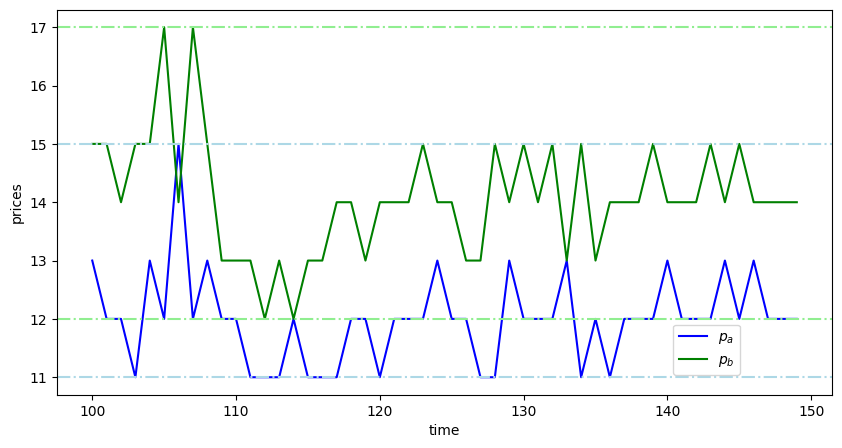

In [ ]:
plt.figure(figsize = [10,5])
plt.plot(range(100, 150), results_tmult[0][100:150], color = 'blue')
plt.plot(range(100, 150), results_tmult[1][100:150], color = 'green')
plt.axhline(np.max(results_tmult[0][100:150]), color = 'lightblue',
           linestyle = '-.')
plt.axhline(np.max(results_tmult[1][100:150]), color = 'lightgreen',
           linestyle = '-.')
plt.axhline(np.min(results_tmult[0][100:150]), color = 'lightblue',
           linestyle = '-.')
plt.axhline(np.min(results_tmult[1][100:150]), color = 'lightgreen',
           linestyle = '-.')

plt.legend(labels=['$p_a$','$p_b$'],
           bbox_to_anchor=(0.89, 0.2),
           ncol=1)
plt.xlabel('time')
plt.ylabel('prices')

plt.show()

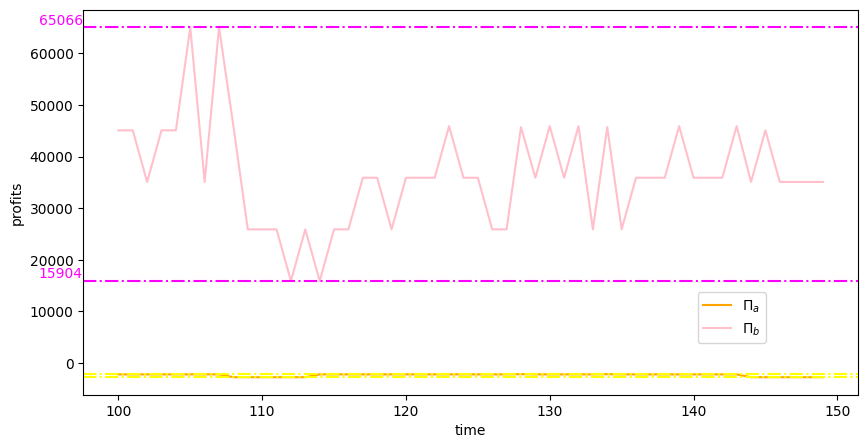

In [ ]:
plt.figure(figsize = [10,5])
plt.plot(range(100, 150), results_tmult[2][100:150], color = 'orange')
plt.plot(range(100, 150), results_tmult[3][100:150], color = 'pink')
plt.axhline(np.max(results_tmult[2][100:150]), color = 'yellow',
           linestyle = '-.')
plt.axhline(np.max(results_tmult[3][100:150]), color = 'magenta',
           linestyle = '-.')
plt.axhline(np.min(results_tmult[2][100:150]), color = 'yellow',
           linestyle = '-.')
plt.axhline(np.min(results_tmult[3][100:150]), color = 'magenta',
           linestyle = '-.')
plt.text(96, np.max(results_tmult[3][100:150]),
         f'{np.max(results_tmult[3][100:150])}',
        ha='center', va='bottom', color='magenta')
plt.text(96, np.min(results_tmult[3][100:150]),
         f'{np.min(results_tmult[3][100:150])}',
        ha='center', va='bottom', color='magenta')

plt.legend(labels=['$\Pi_a$','$\Pi_b$'],
           bbox_to_anchor=(0.89, 0.2),
           ncol=1)
plt.xlabel('time')
plt.ylabel('profits')

plt.show()

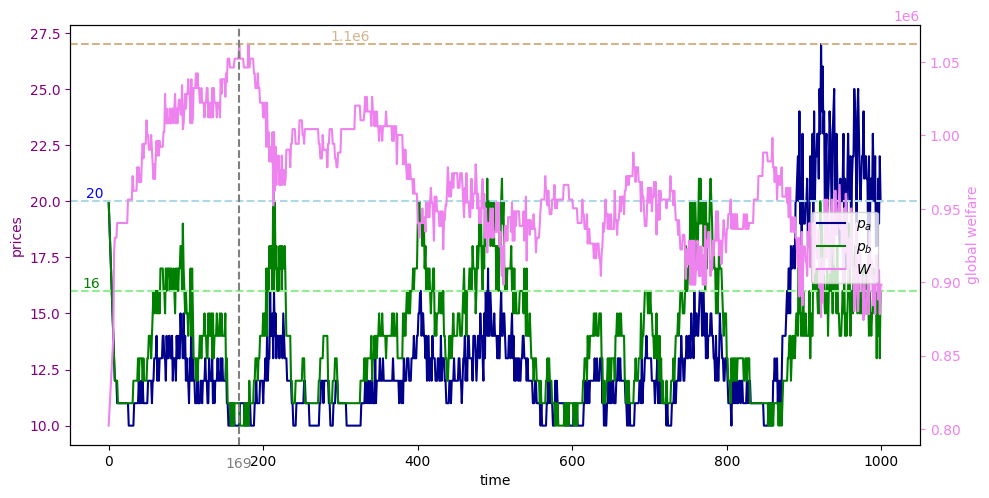

<Figure size 9000x6000 with 0 Axes>

In [ ]:
# Draw the figures

fig, ax1 = plt.subplots(figsize = [10,5], constrained_layout=False)

ax1.plot(range(t+1), [price_s_a0] + results_tmult[0], 'darkblue')
ax1.plot(range(t+1), [price_s_b0] + results_tmult[1], 'green')
ax1.set_xlabel('time')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('prices', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
ax2.plot(range(t+1), [welf0] + results_tmult[5], 'violet')
ax2.set_ylabel('global welfare', color='violet')
ax2.tick_params('y', colors='violet')

fig.tight_layout()

fig.subplots_adjust(bottom=0.1)   ##  Need to play with this number.

fig.legend(labels=['$p_a$', '$p_b$', '$W$'],
           bbox_to_anchor=(0.89, 0.58),
           ncol=1)

ax1.axhline(y = results_tmult[0][-1], color='lightblue', linestyle='--')
ax1.axhline(y = results_tmult[1][-1], color='lightgreen', linestyle='--')
ax2.axhline(y = np.max(results_tmult[5]), color='tan', linestyle='--')
ax2.axvline(x = 1 + results_tmult[5].index(np.max(results_tmult[5])),
            color='grey', linestyle='--')

ax1.text(-18, results_tmult[0][-1], f'{results_tmult[0][-1]}',
         ha='center', va='bottom', color='blue')
ax1.text(-22, results_tmult[1][-1], f'{results_tmult[1][-1]}',
         ha='center', va='bottom', color='green')

ax2.text(312, np.max(results_tmult[5]),
         f'{np.max(results_tmult[5]):.1e}'.replace("+0", ""),
         ha='center', va='bottom', color='tan')

ax1.text(1 + results_tmult[5].index(np.max(results_tmult[5])), 8,# always find the right position for the axis # -8
         f'{1 + results_tmult[5].index(np.max(results_tmult[5]))}',
         ha='center', va='bottom', color='grey')

plt.figure(figsize = [15,10], dpi=600) # sce2_new1_case1_1
plt.show() # fig0003

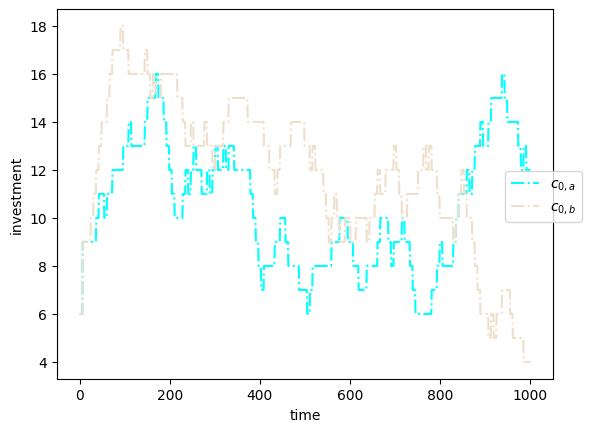

In [ ]:
plt.plot(range(t+1), inv_a_list_new, "-.", color = 'aqua') # range(t+1)
plt.plot(range(t+1), inv_b_list_new, "-.", color = '#EEDFCC')

plt.xlabel('time')
plt.ylabel('investment')
plt.legend(labels=["$c_{0,a}$", "$c_{0,b}$"],
           bbox_to_anchor=(0.89, 0.58),
           ncol=1)
plt.show() # fig0002

In [ ]:
# Above checked 0613

If there are collusion, then the Owners could split the market and offer much higher prices than the equilibrium prices. There should be a maximal total profit.